# Part1_Data_Preparation

# Federated Deep Learning For a Privacy-preserved Activity Recognition

### Presentation by :

####  Setareh Kazemi Kheiri (UB Person No.: 50415734)
####  Siri Valluri (UB Person No.: 50372657) 
* To access the Part1_Data_Preparation JUPYTER notebook, please refer to this link on google drive:

https://drive.google.com/file/d/1-EClBslBFpzL9jRogPKJPHpvaUZJ9zc_/view?usp=sharing
* To access the Part2_Federated_Learning JUPYTER notebook, please refer to this link on google drive:

https://drive.google.com/file/d/1zRcaznsXWUW_CtuU1tzuJ2hNnUlbI6z-/view?usp=sharing

# Dataset Description and Preparation

### Dataset :

1) The dataset we used is from the paper **"Classifying tasks performed by electrical line worker using a wrist-worn sensor: A data analytic approach"**. 


2) In this paper, they investigated how features can be engineered from a single wrist-worn accelerometer for the purpose of classifying Electrical-Line-Workers tasks.

### Paper Source : 

@unpublished{LamookiHajifar2021HAR, 
  author ={Lamooki, Saeb Ragani and Hajifar, Sahand and Hannan, Jacqueline and Sun, Hongyue and Megahed, Fadel M and Cavuoto, Lora A}, 
  title = {Classifying tasks performed by electrical line workers
  using a wrist-worn sensor: A data analytic approach}, 
  year={2022},
  journal = {PLOS ONE}, 
  note = {(in press)} }
  
  
### Github Link : 

@misc{Lamooki2022GitHub,
  author = {Lamooki, S.R.},
  title = {{HAR GitHub} Git Hub Repository for codes related to the classification of tasks performed by electrical line workers},
  year = 2022,
  howpublished = "\url{https://github.com/saebragani/Activity-Recognition}",
  note = {"Accessed: 2022-11-28"}
}

## Dataset :

####  37 subjects were recruited to perform the 10 tasks listed below and collected the acceleration signals from a signle wrist-worn Empatica E4 accelerometer.

    1) Sitting on a chair while keeping hands still on the chair arms for 3 minutes
    2) Standing still for 3 minutes
    3) Walking on a set path for 3 minutes
    4) Hoisting a weighted bucket up and down to a height of 4 m for 10 repetitions
    5) Lifting and lowering a weighted box for 20 repetitions
    6) Pushing a cart on a set path for 10 repetitions
    7) Typing on a computer for 3 minutes
    8) Climbing up and down a ladder for 20 repetitions
    9) Working on an electrical panel for 3 minutes
    10) Inserting screws using a screw driver at an overhead height for 3 minute

## Importing needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
from scipy import stats
import ipywidgets as widgets
from scipy.fftpack import fft
from scipy.signal import welch
from detecta import detect_peaks
import time
import datetime
import random
import os
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
import dill
import pywt
from collections import Counter
import pickle
import warnings
warnings.simplefilter("ignore")
from platform import python_version
print(python_version())

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


3.9.14


## Data Preparation :

#### We employed the procedure in the github link to prepare the data.

Functions:

The functions in the following code snippet read the acceleration and annotation data and store the 3 acceleration signals (ax,ay,az) in the  3 columns and their corresponding labels in the 4th column in numpy arrays.

In [3]:
def readData(accDir, annotFile):
    files = os.listdir(accDir)
    files_csv = [f for f in files if f[-3:] == 'csv']
    empatica_dict = dict()
    for f in files_csv:
        data = np.genfromtxt(accDir+f, delimiter=',') # creates numpy array for each Empatica acc csv file
        key = int(float(f.strip("ACC.csv")))
        empatica_dict[key] = data
    tmp = pd.read_excel(annotFile, sheet_name=None)
    annot_dict = dict(zip(tmp.keys(), [i.dropna() for i in tmp.values()])) # Remove the rows with NaN values (some with ladder 2 missing)
    return empatica_dict, annot_dict

def getLabeledDict(empatica_dict, annot_dict, subject_ids):
    labeled_dict = {}; taskInd_dict = {}
    for id in subject_ids:
        start_time = int(empatica_dict[id][0,0])
        acc = empatica_dict[id][2:,:]
        label = list(map(lambda i: i.replace("_end", "").replace("_start", ""), annot_dict['P'+ str(id)].taskName.tolist()))
        task_time= list(map(lambda i: time.mktime(datetime.datetime.strptime(i[:6] + '20' + i[6:], "%m/%d/%Y %H:%M:%S").timetuple()),
                            annot_dict['P'+ str(id)].startTime_global.tolist()))
        task_ind = [int(x - start_time)*SR for x in task_time]
        taskInd_dict[id] = task_ind
        label_tmp = np.empty(acc.shape[0], dtype=object)
        for i, (j, k) in enumerate(zip(task_ind[0::2], task_ind[1::2])):
            tmpInd = 2*i
            label_tmp[j:k] = label[tmpInd]
        labeled_dict[id] = np.hstack((acc, label_tmp.reshape(label_tmp.shape[0],1)))
    return labeled_dict, taskInd_dict

### Create Dictionaries of Labeled Numpy Arrays for each Subject :


In the following code functions are used to store the sessions' data in a dictionary with the subject numbers as keys.

In [6]:
sepAccDict, sepAnnotDict = readData(accDir='/Users/Asus/Downloads/Activity_Recognition_Data/Acc Data/separate/', annotFile='/Users/Asus/Downloads/Activity_Recognition_Data/Annotation Data/separate.xlsx')
SR=int(sepAccDict[8][1,0])
sepSubIDs = list(range(8,45))
sepLabeledDict, sepTaskIndDict = getLabeledDict(sepAccDict, sepAnnotDict, sepSubIDs)

### Functions to Visualize Signals with the Task Start and End for Each Subject :

In [7]:
def plotSigAnnot(labeled_dict, taskInd_dict, id, figSize):
    f, axs = plt.subplots(3,1,figsize=figSize)
    axs[0].plot(labeled_dict[id][:,0])
    for v in taskInd_dict[id]:
        axs[0].axvline(v, c="r", linewidth=1)
    axs[0].set_title("$a_X$", fontsize=30)

    axs[1].plot(labeled_dict[id][:,1])
    for v in taskInd_dict[id]:
        axs[1].axvline(v, c="r", linewidth=1)
    axs[1].set_title('$a_Y$', fontsize=30)

    axs[2].plot(labeled_dict[id][:,2])
    for v in taskInd_dict[id]:
        axs[2].axvline(v, c="r", linewidth=1)
    axs[2].set_title('$a_Z$', fontsize=30)
    
    return f

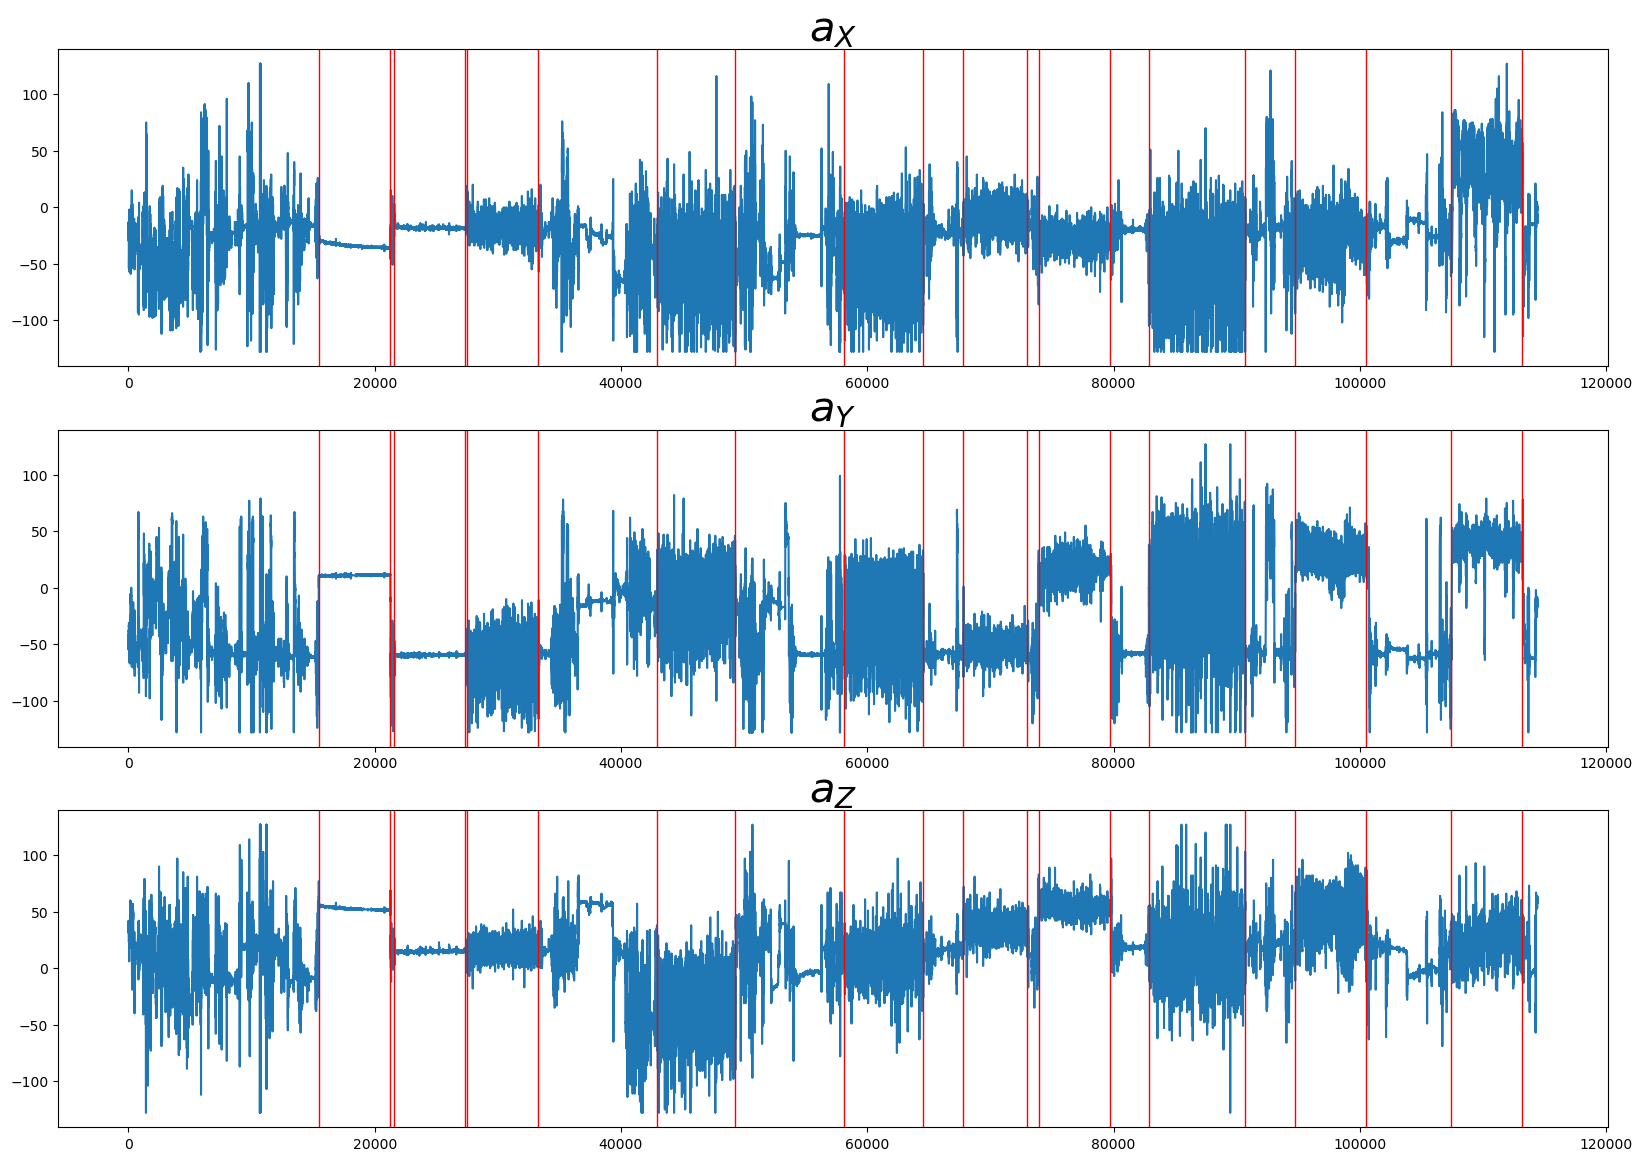

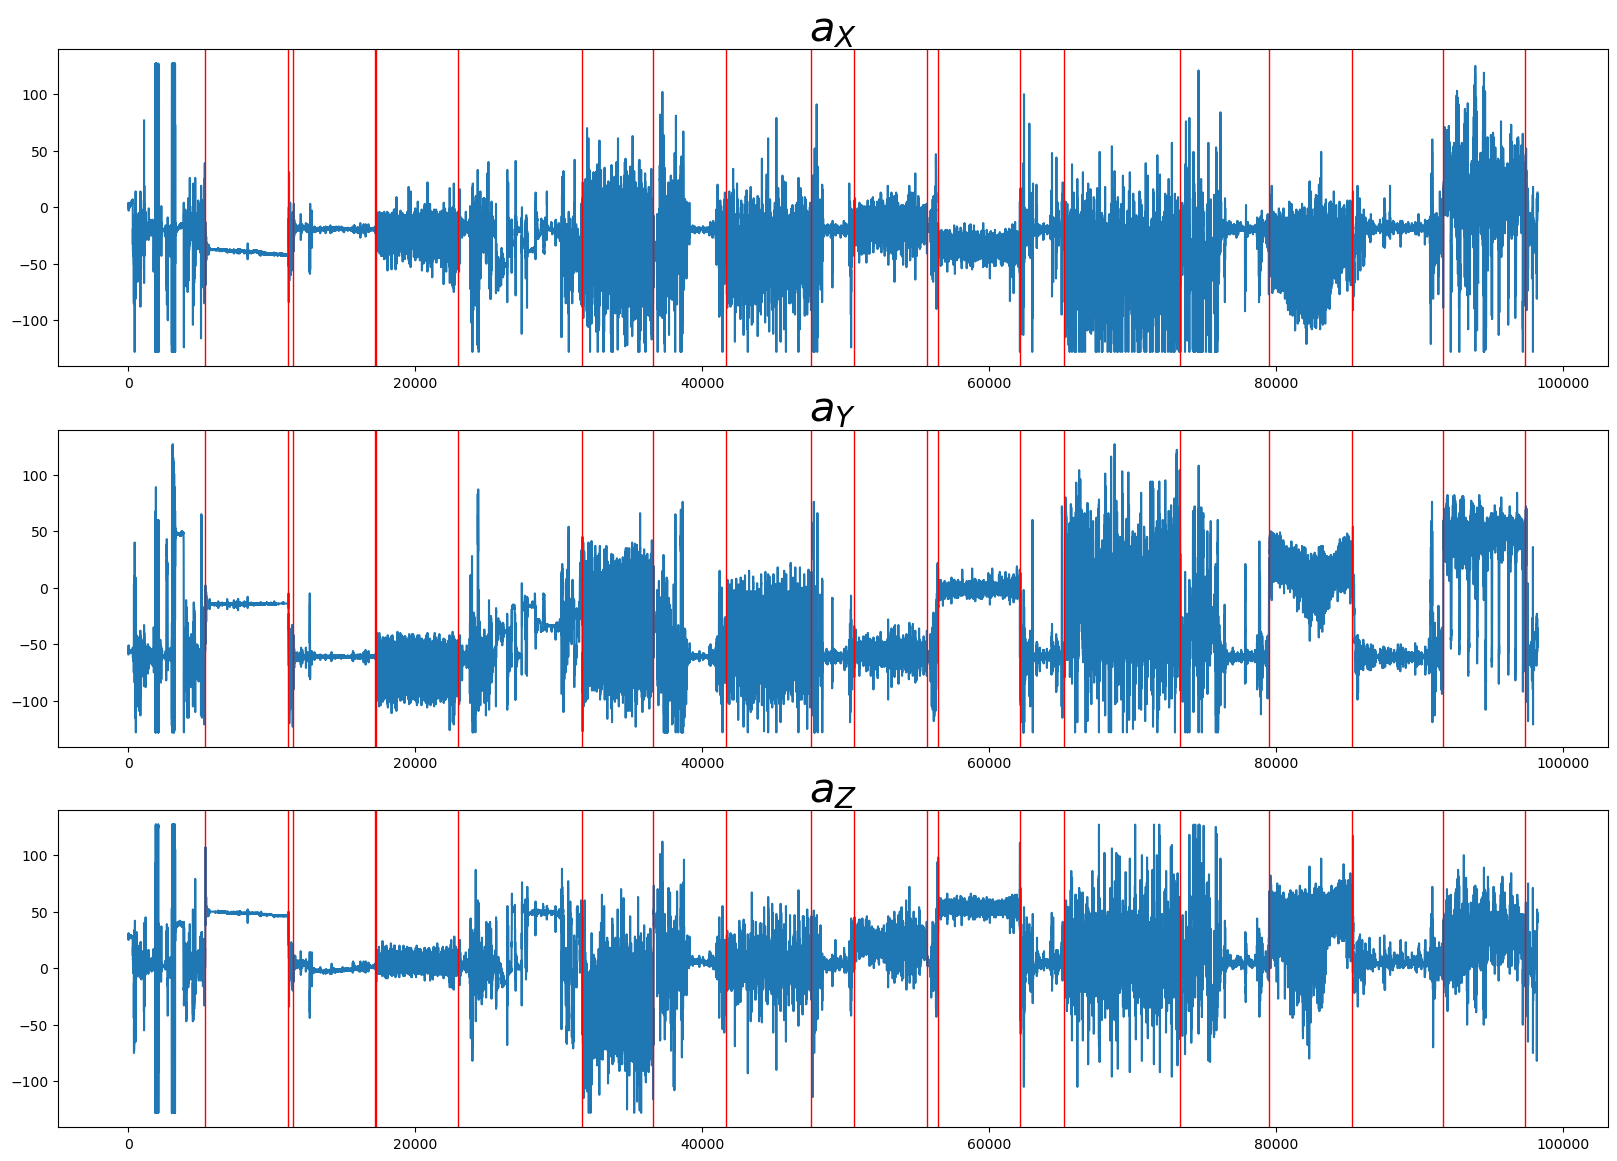

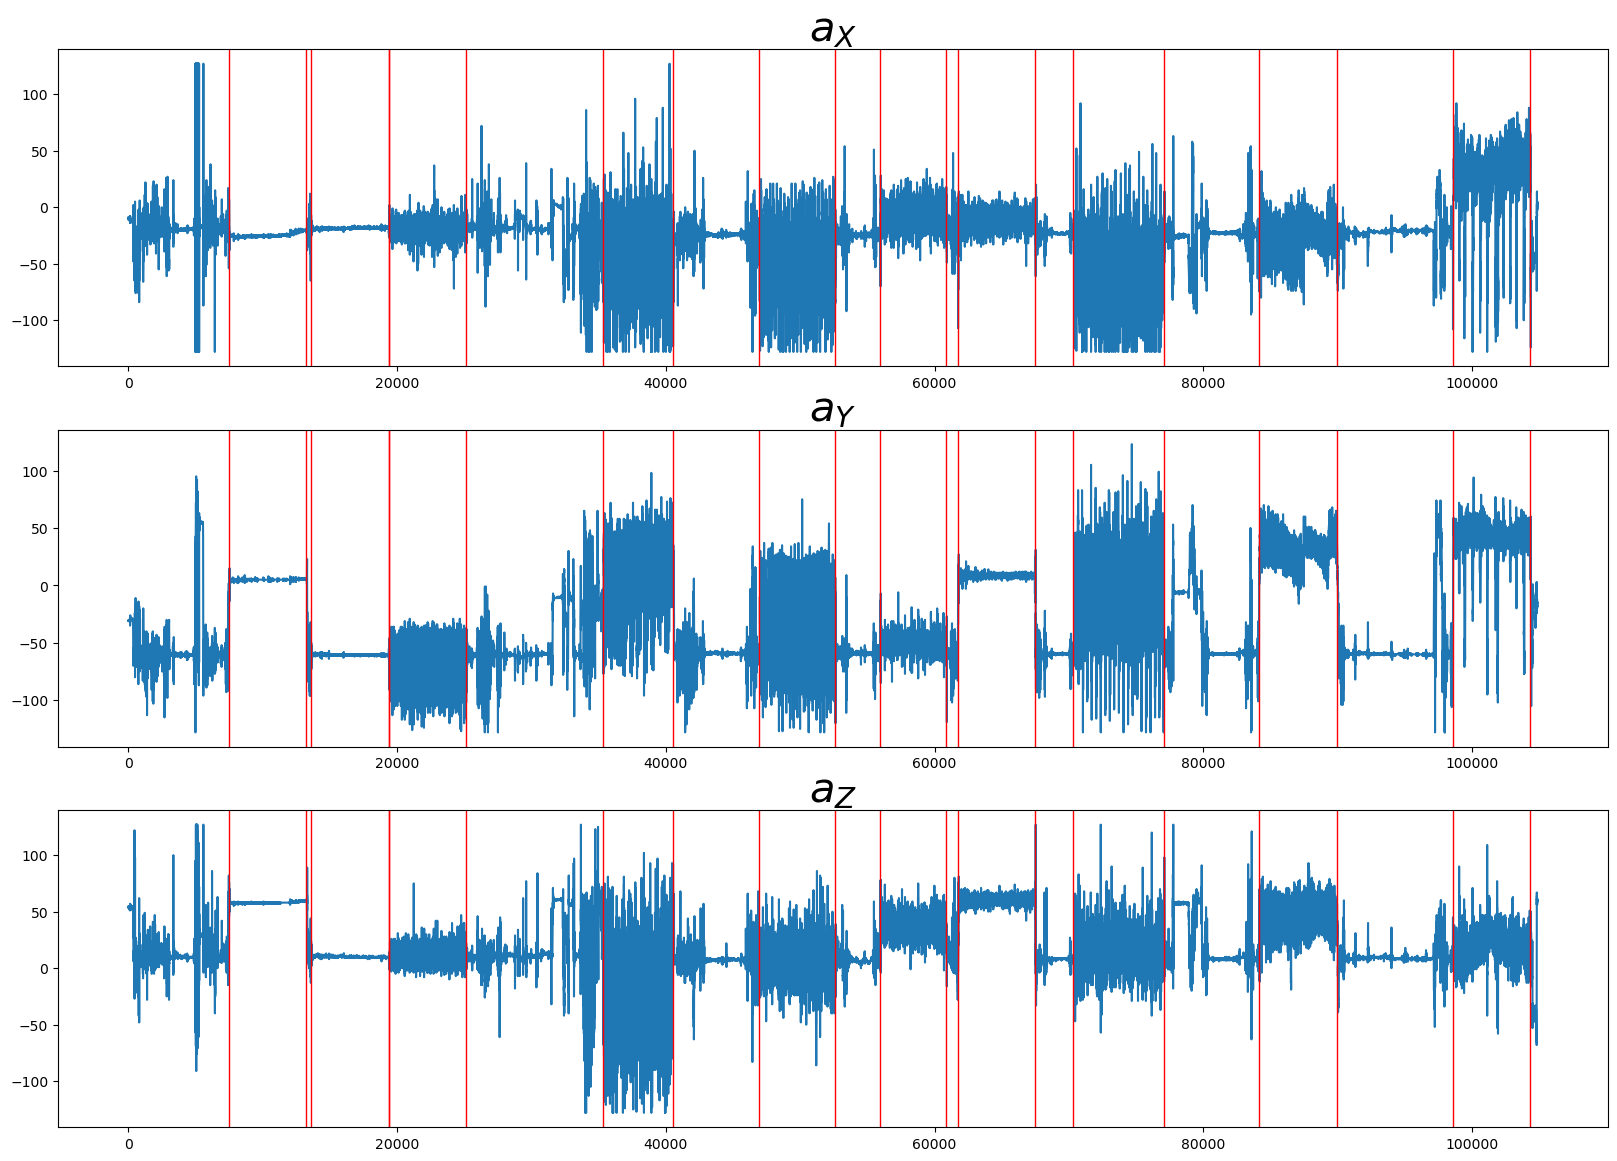

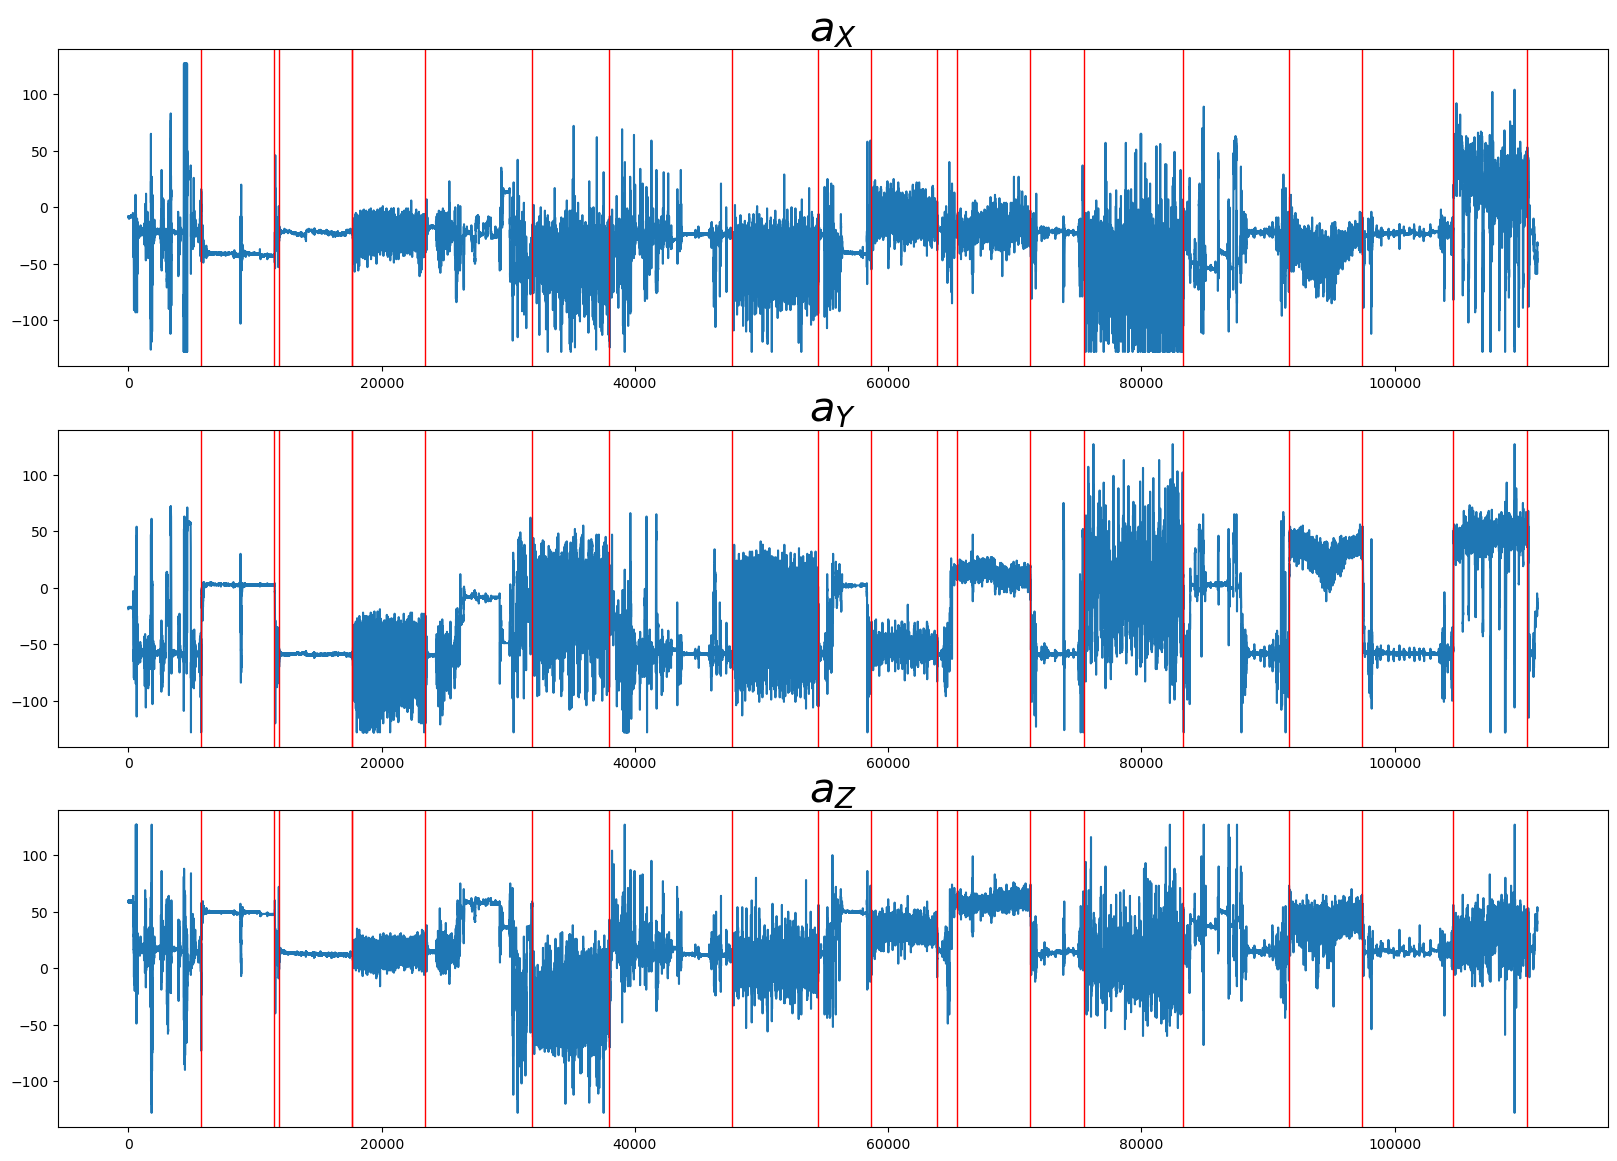

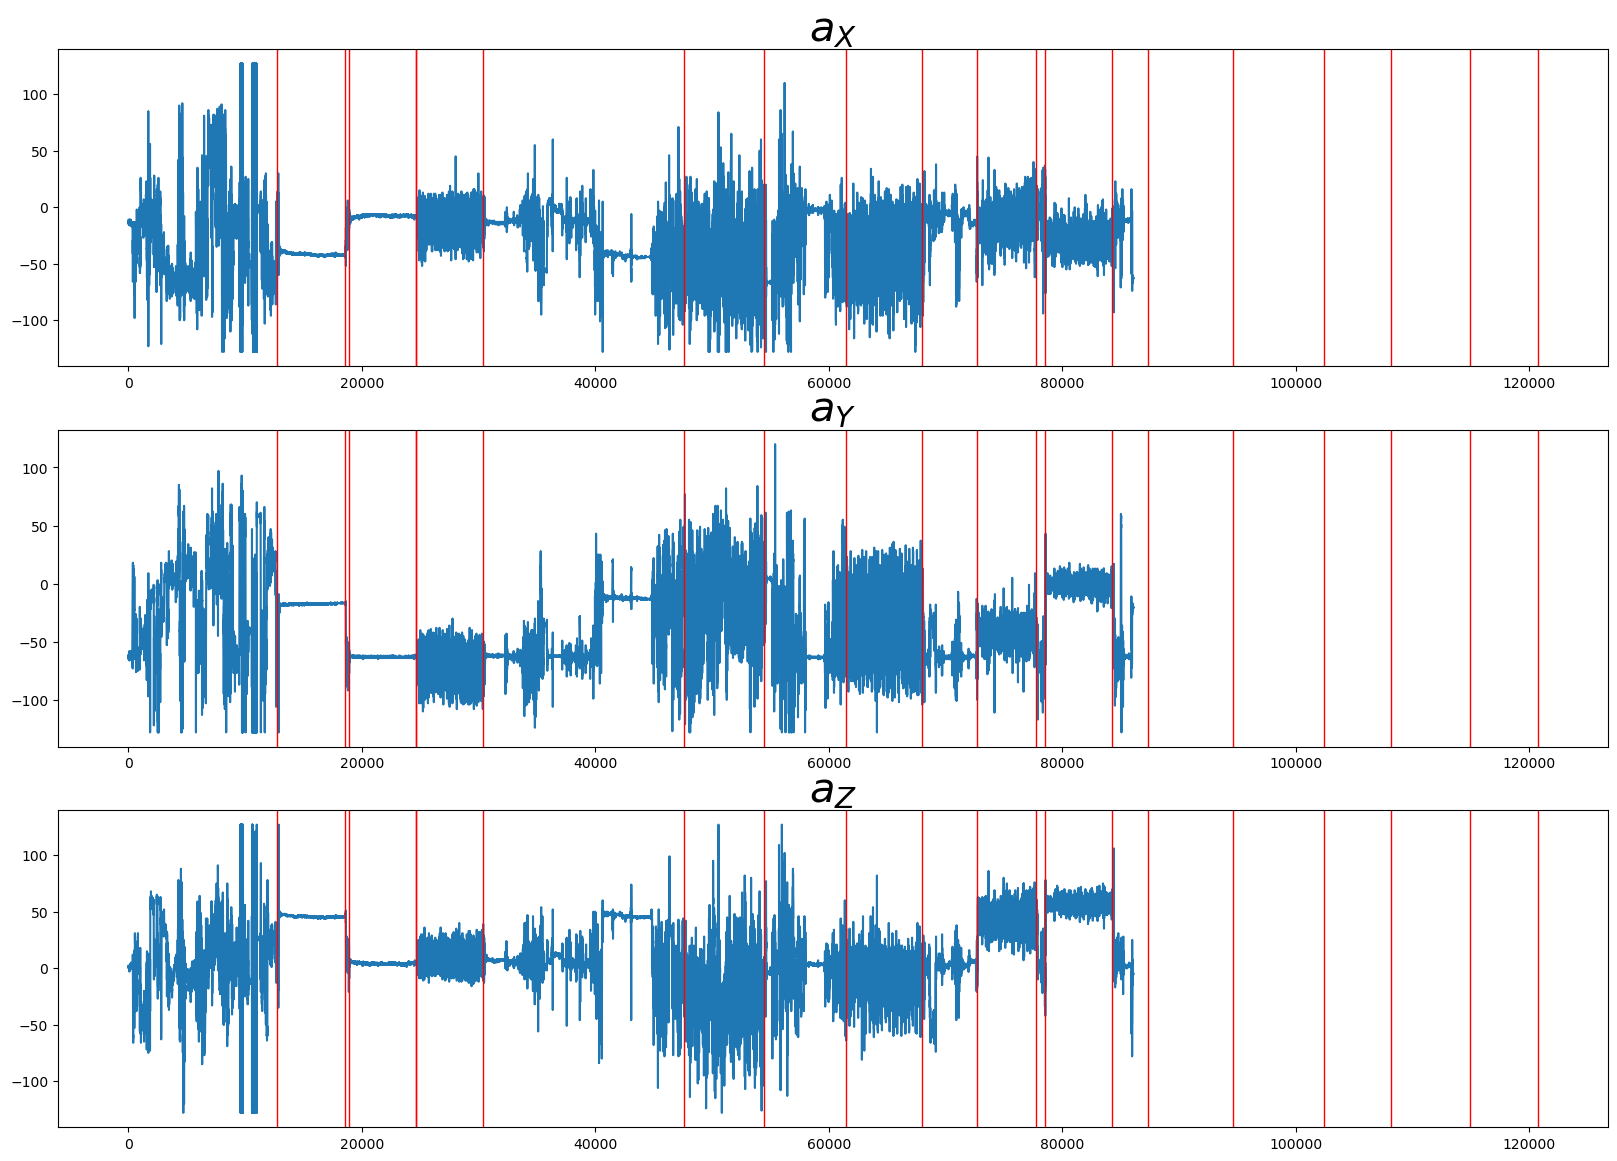

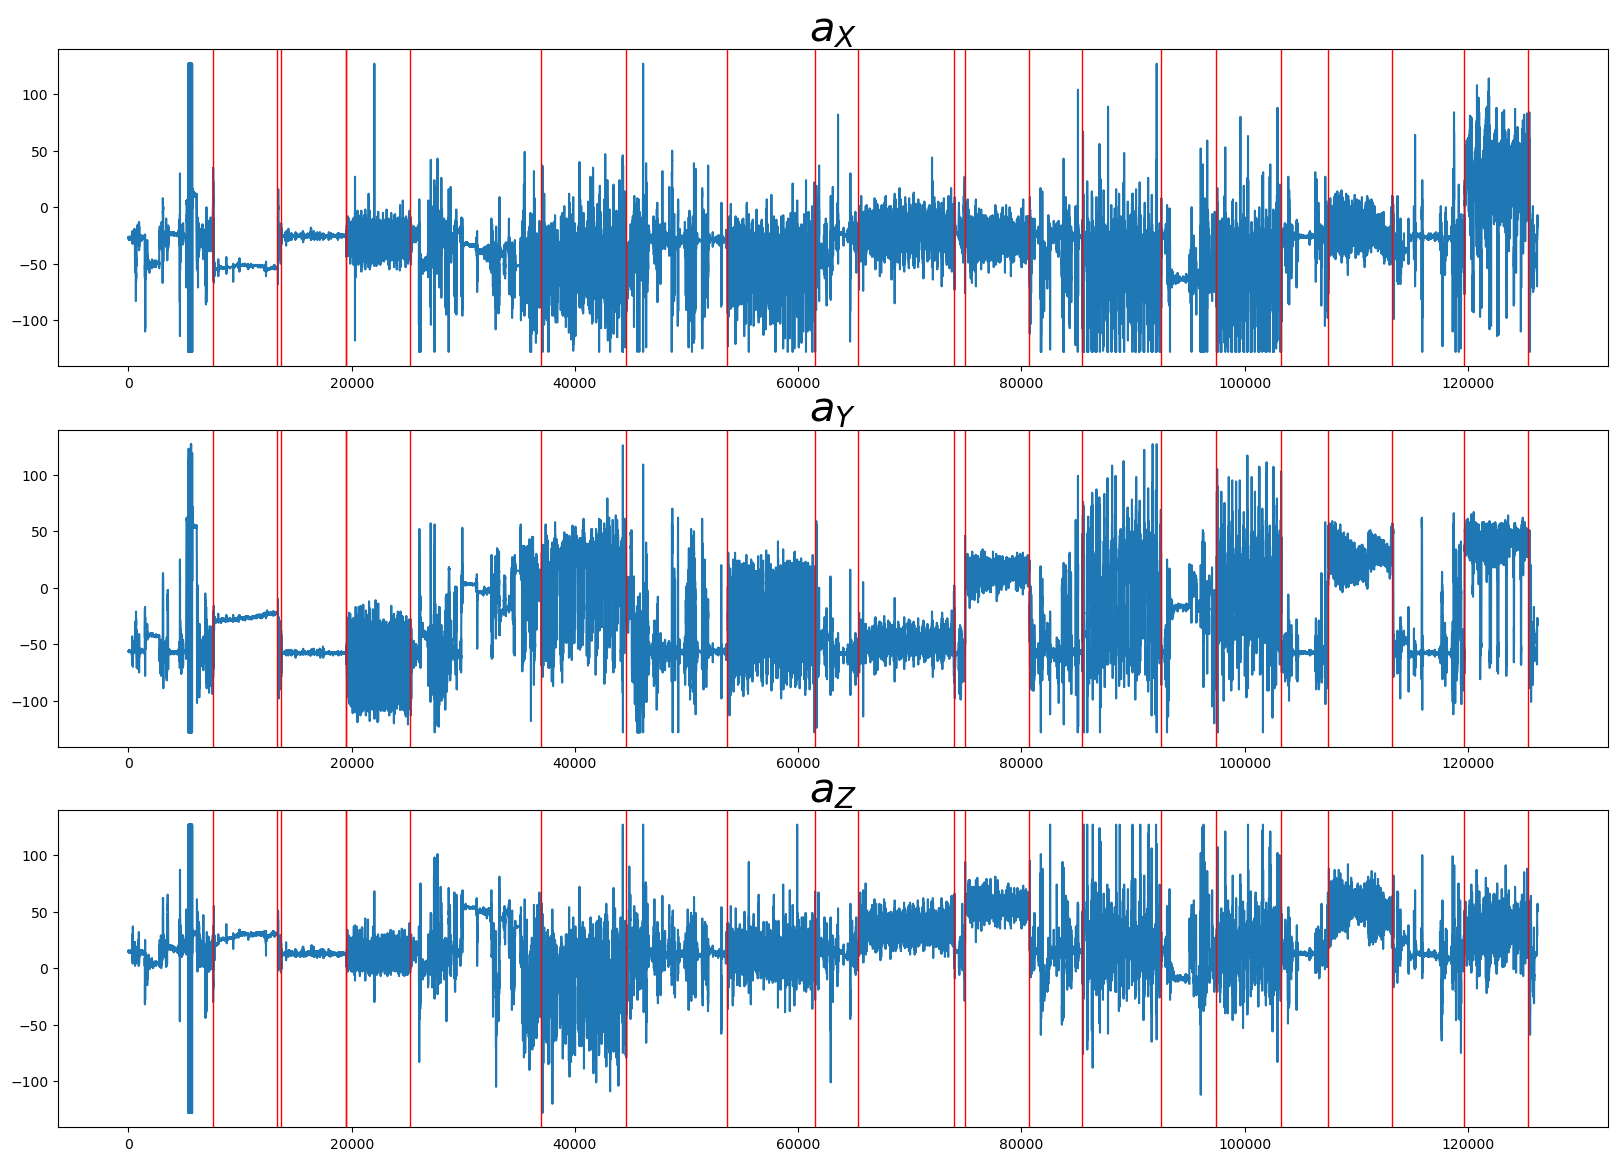

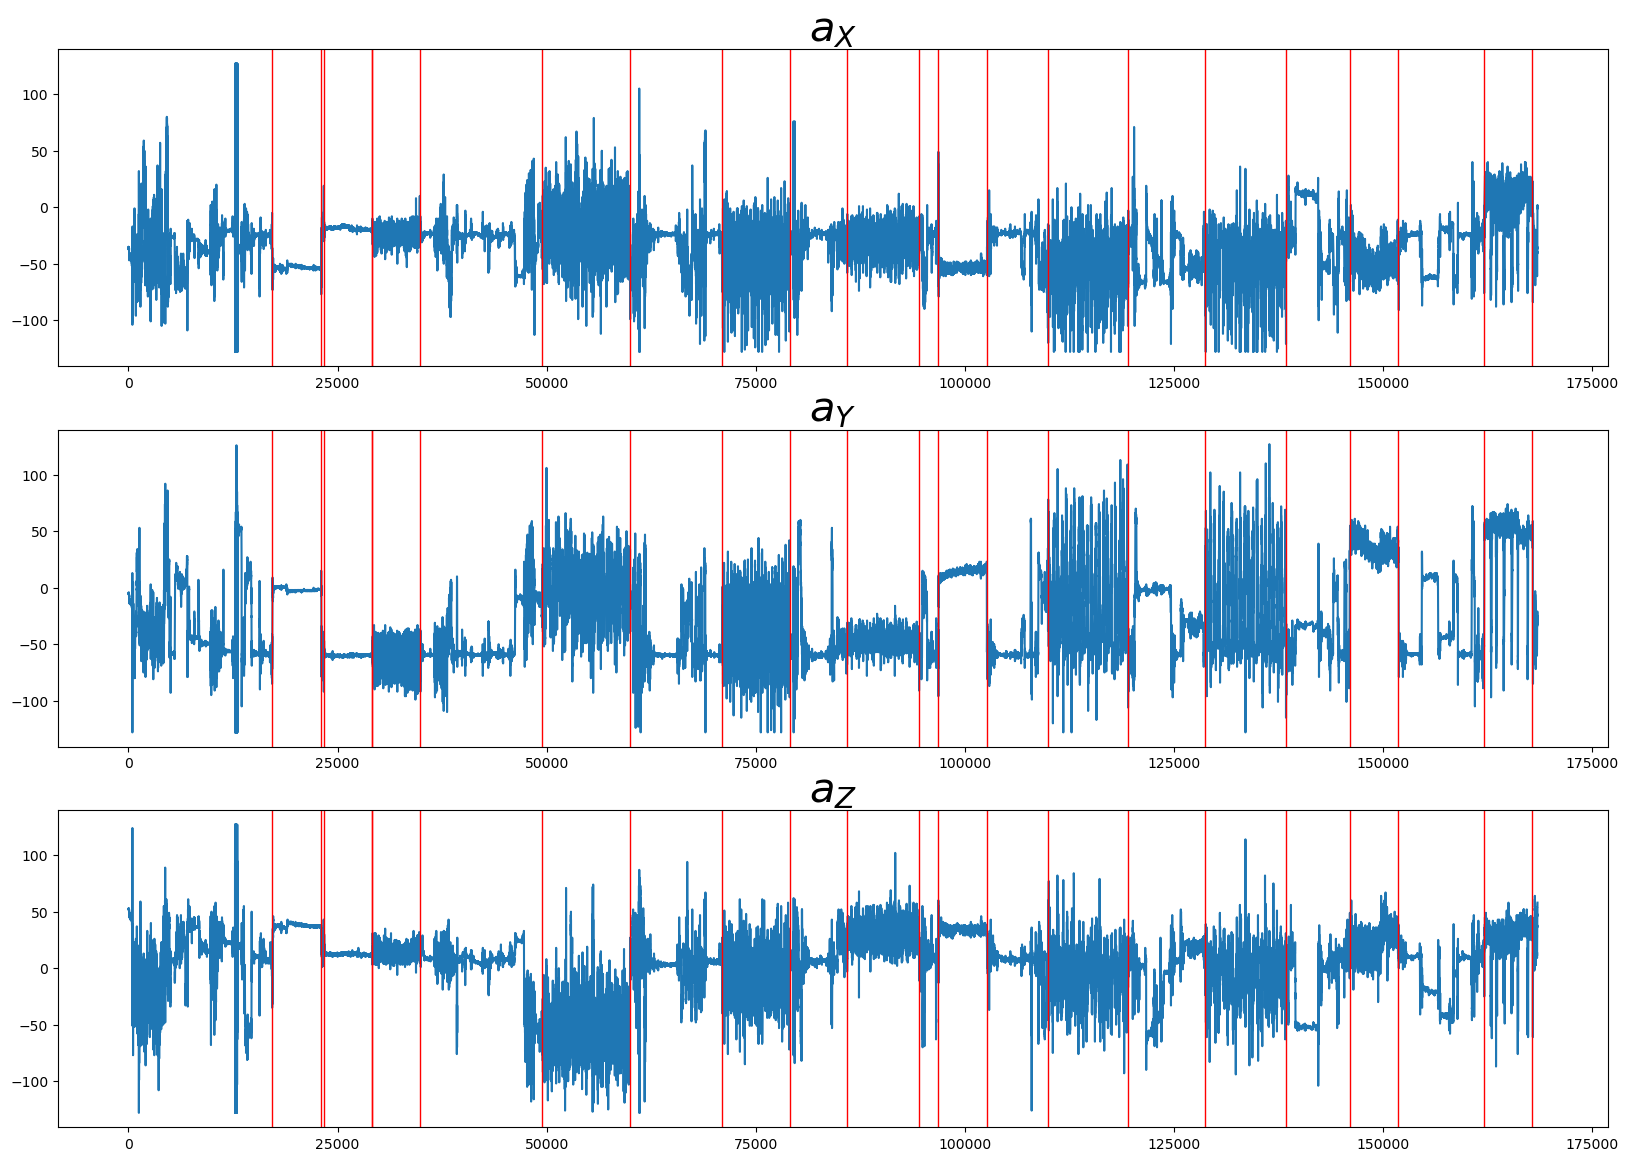

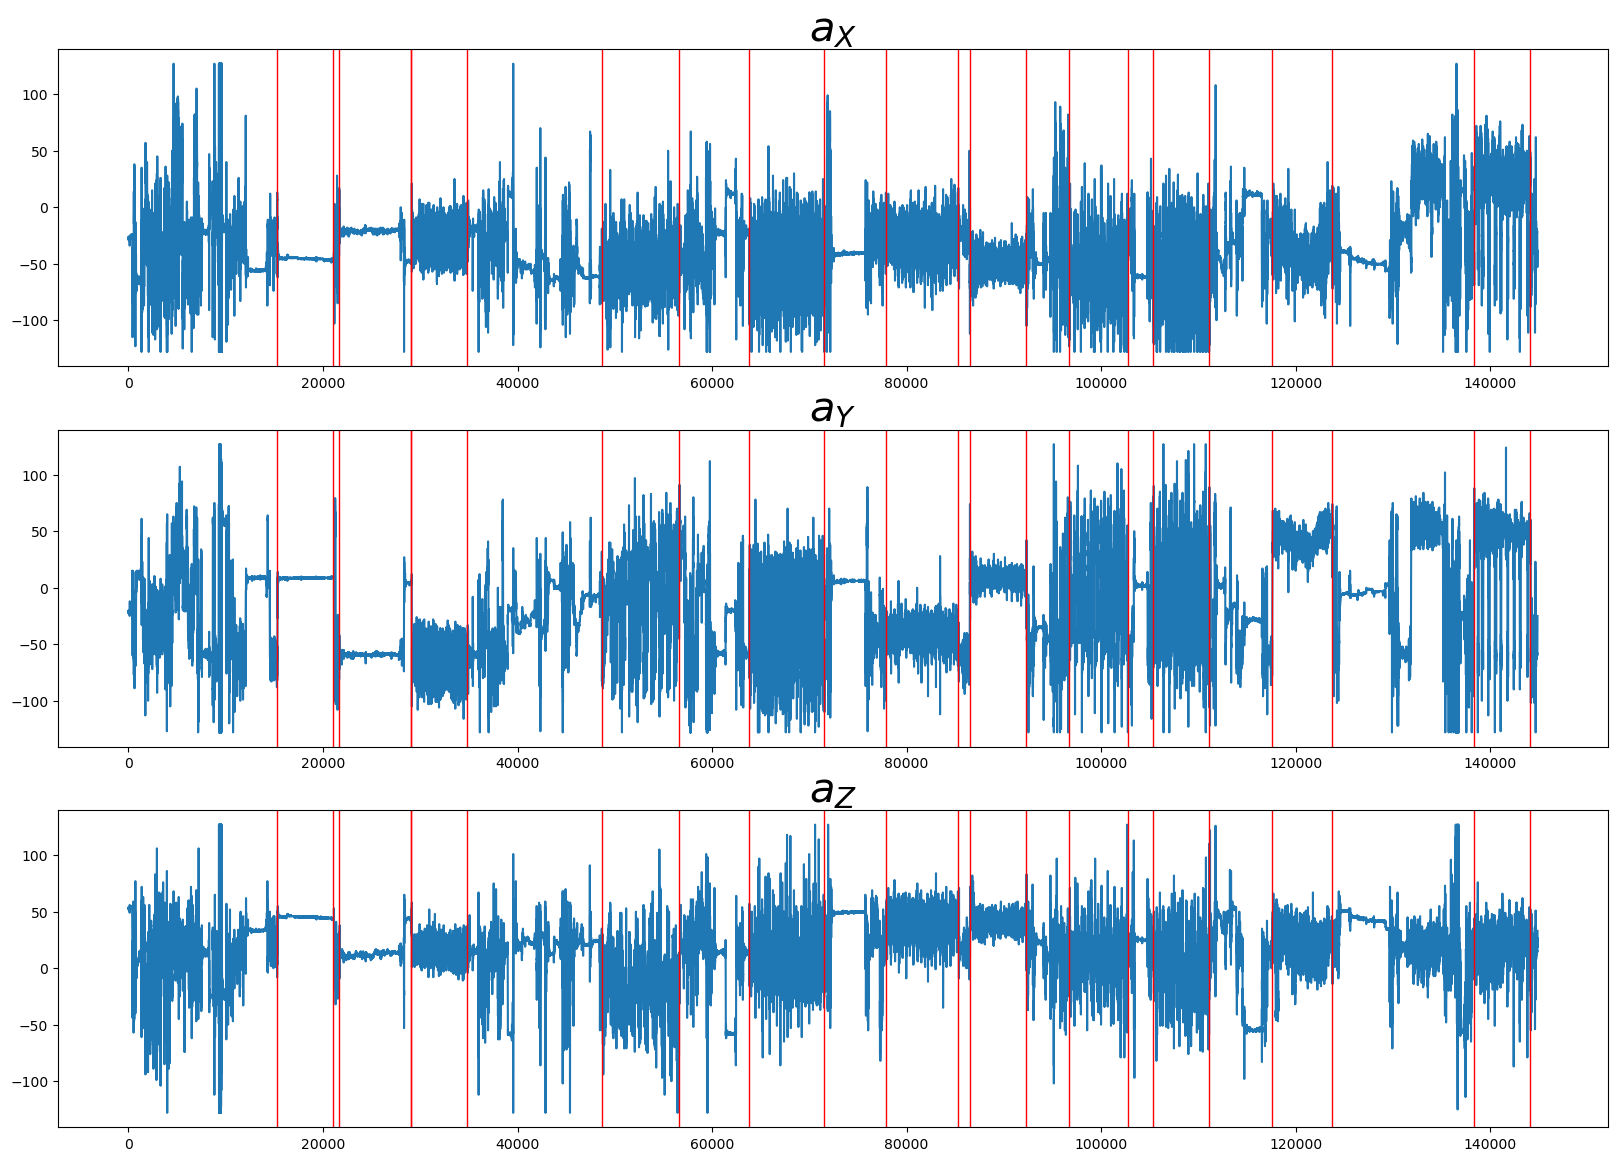

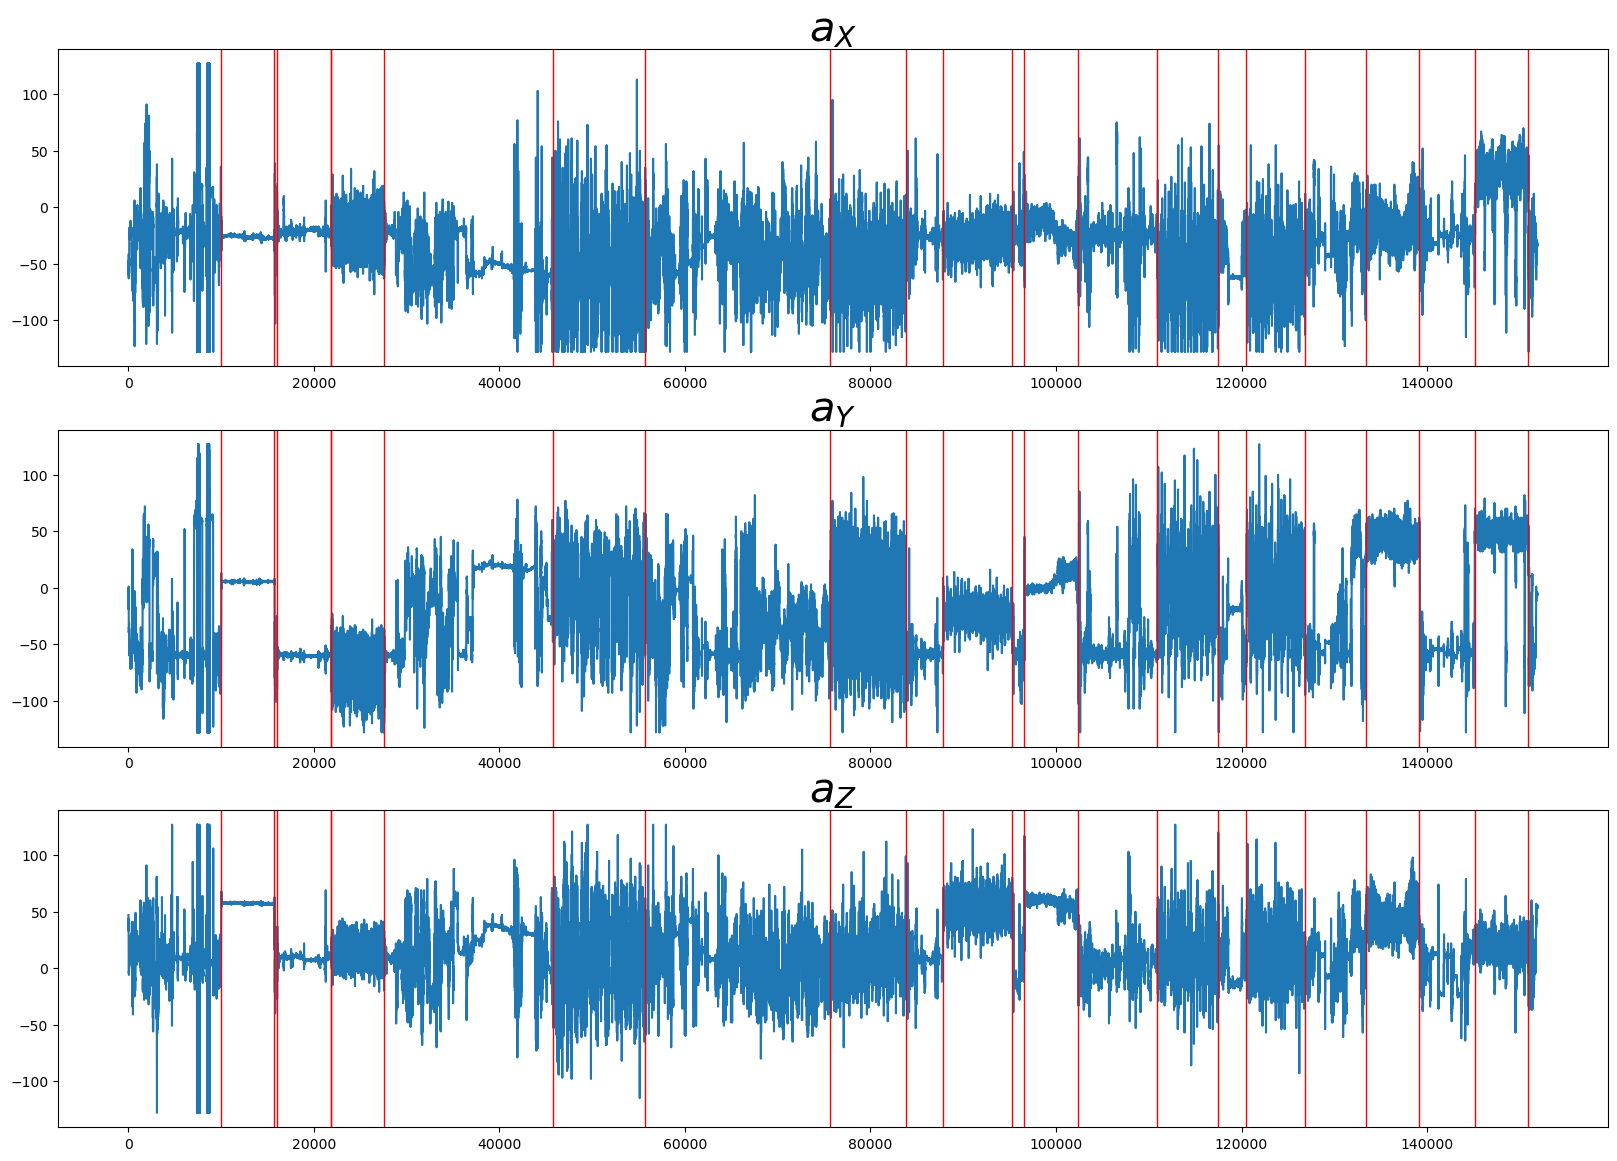

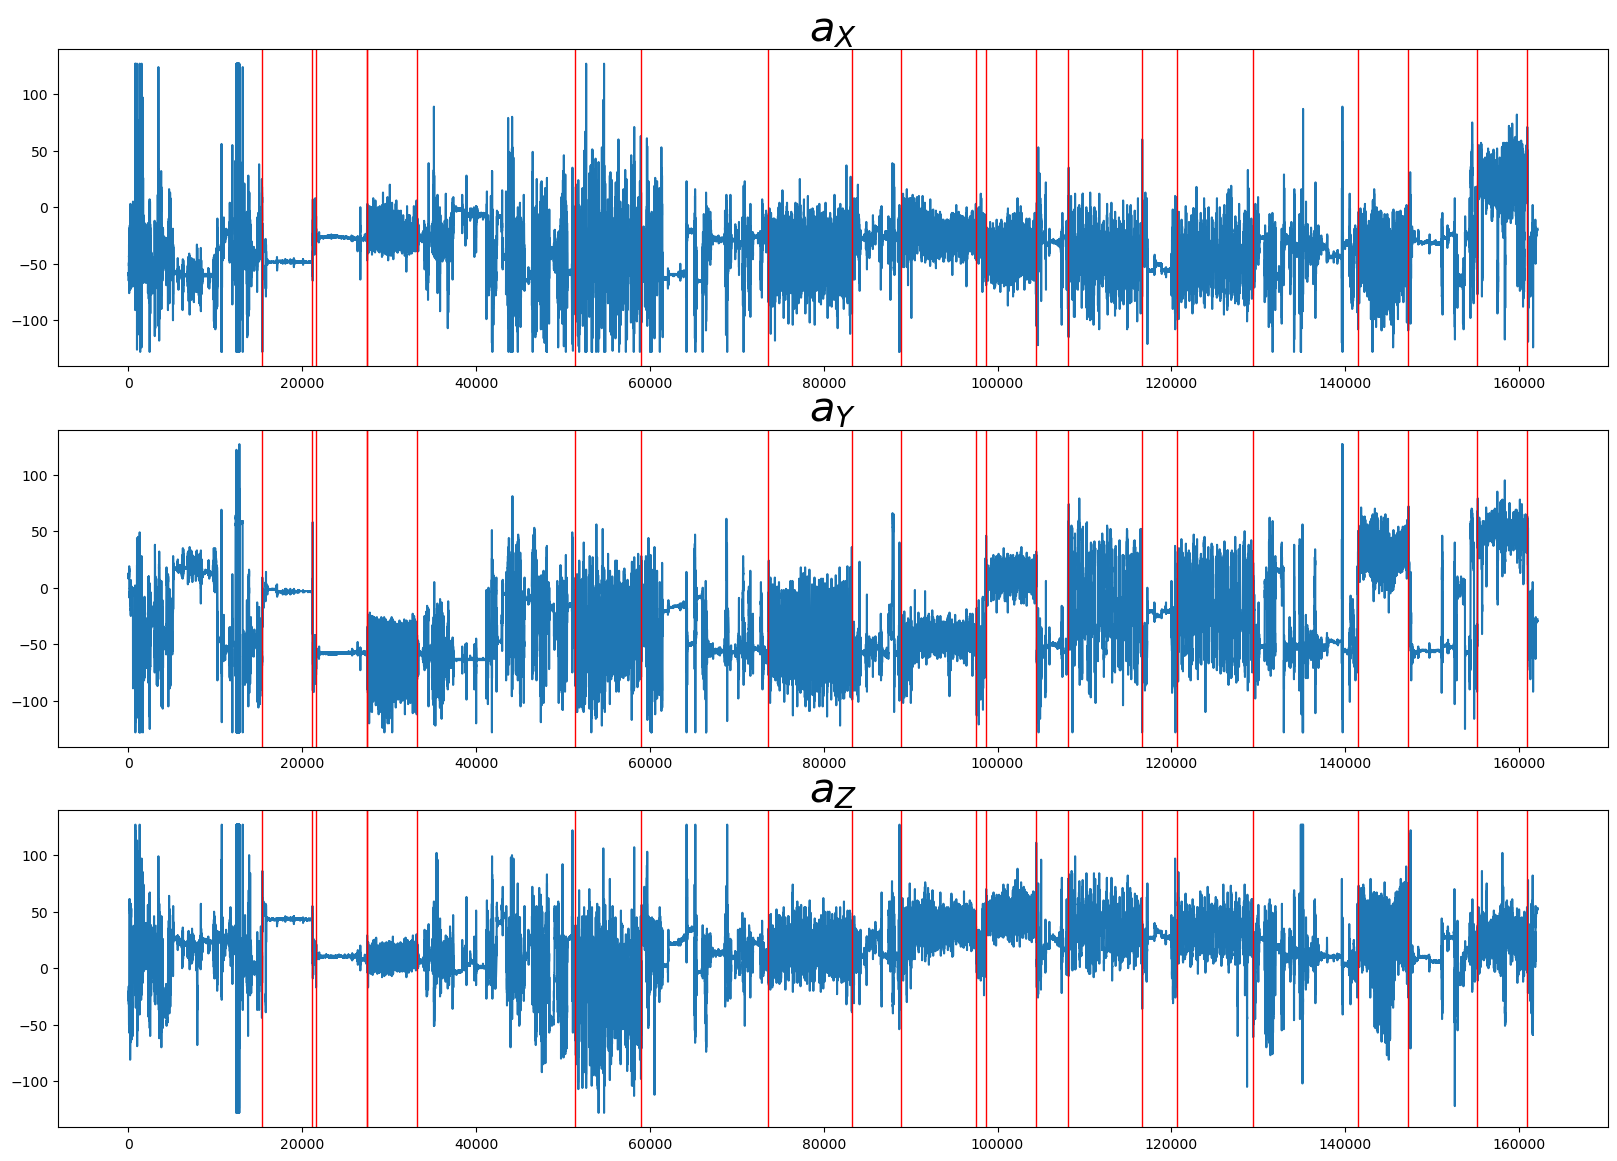

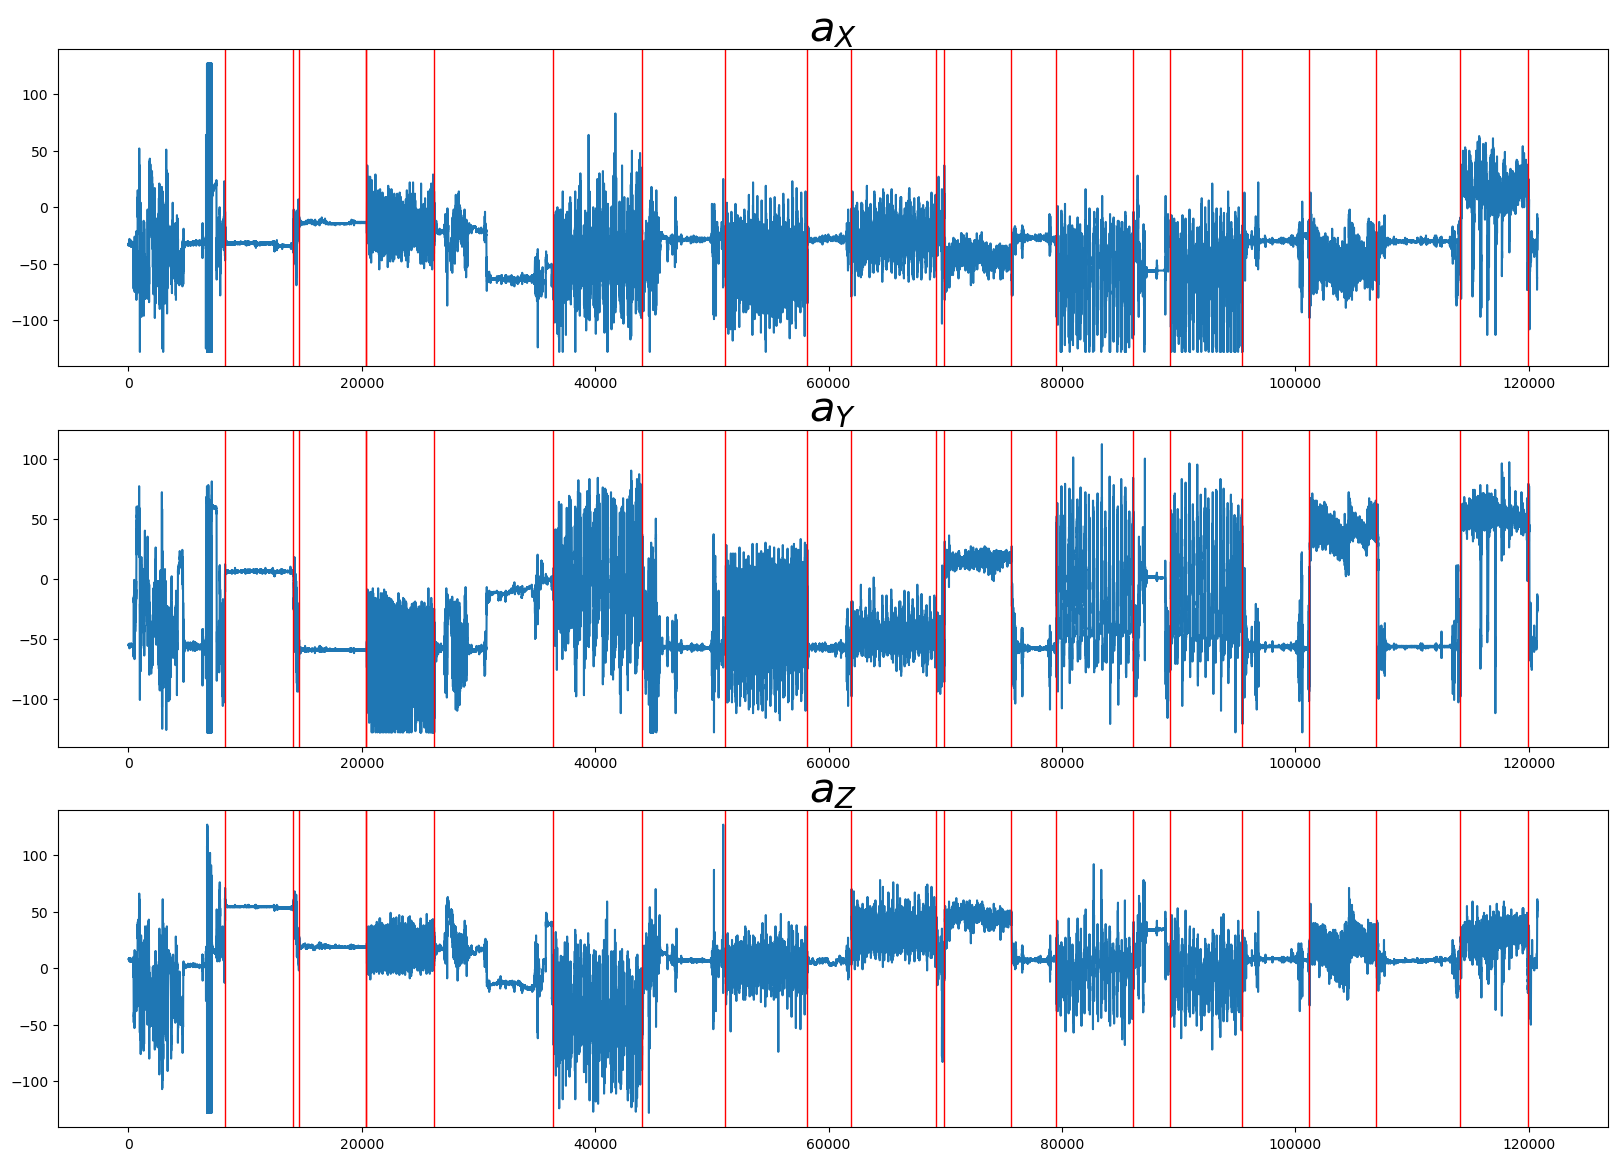

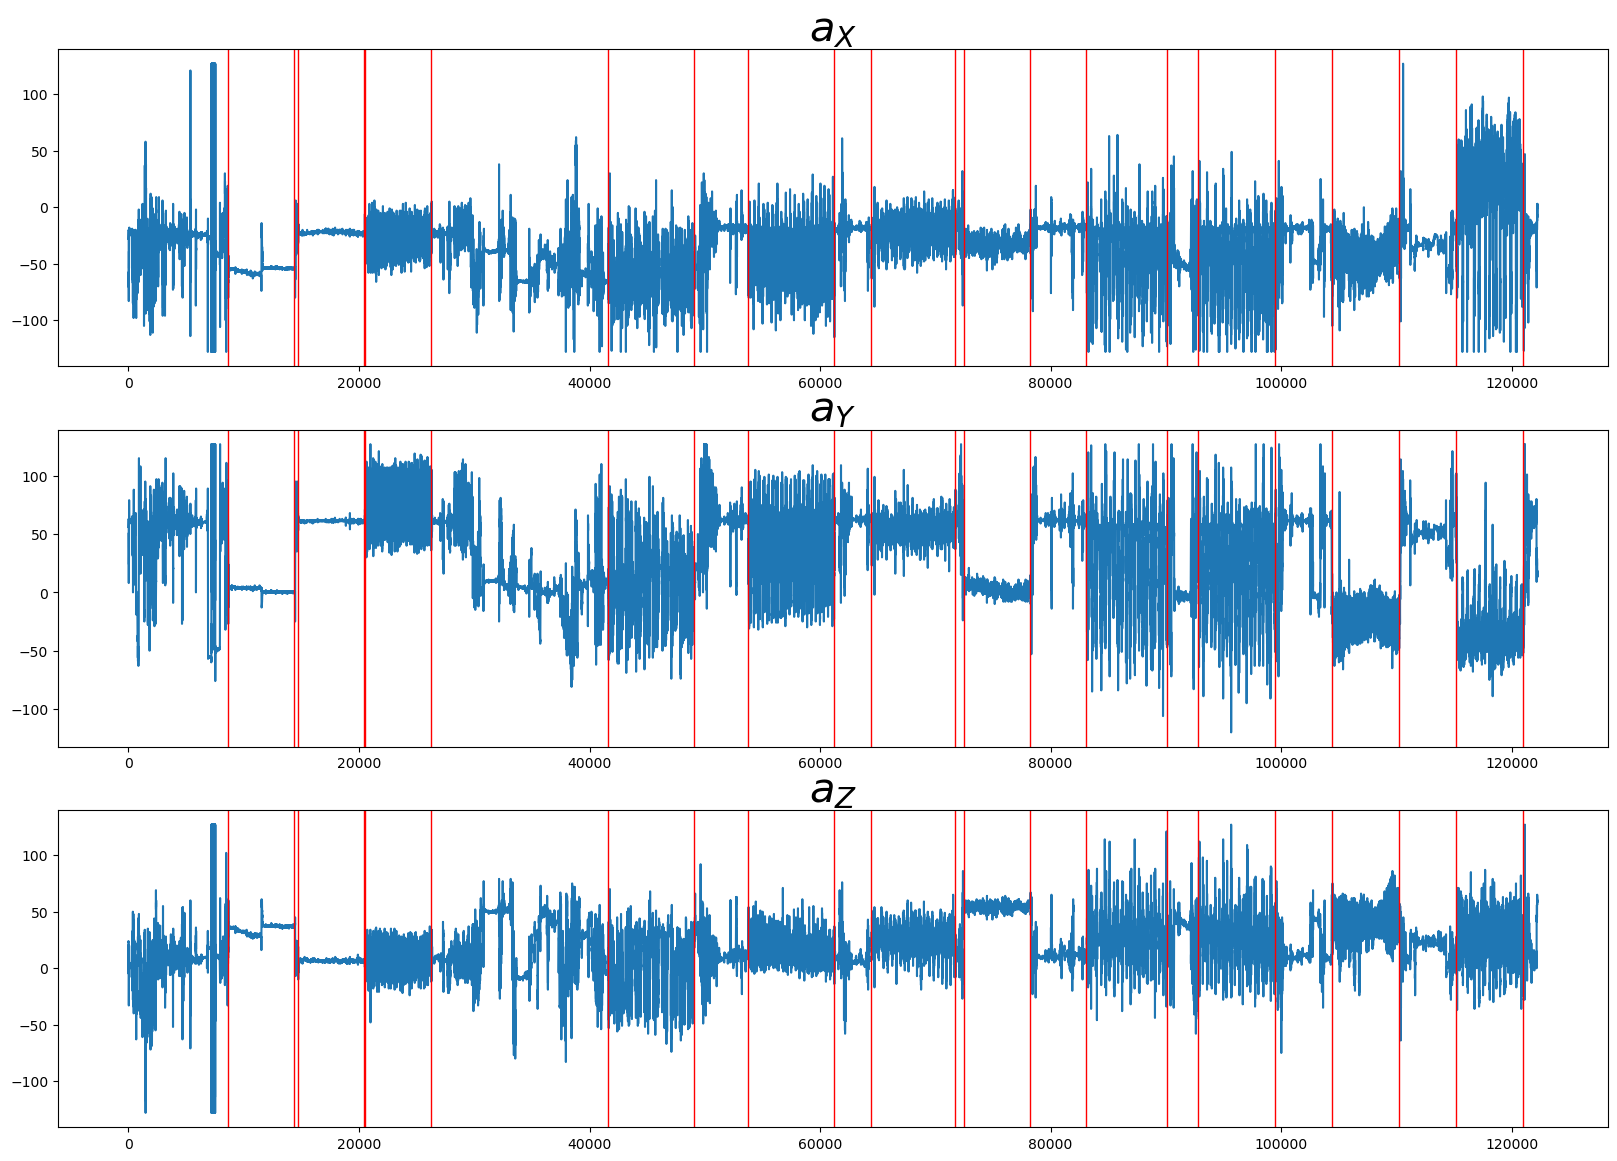

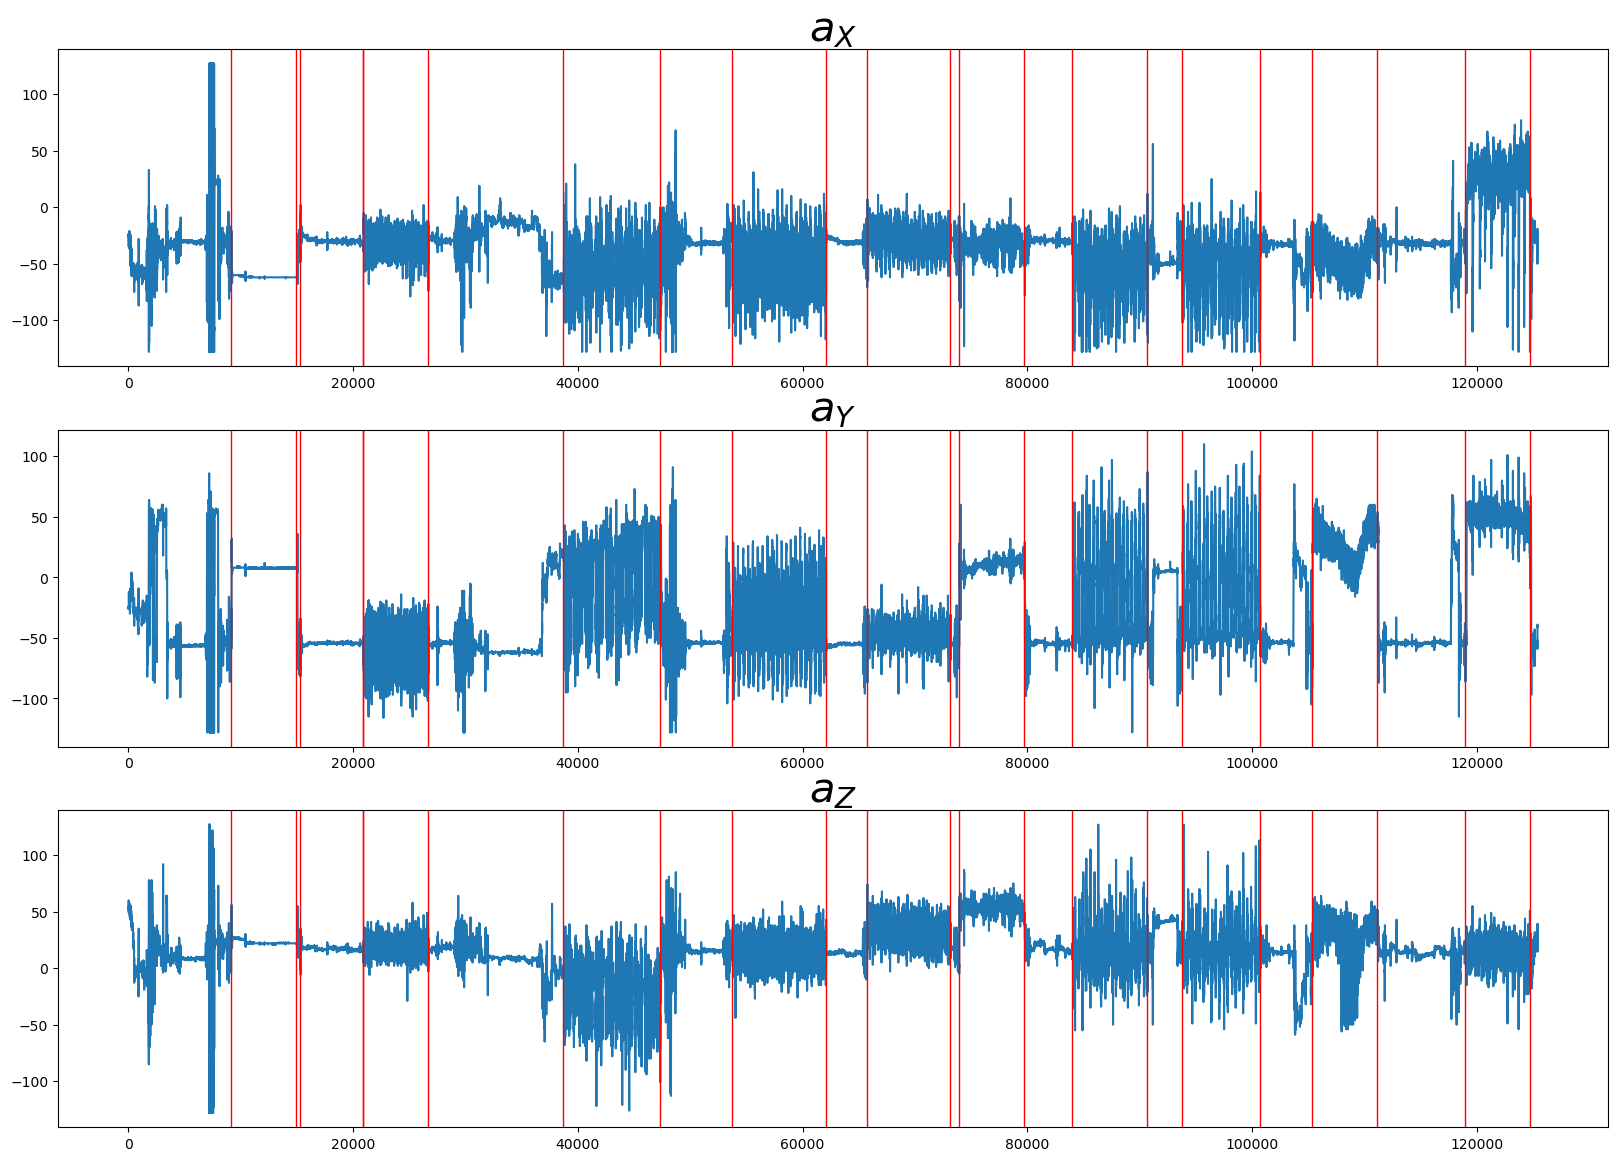

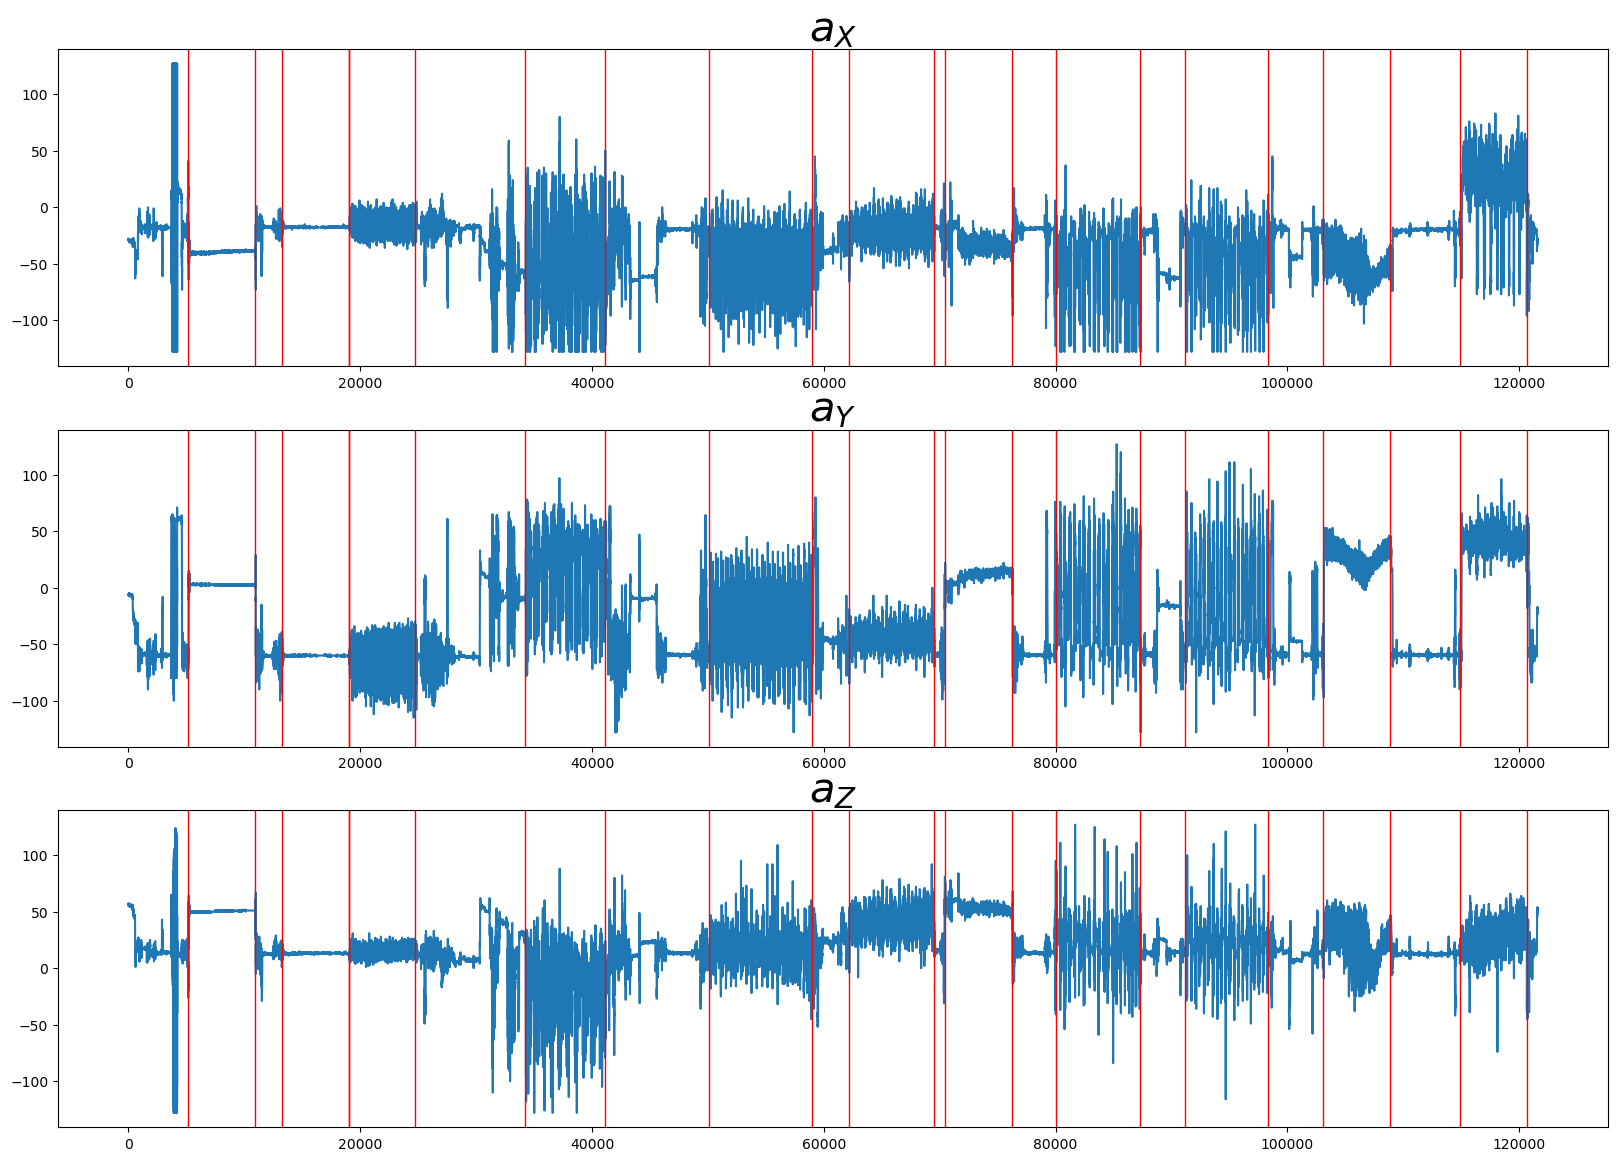

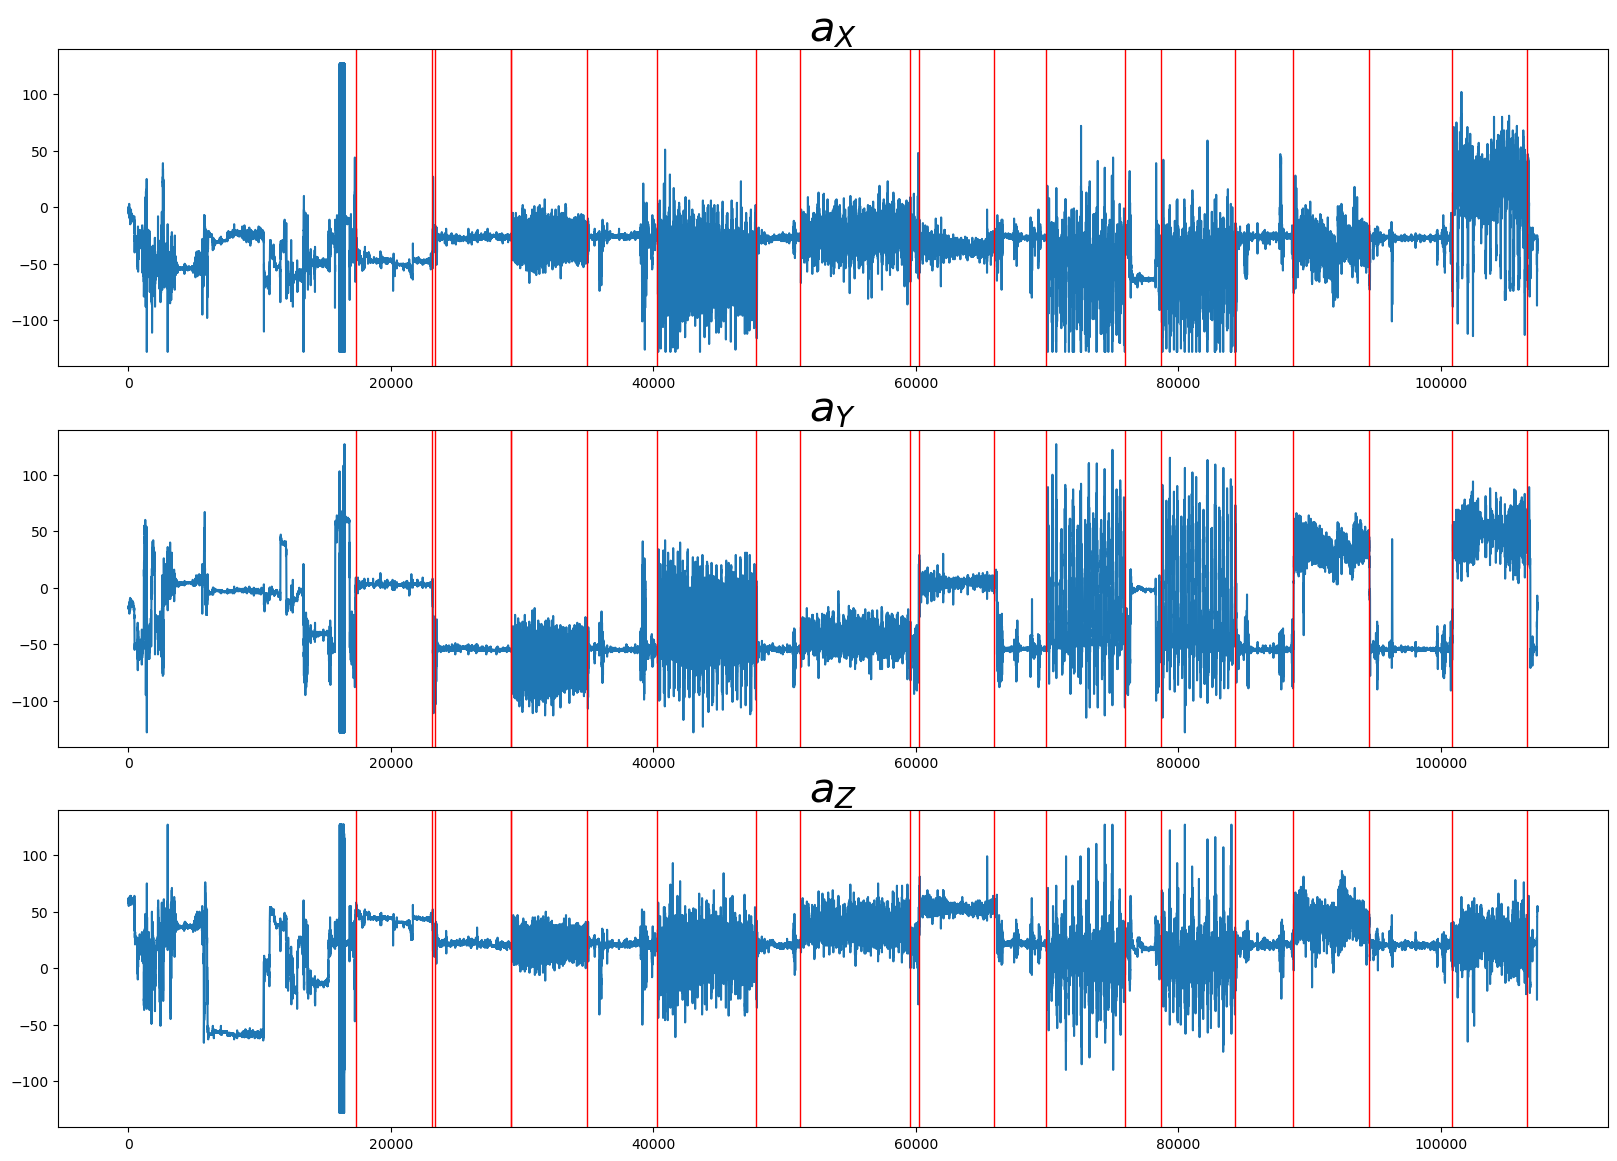

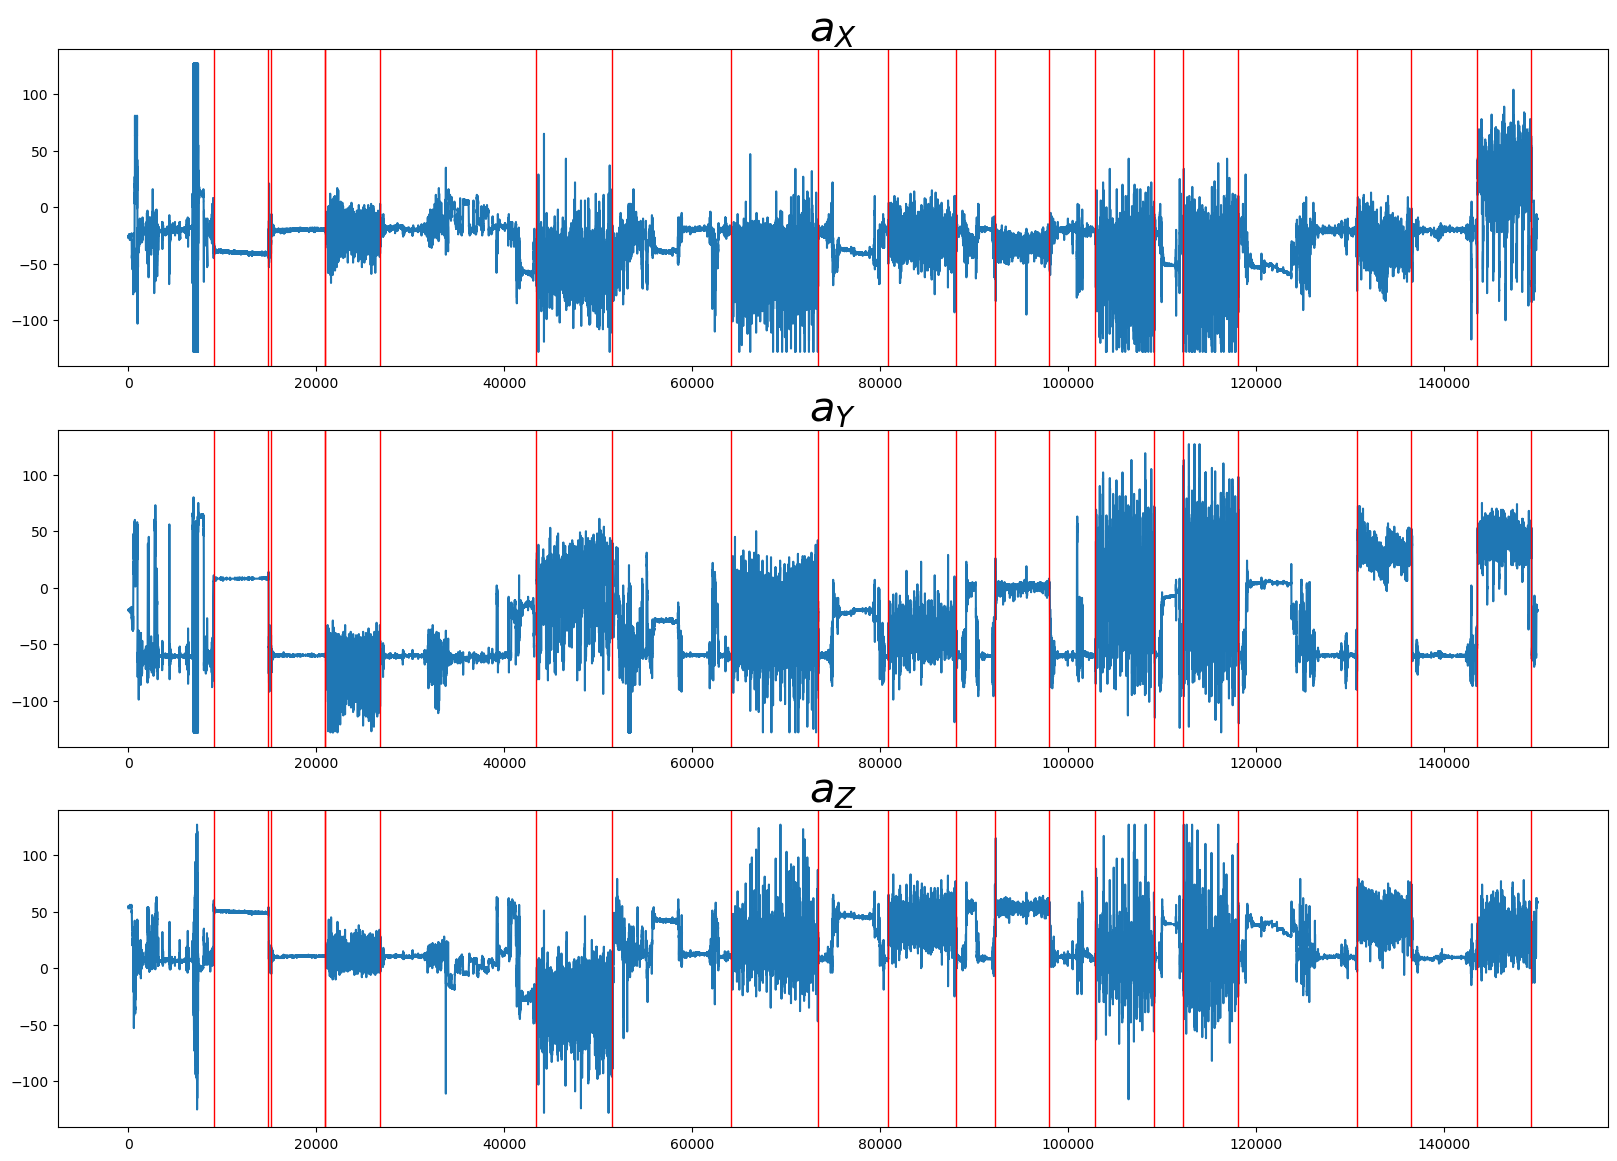

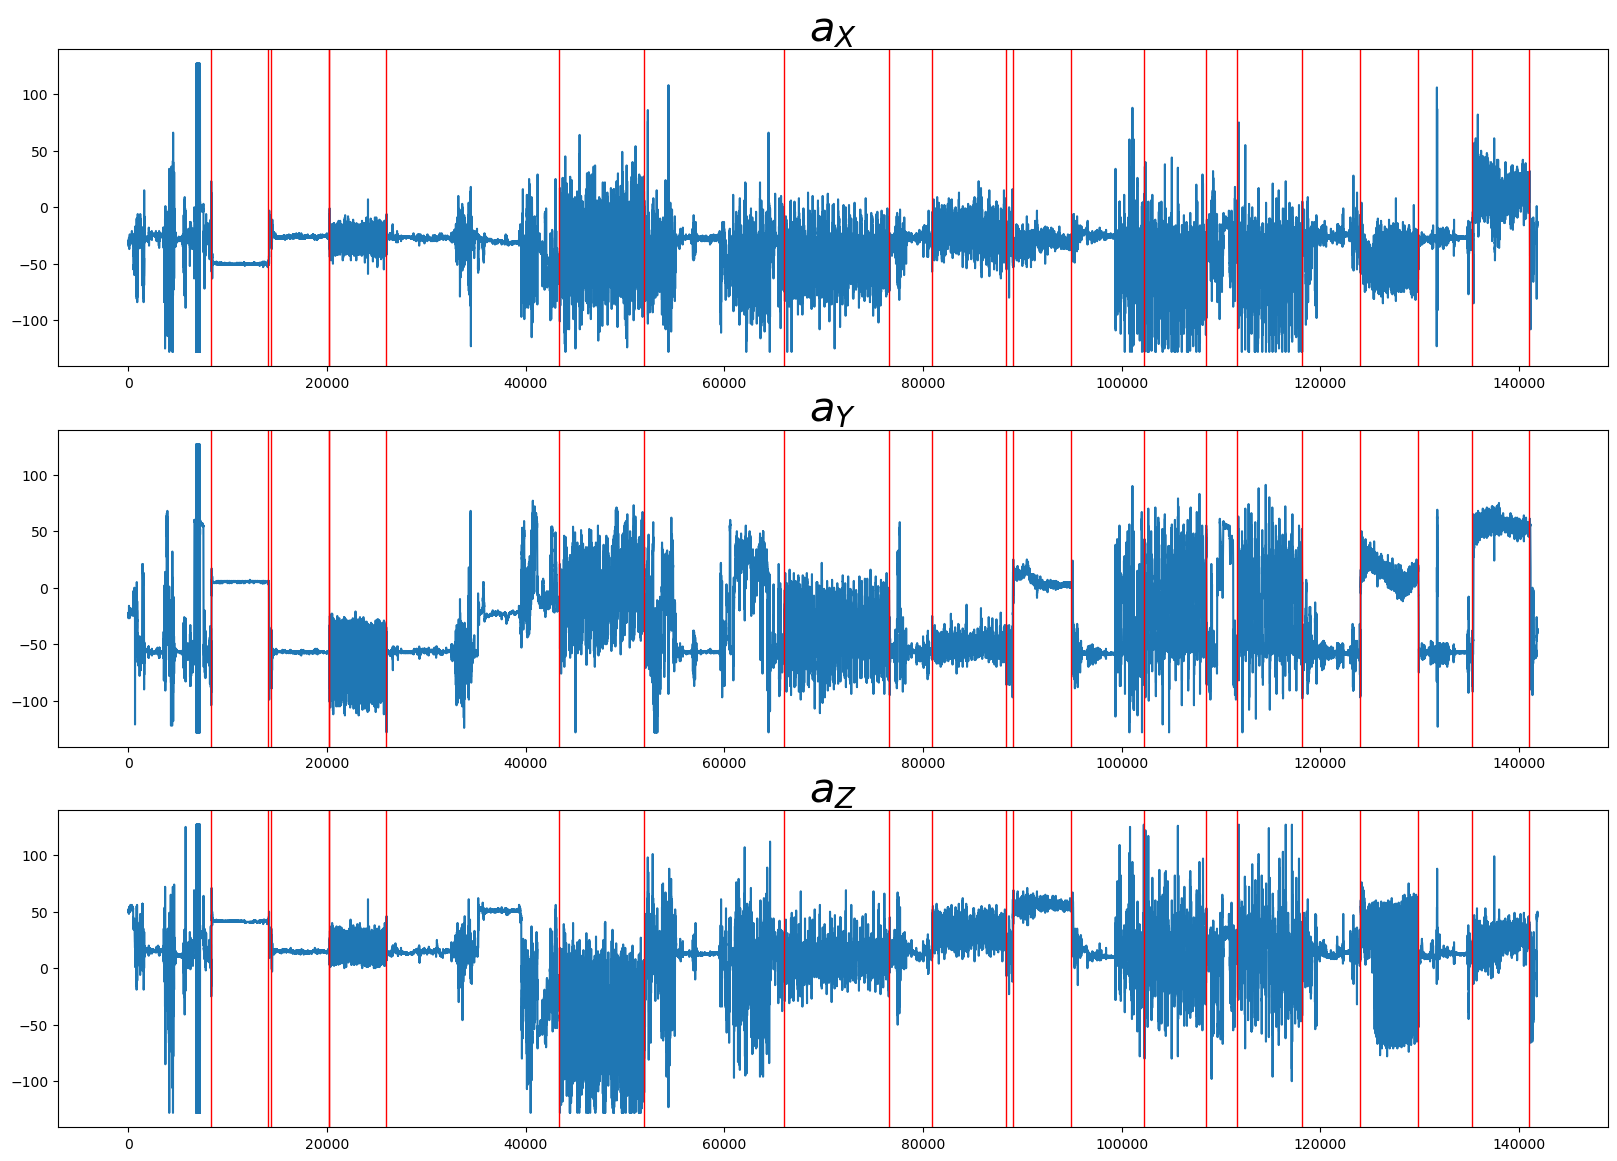

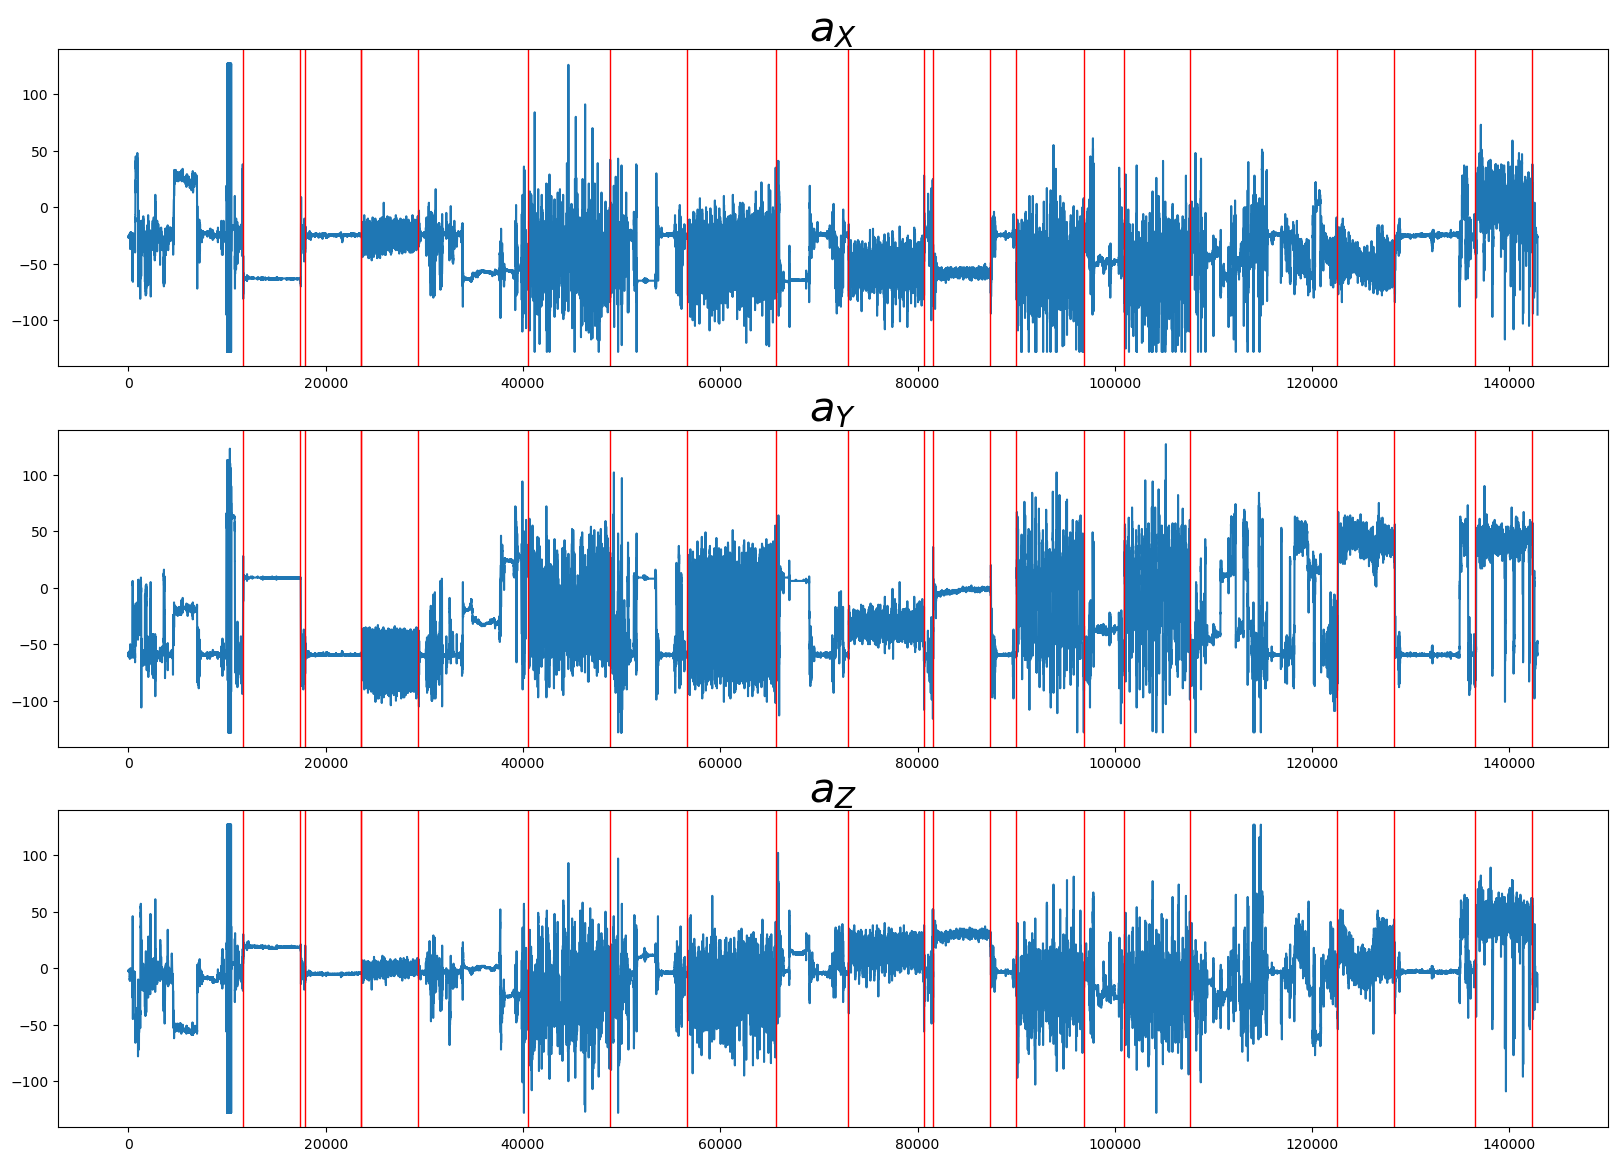

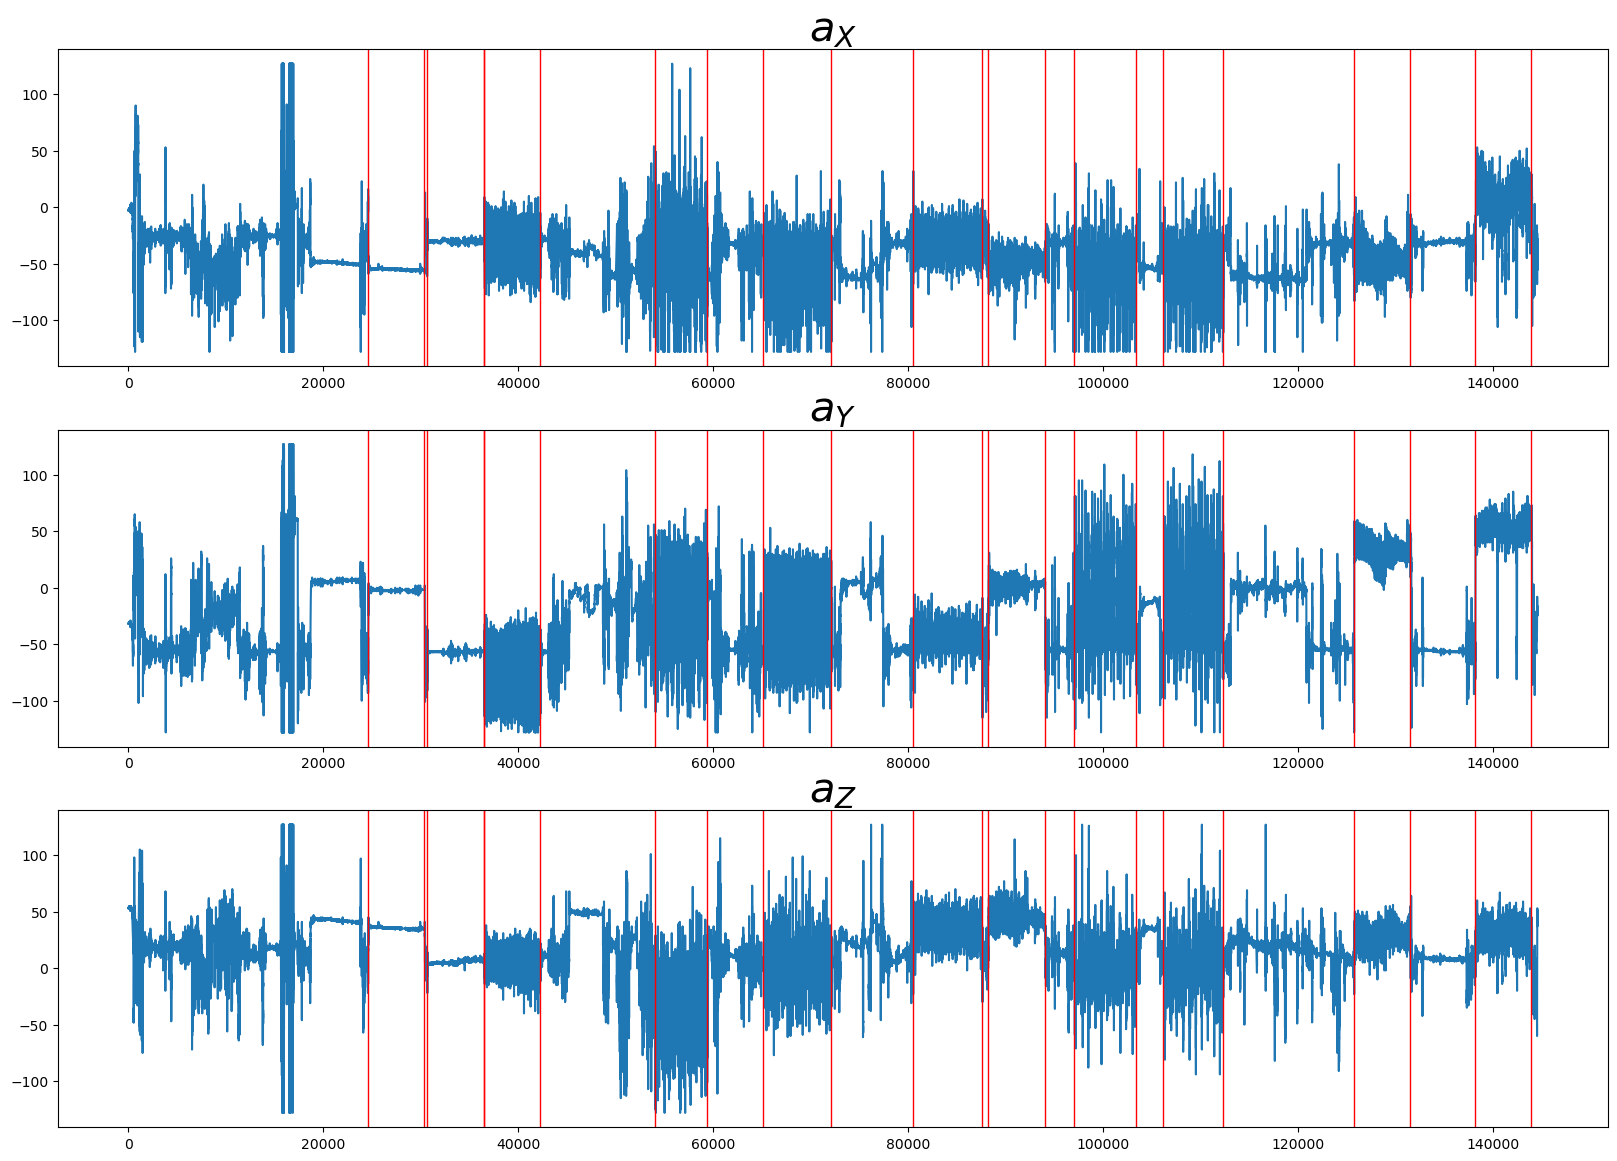

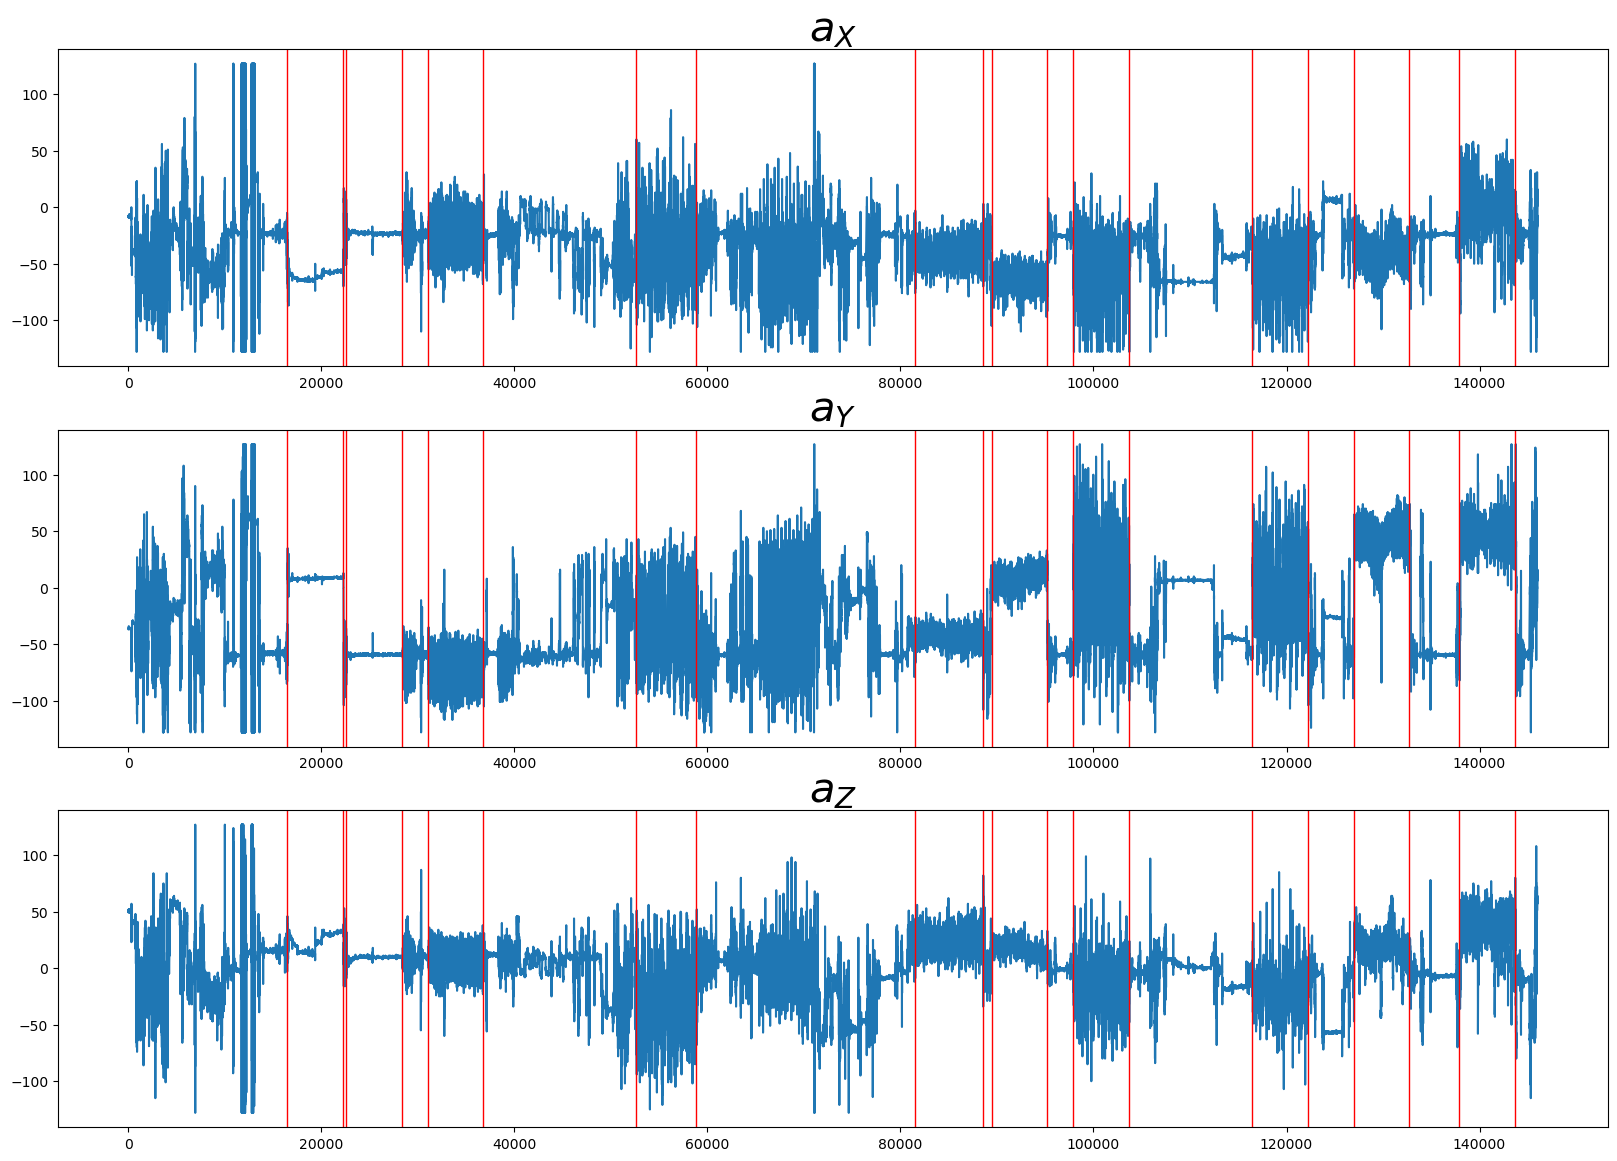

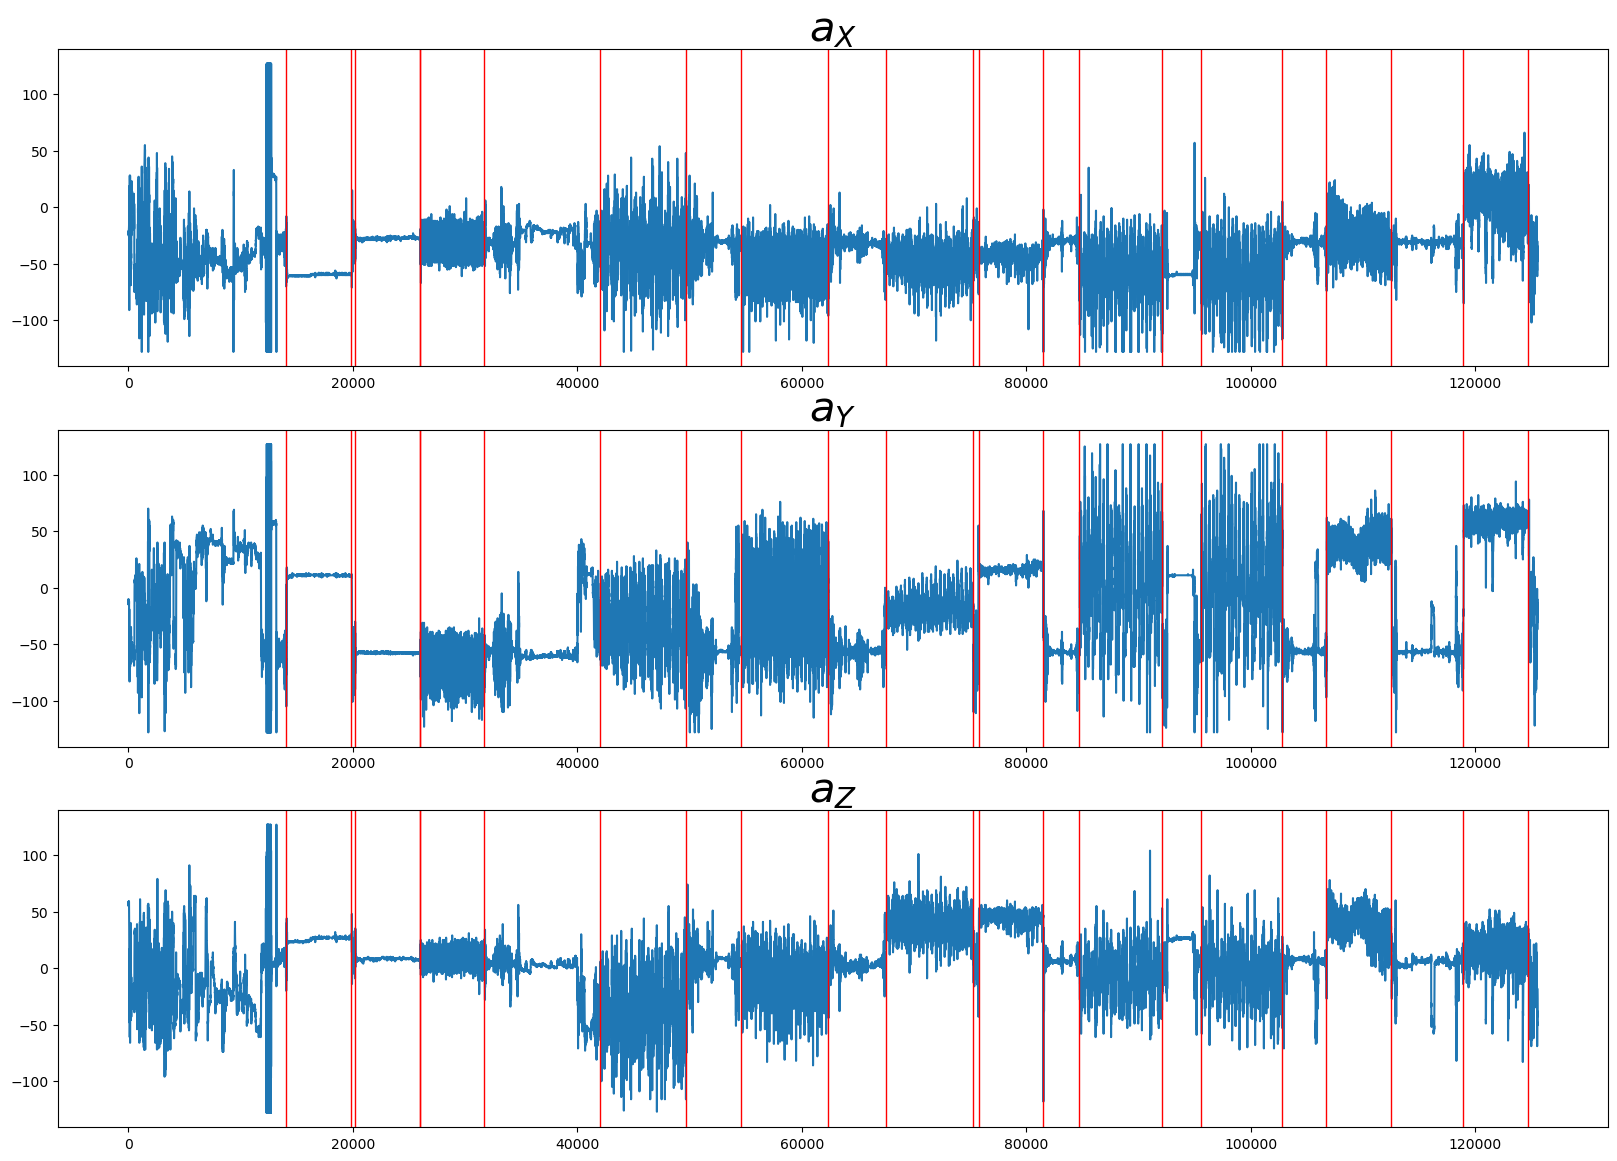

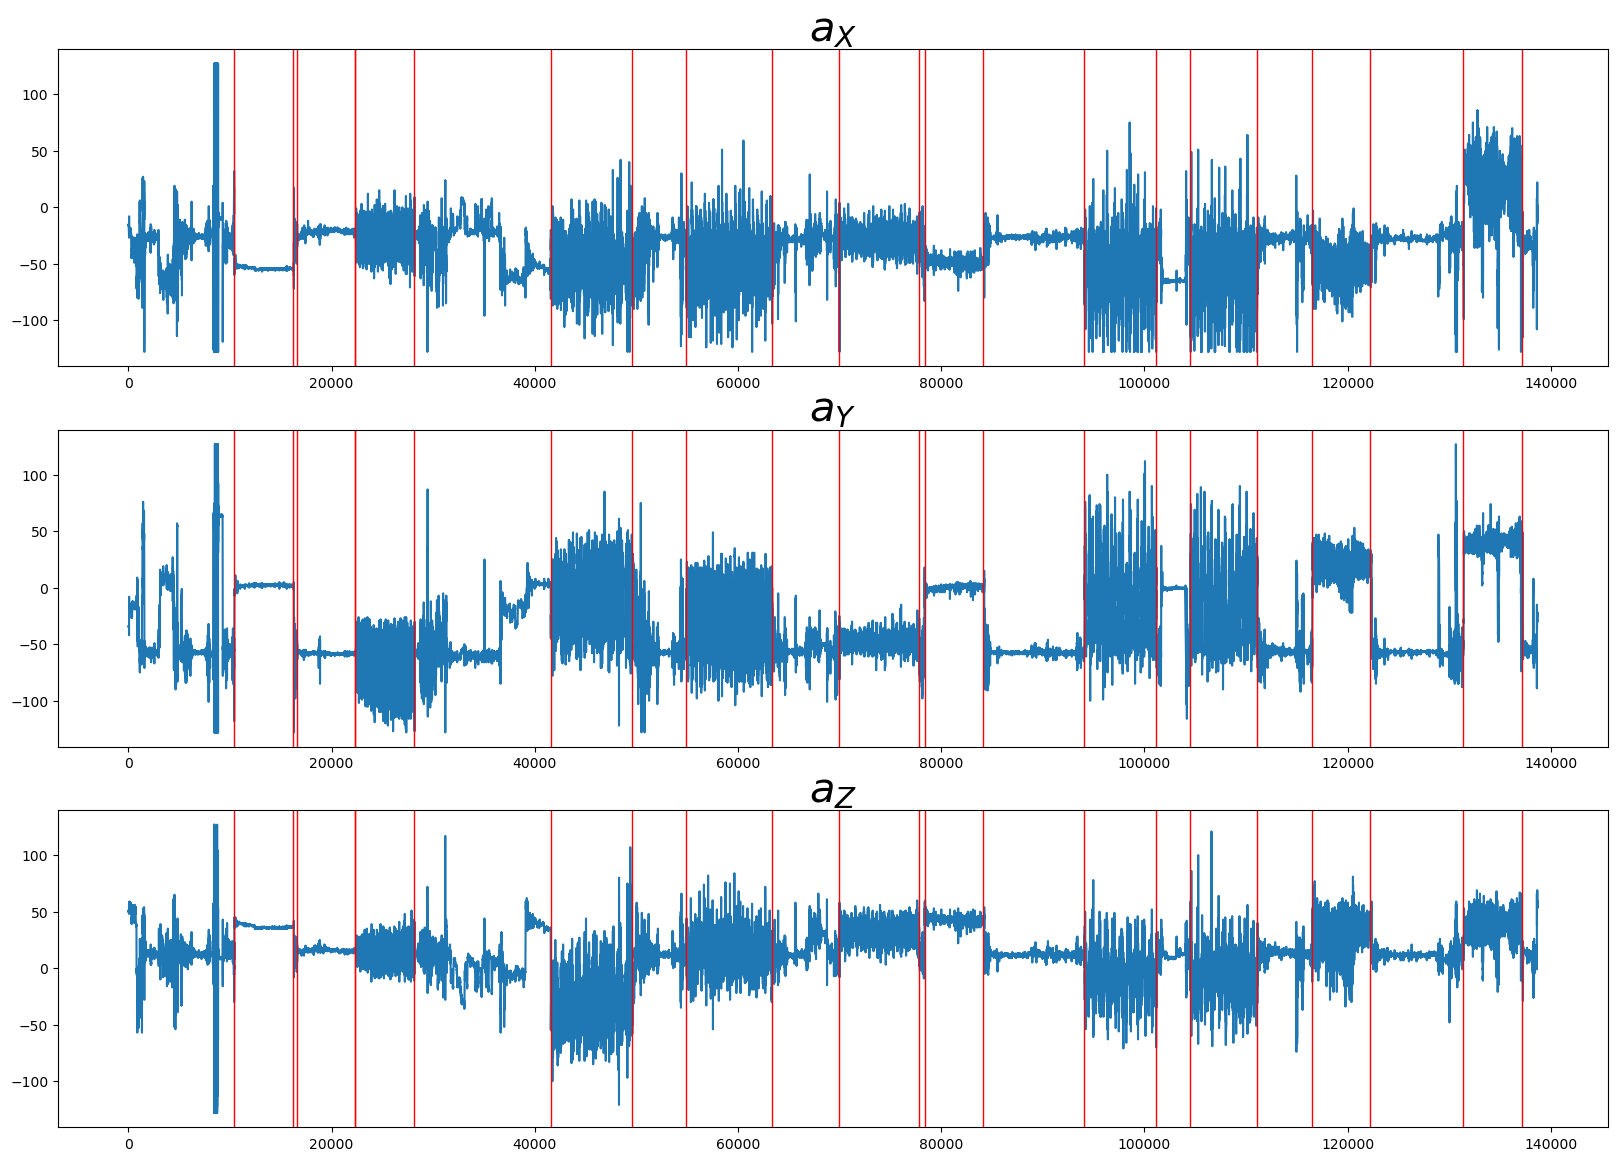

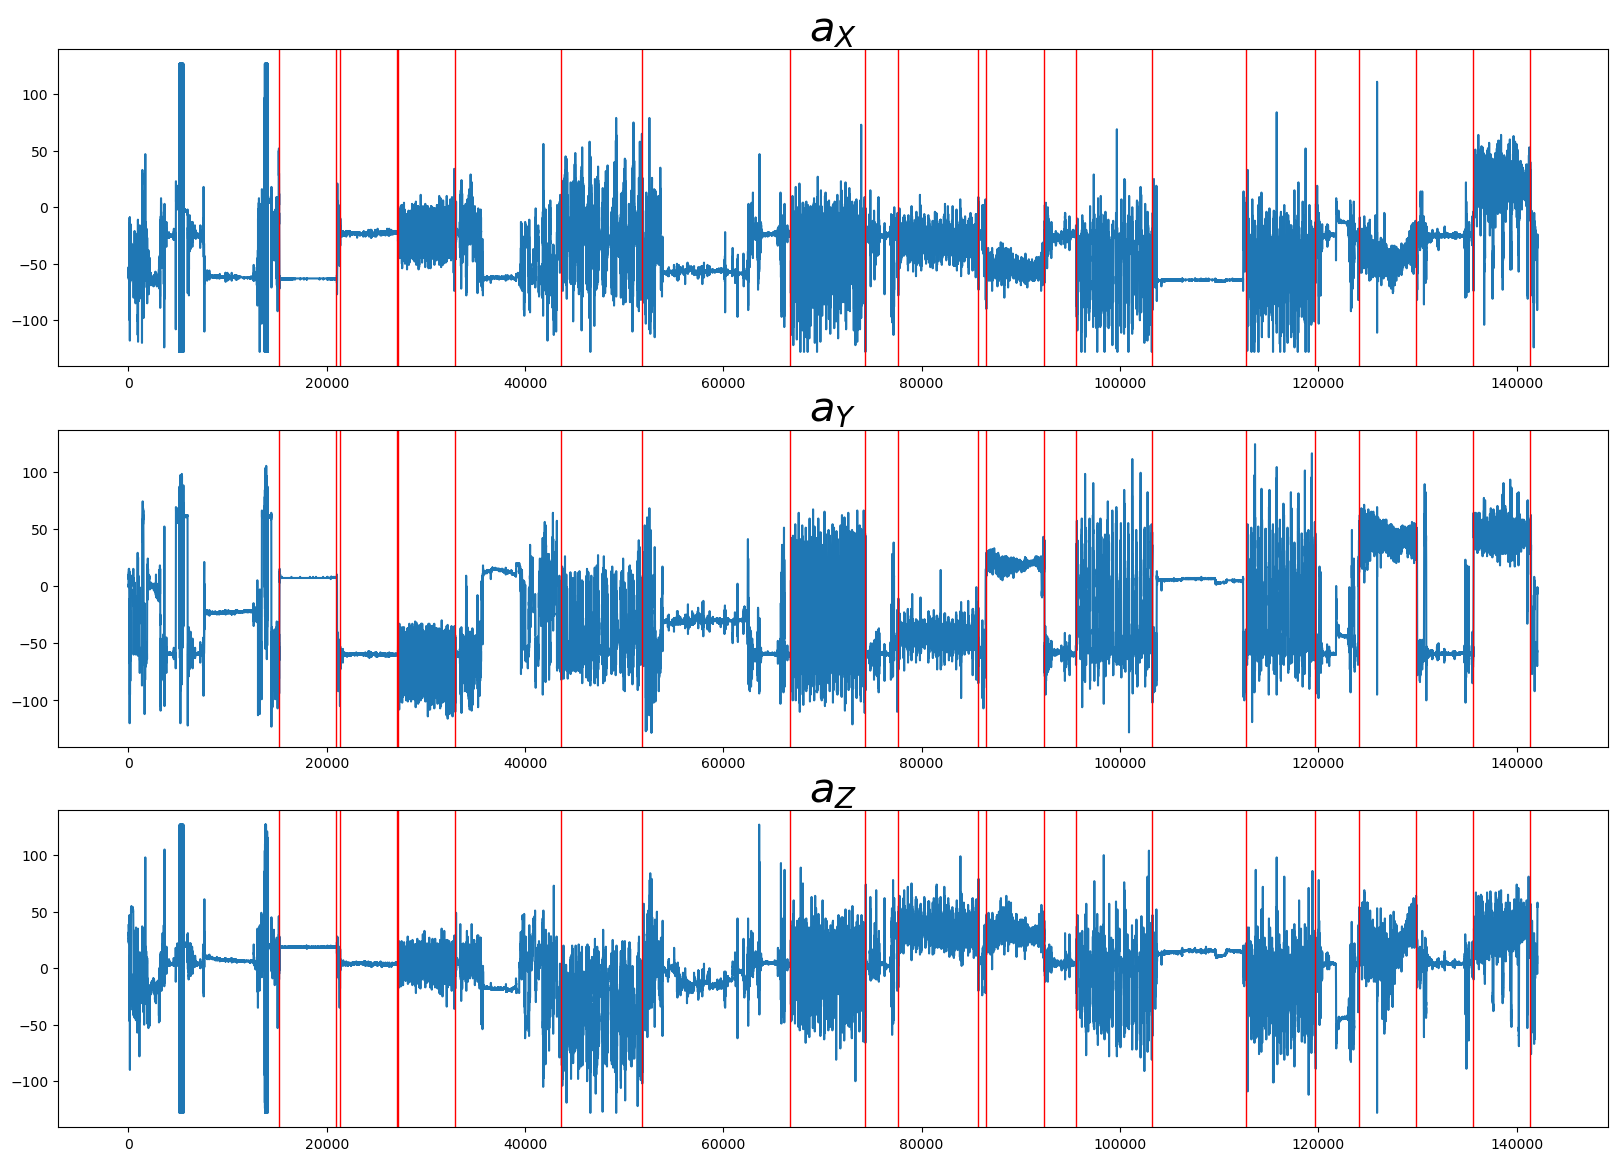

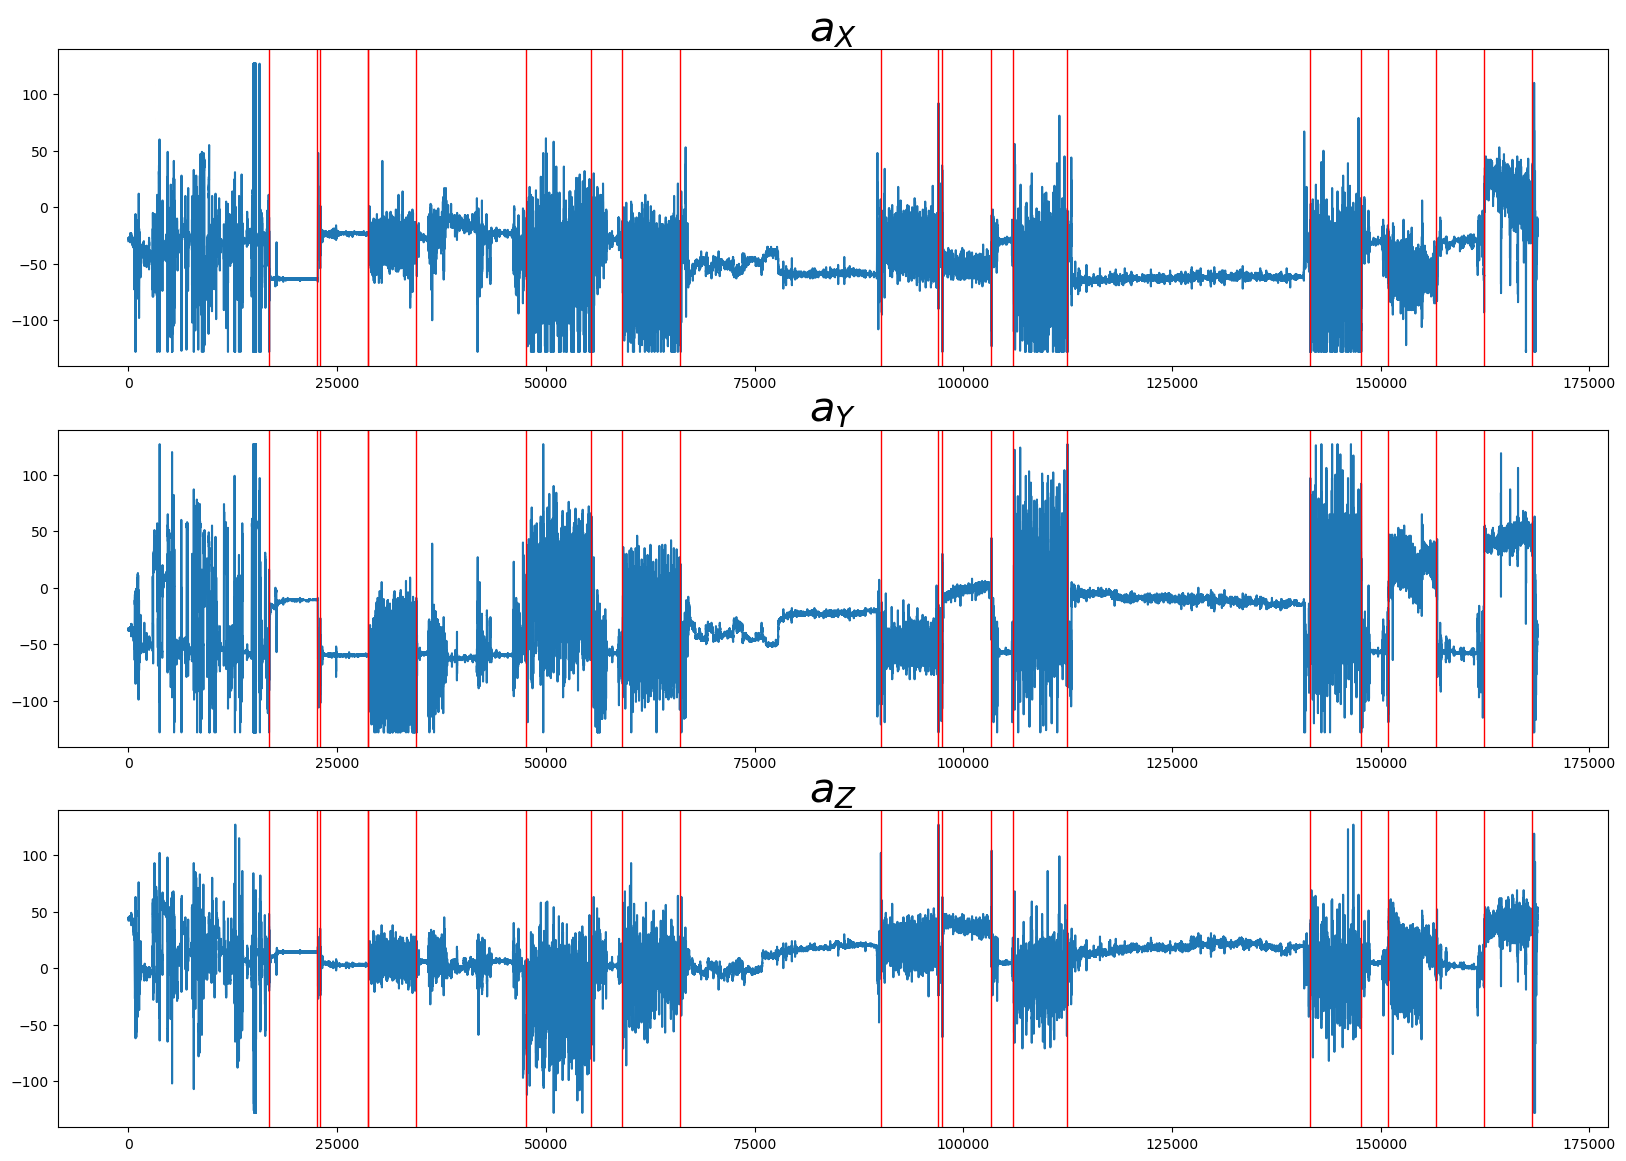

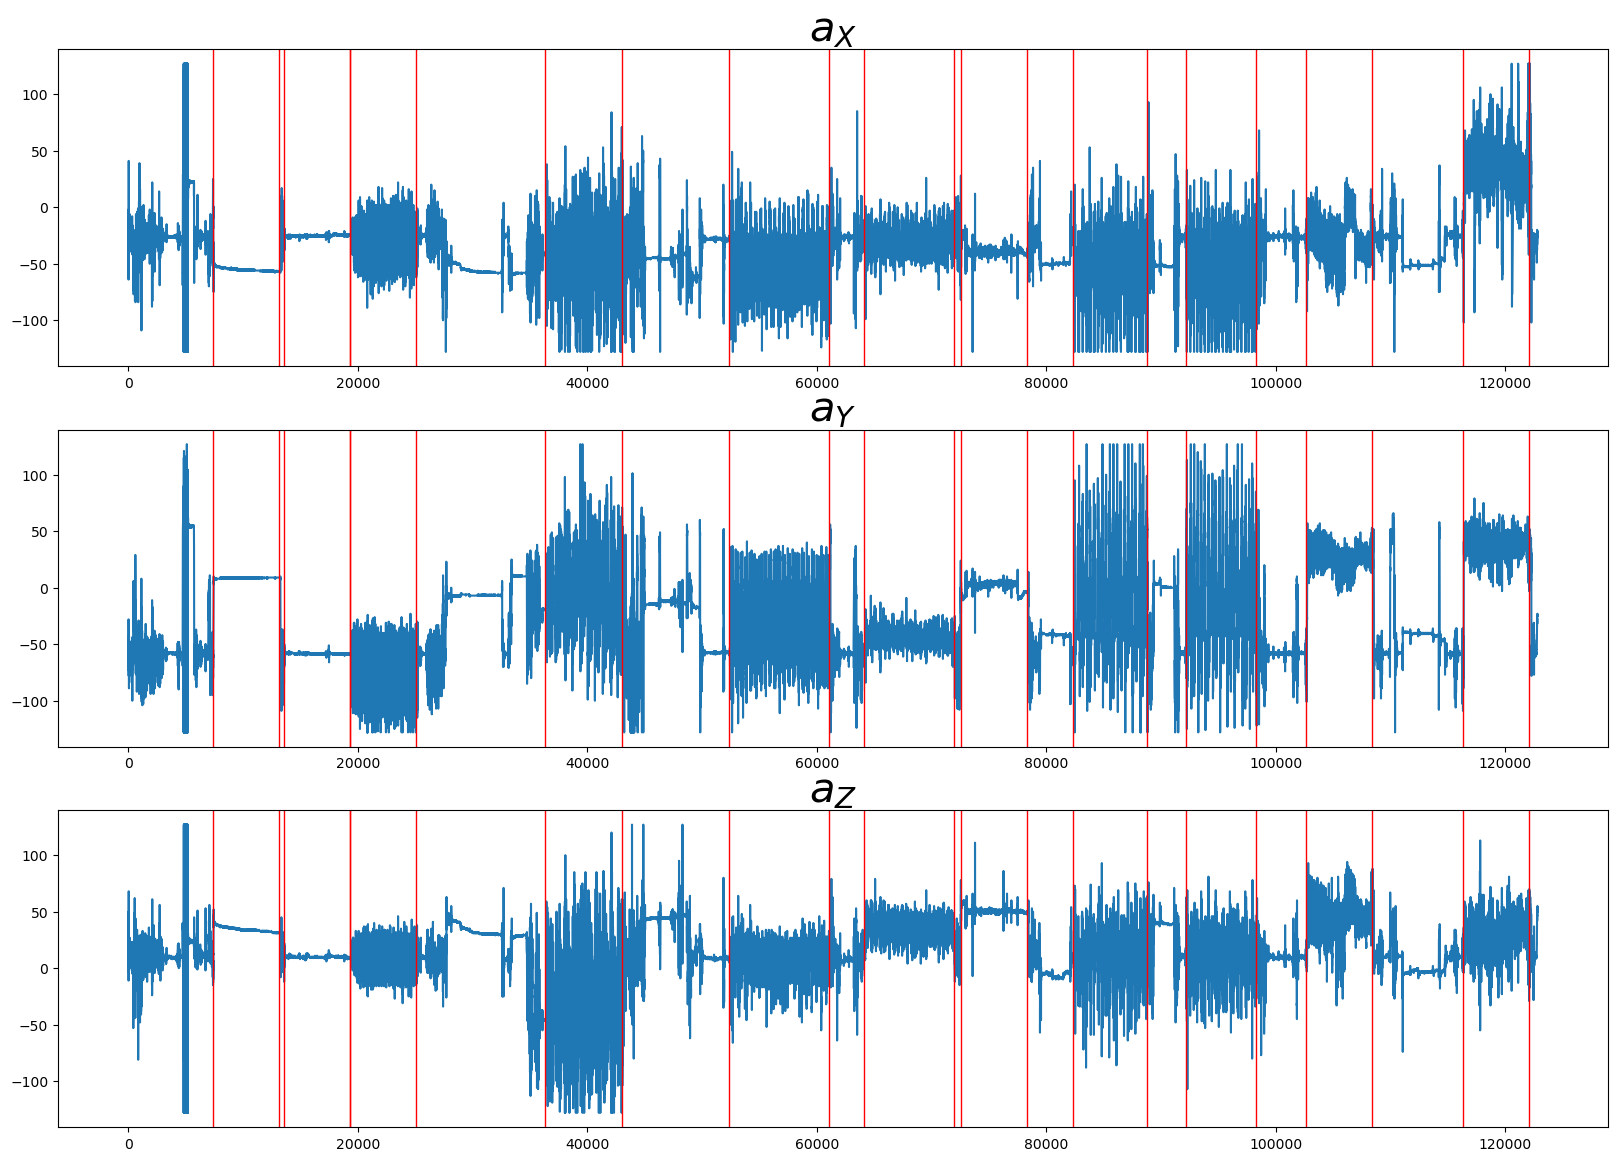

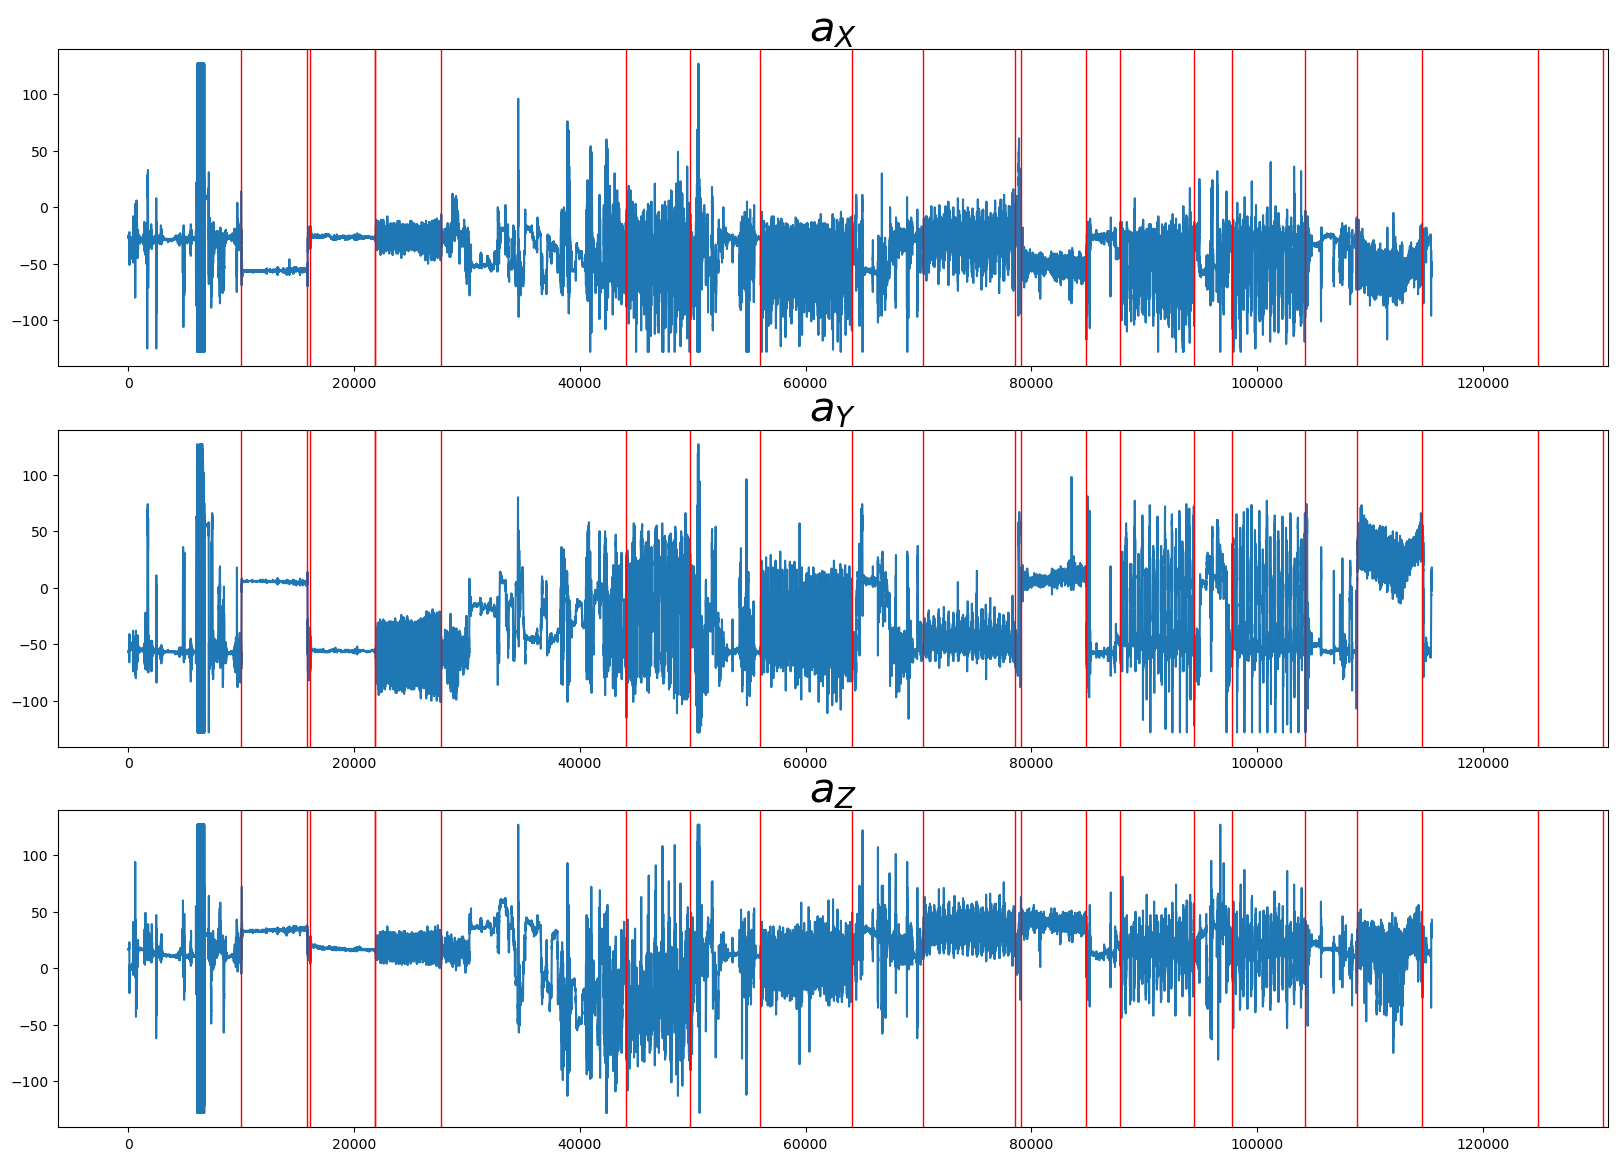

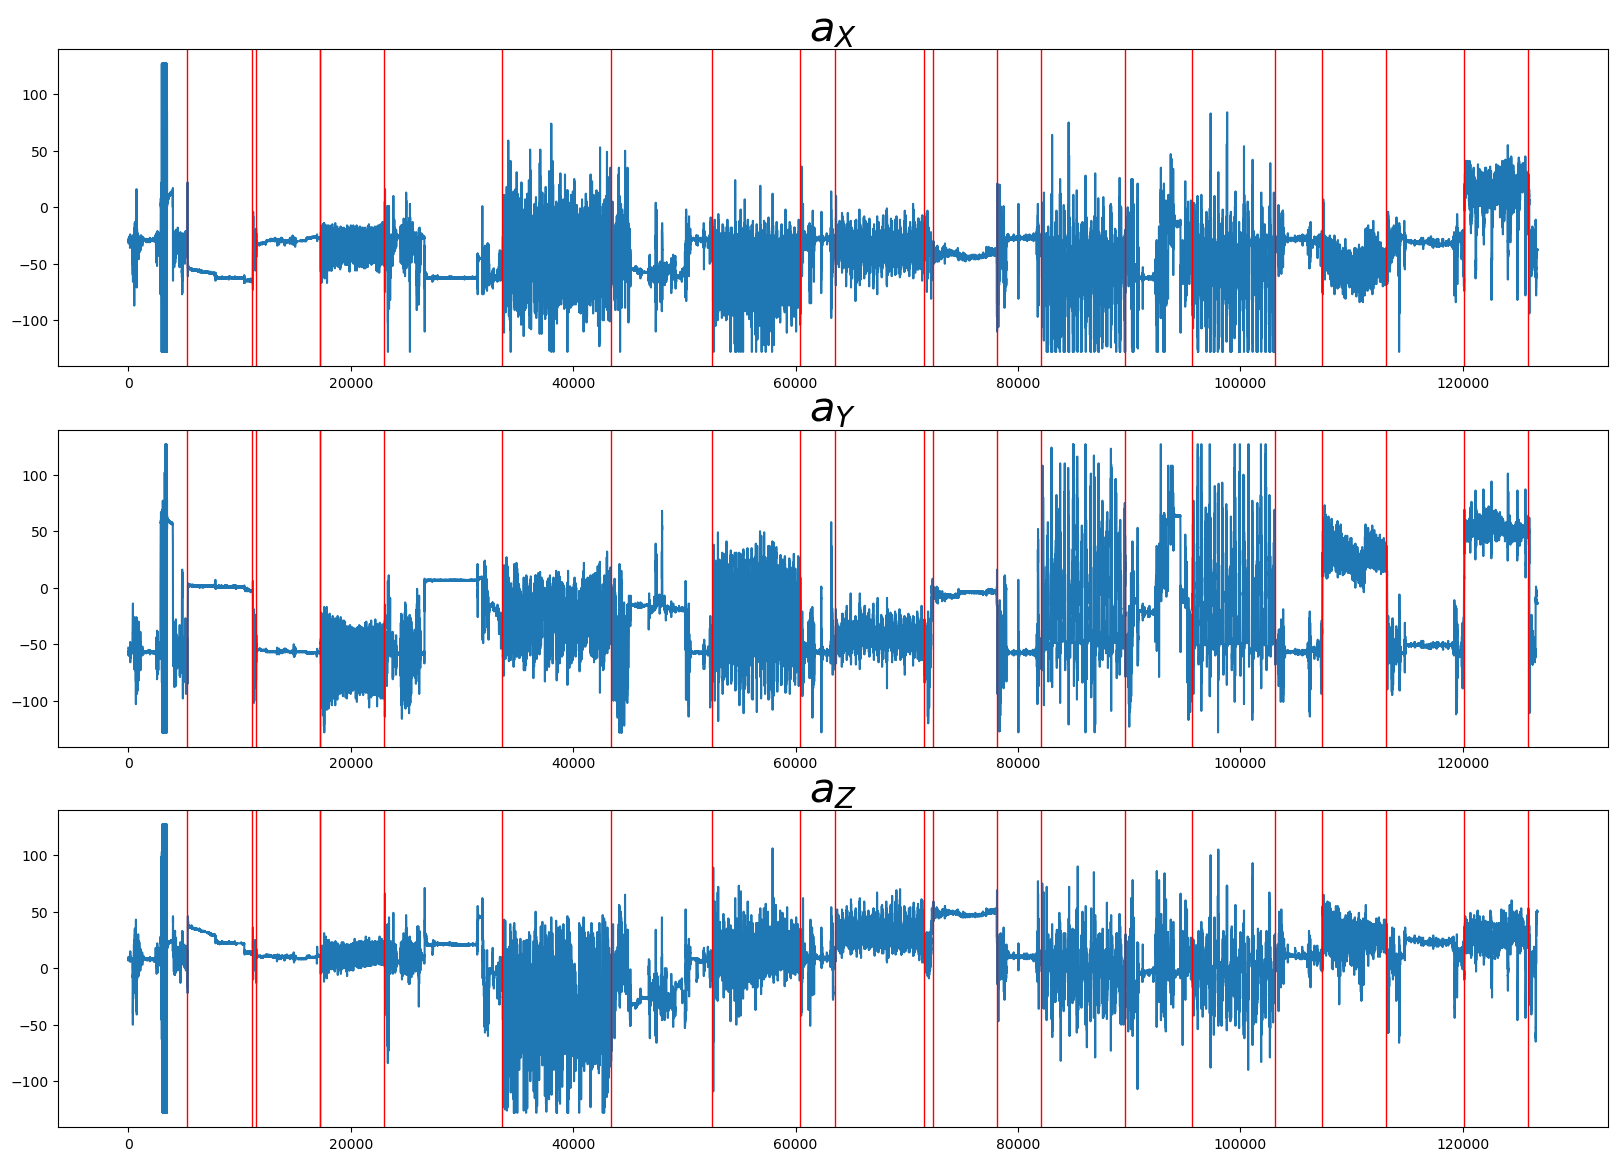

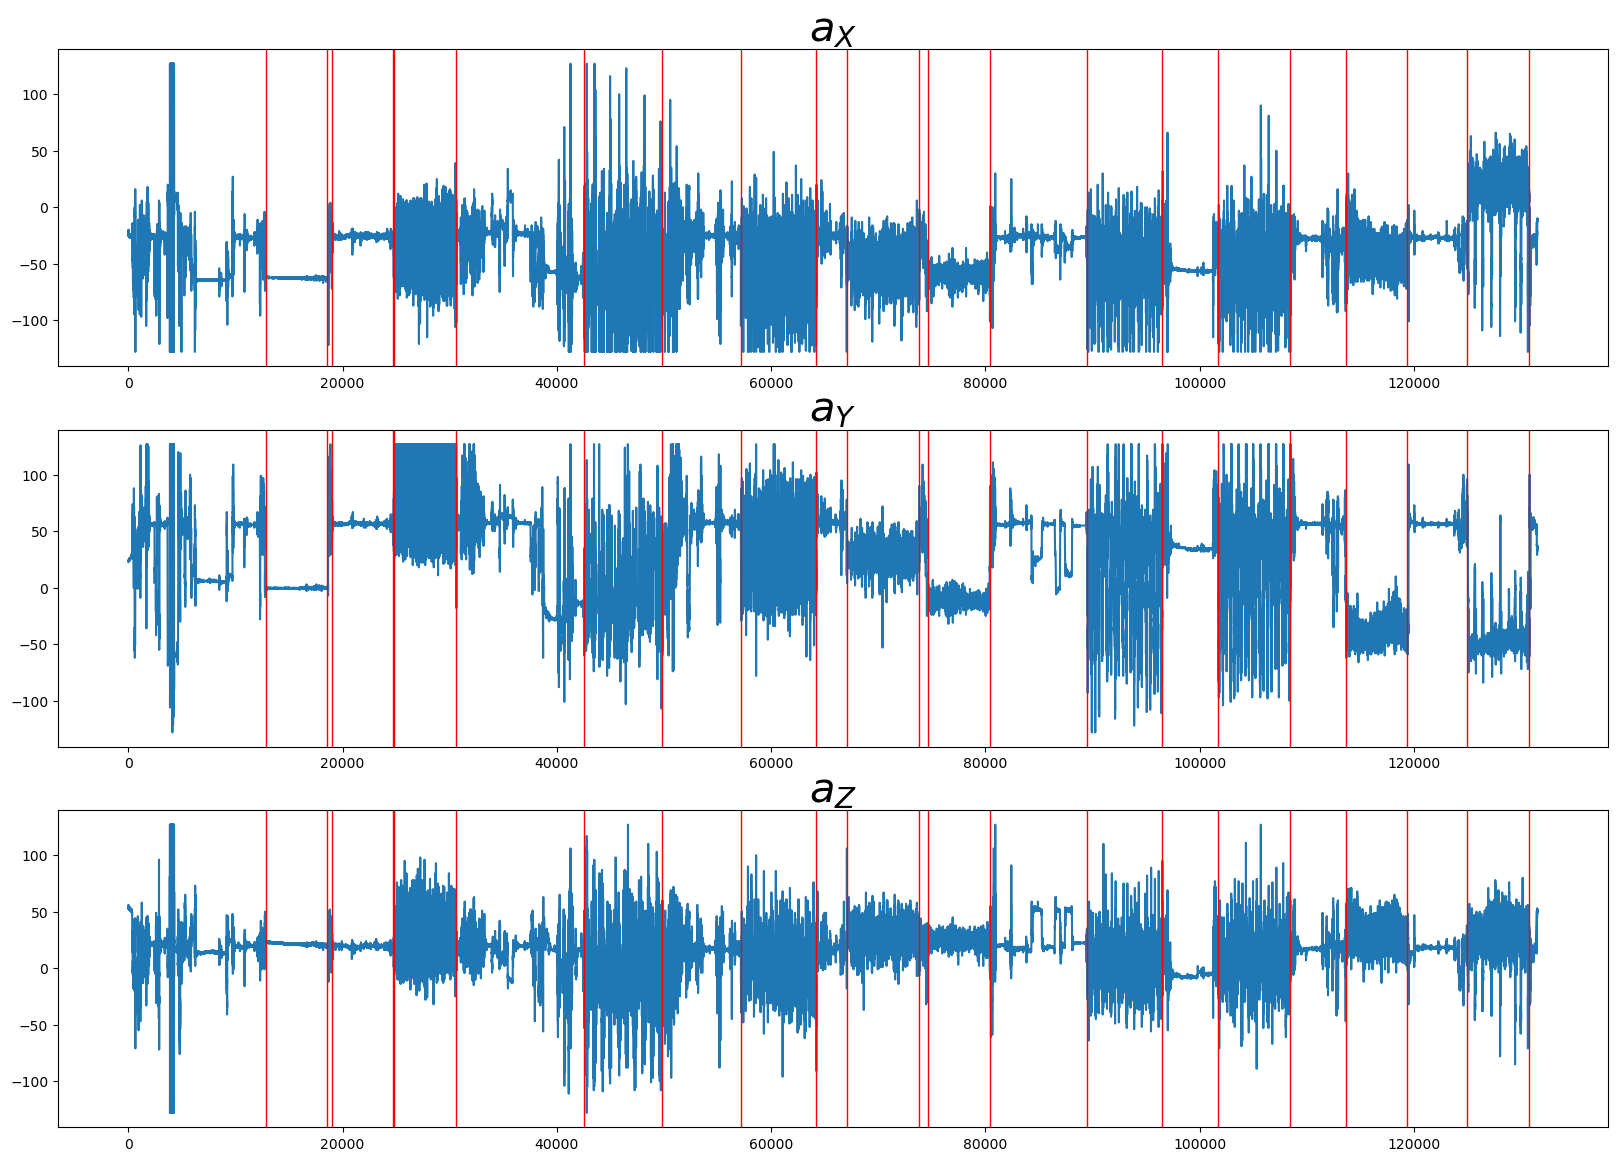

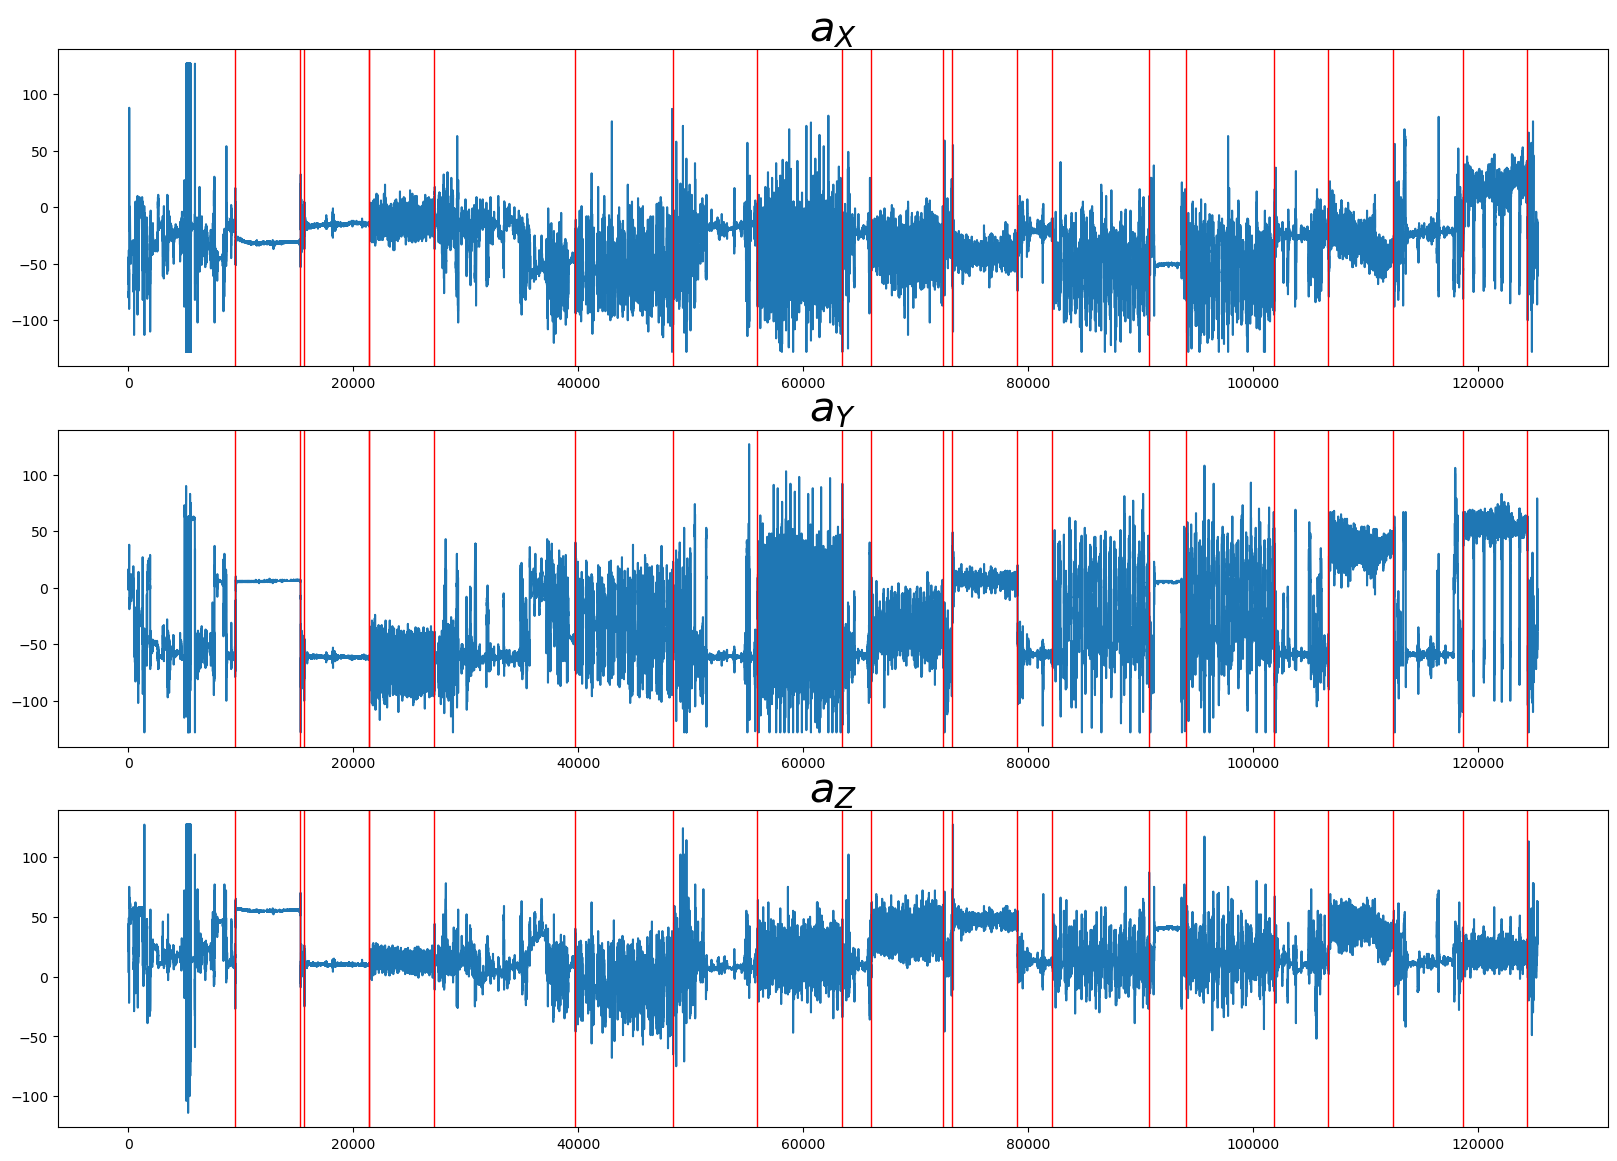

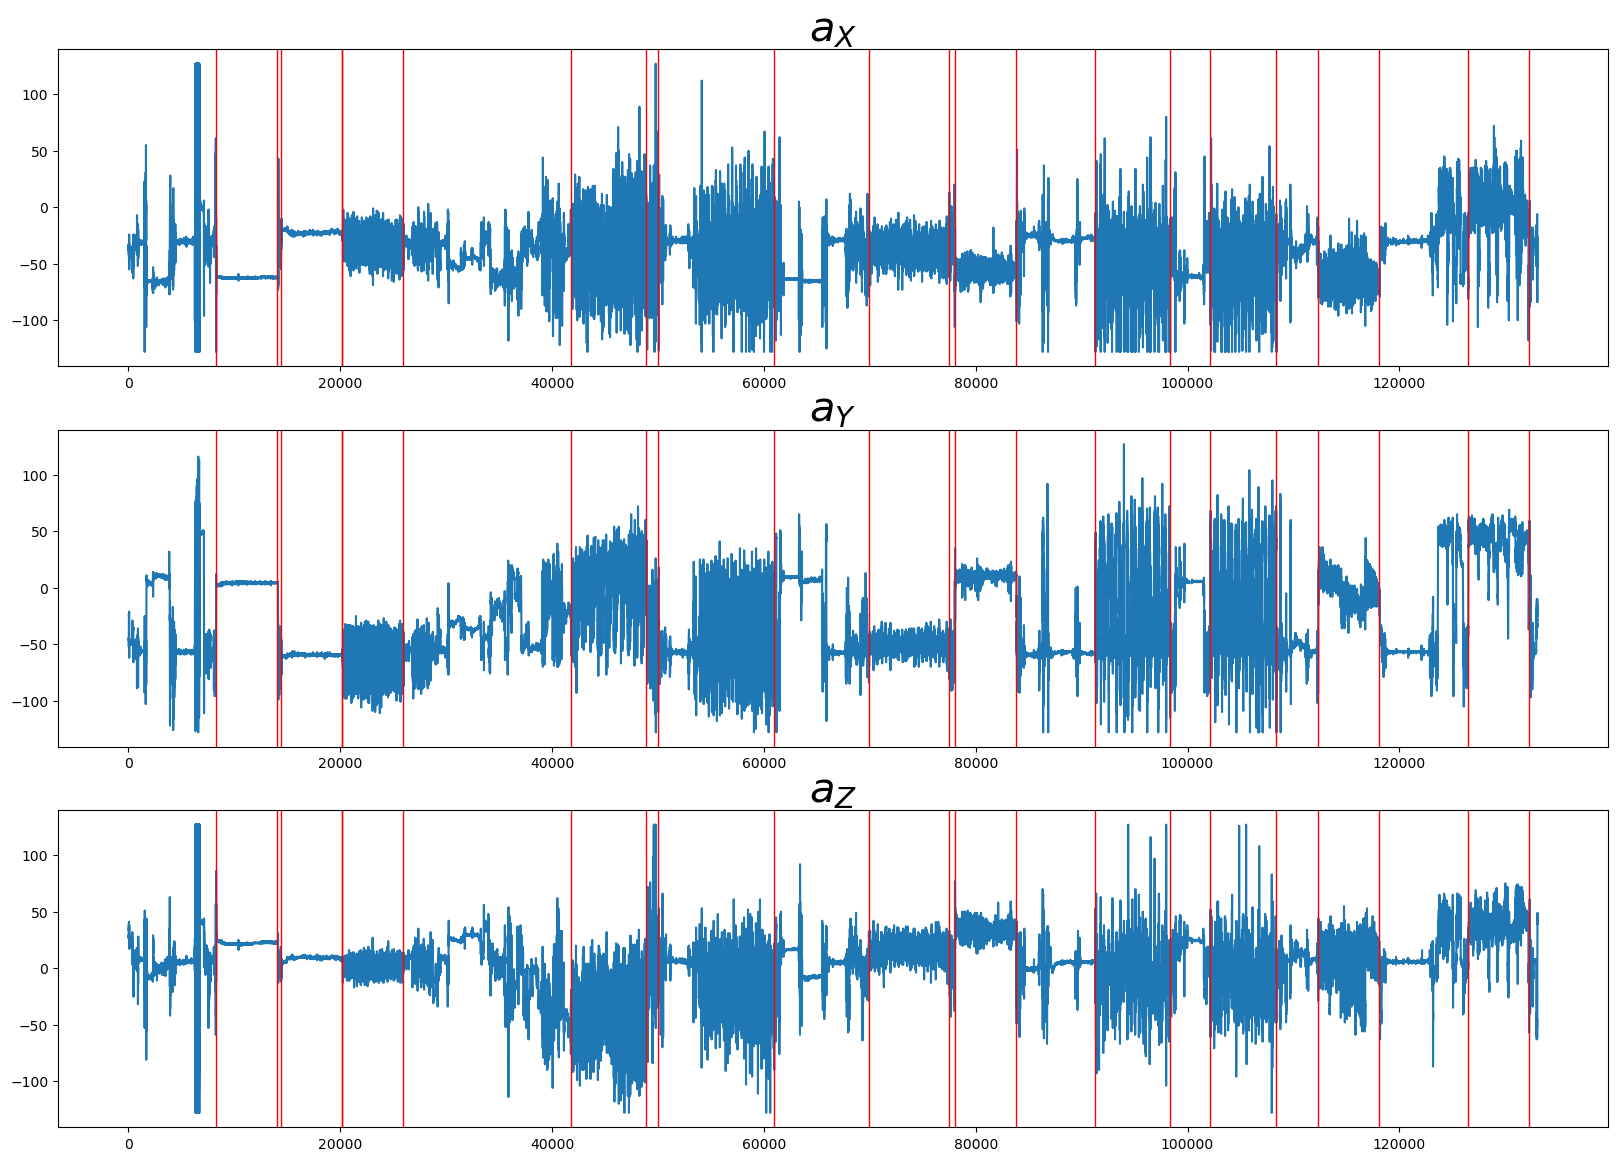

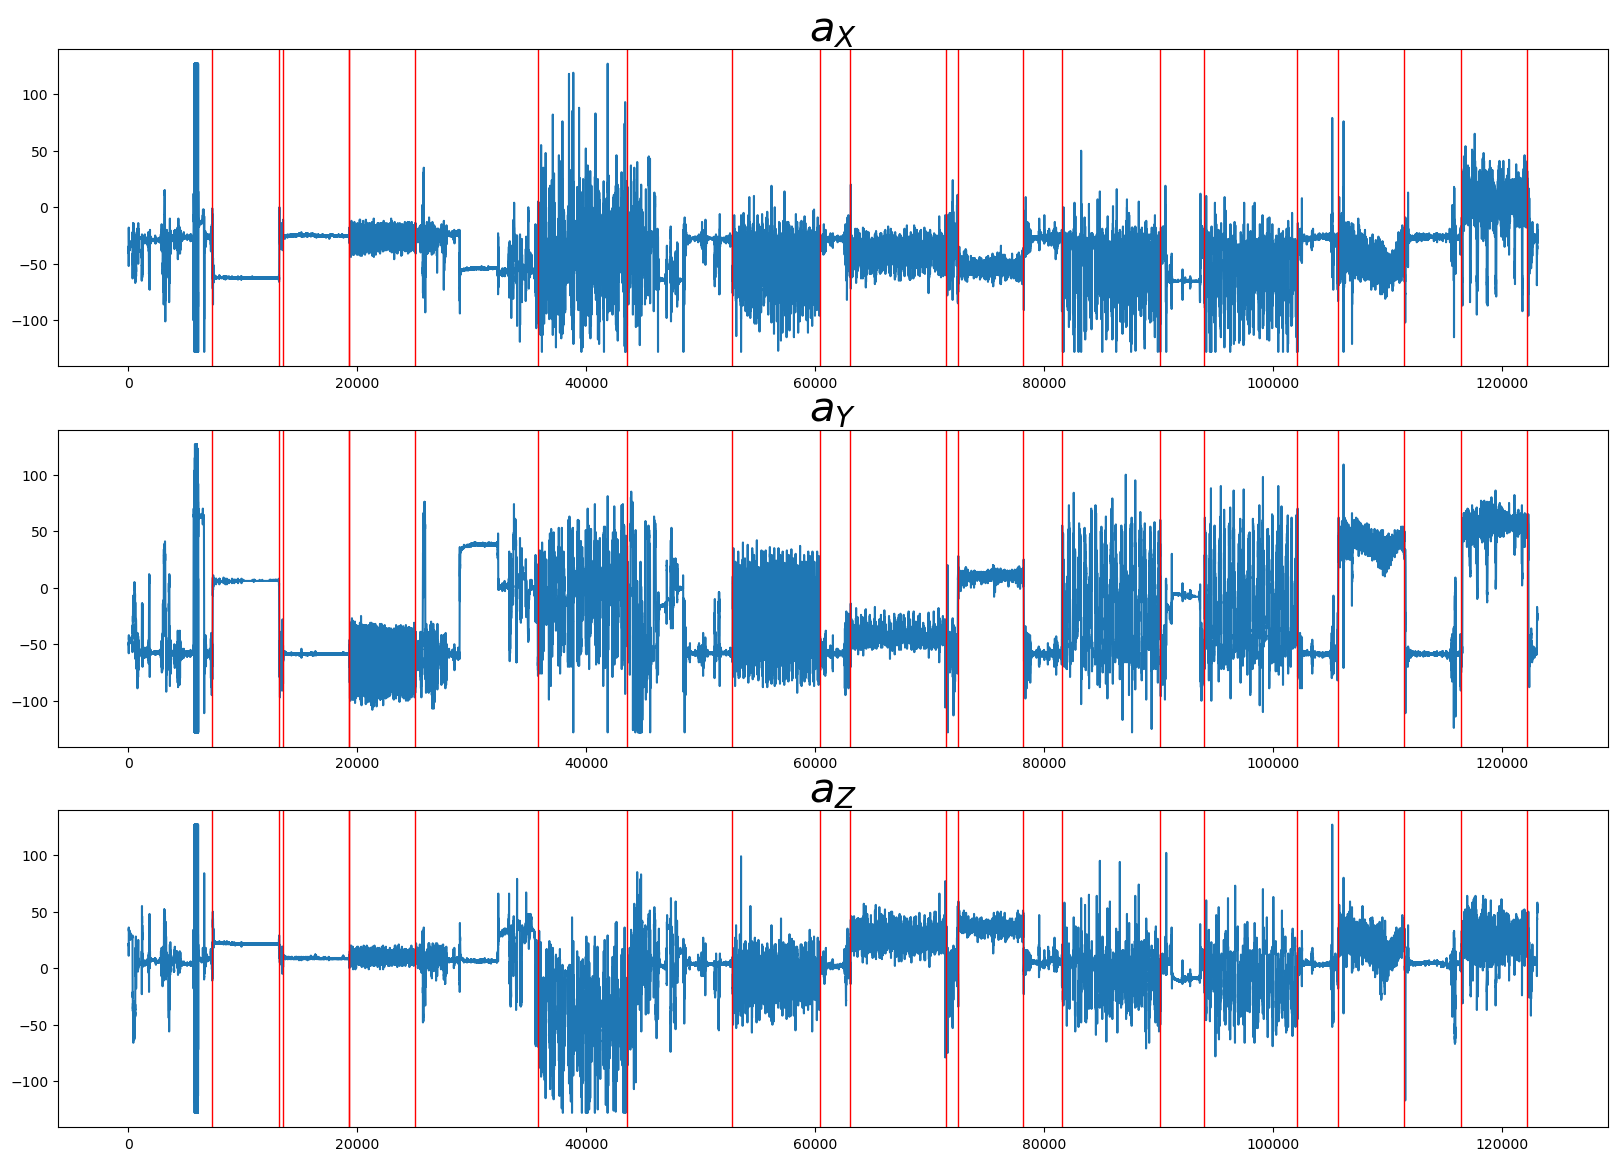

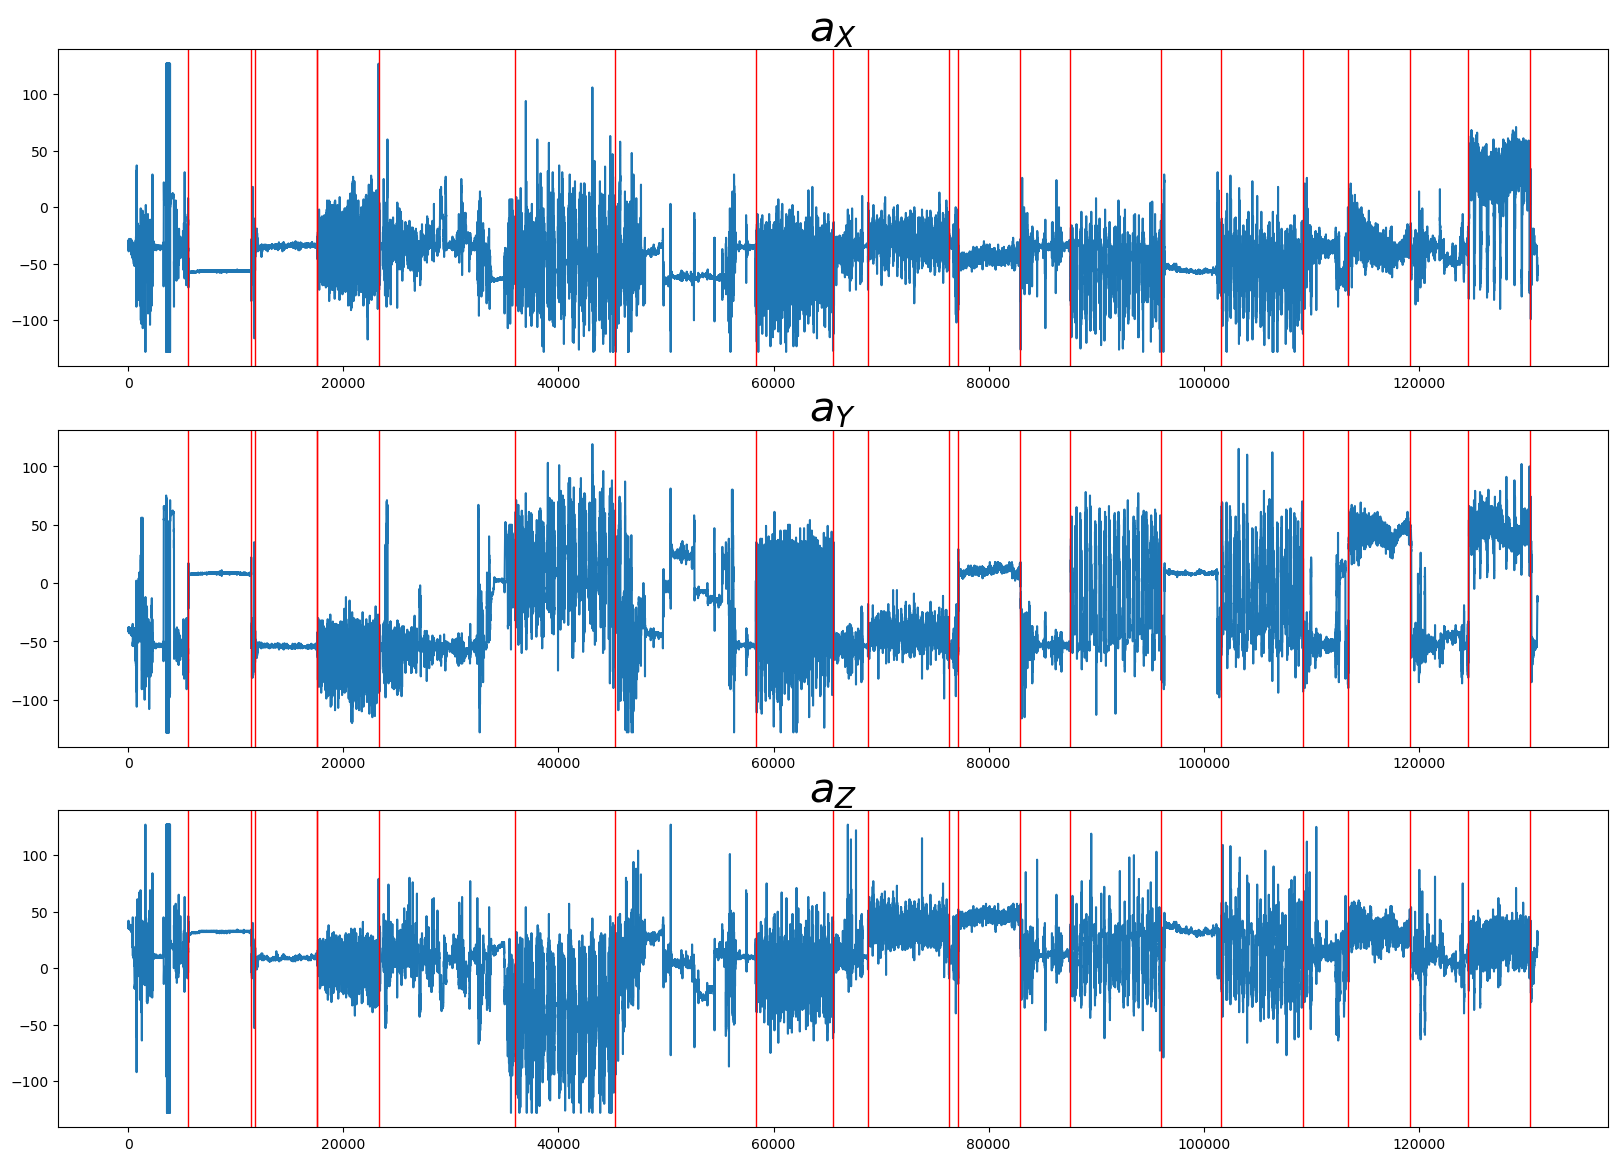

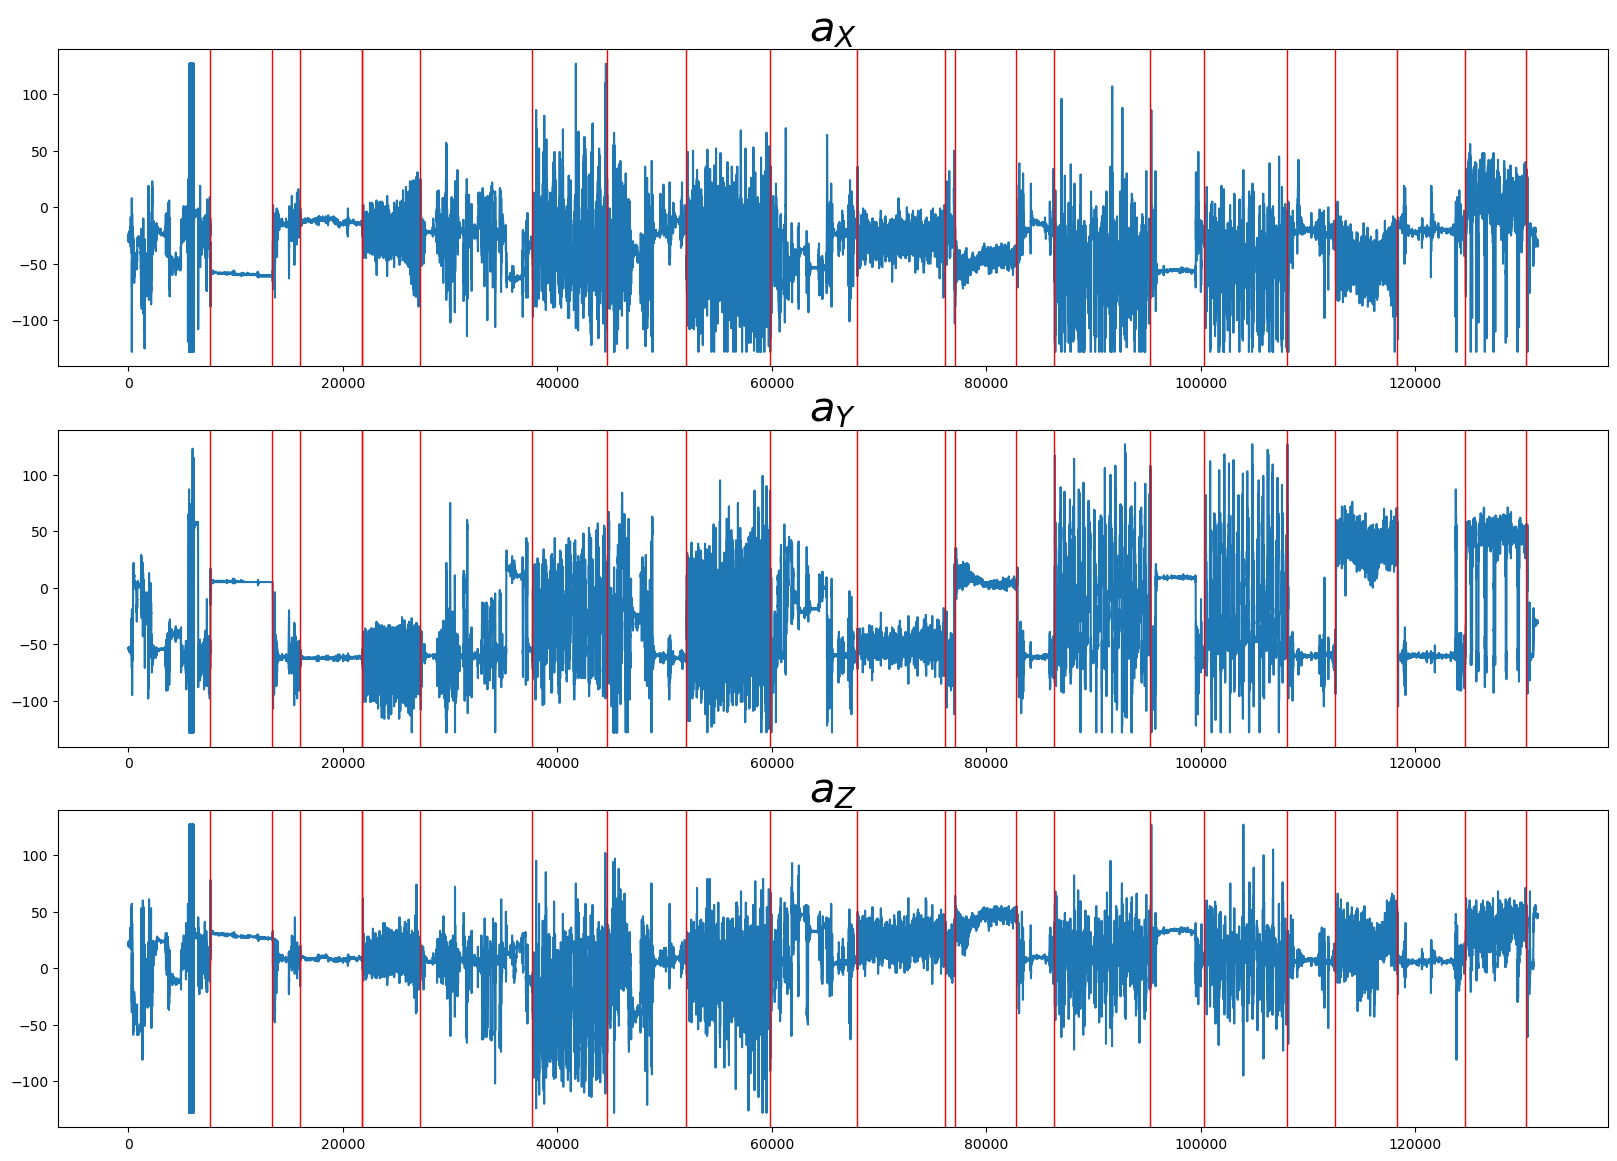

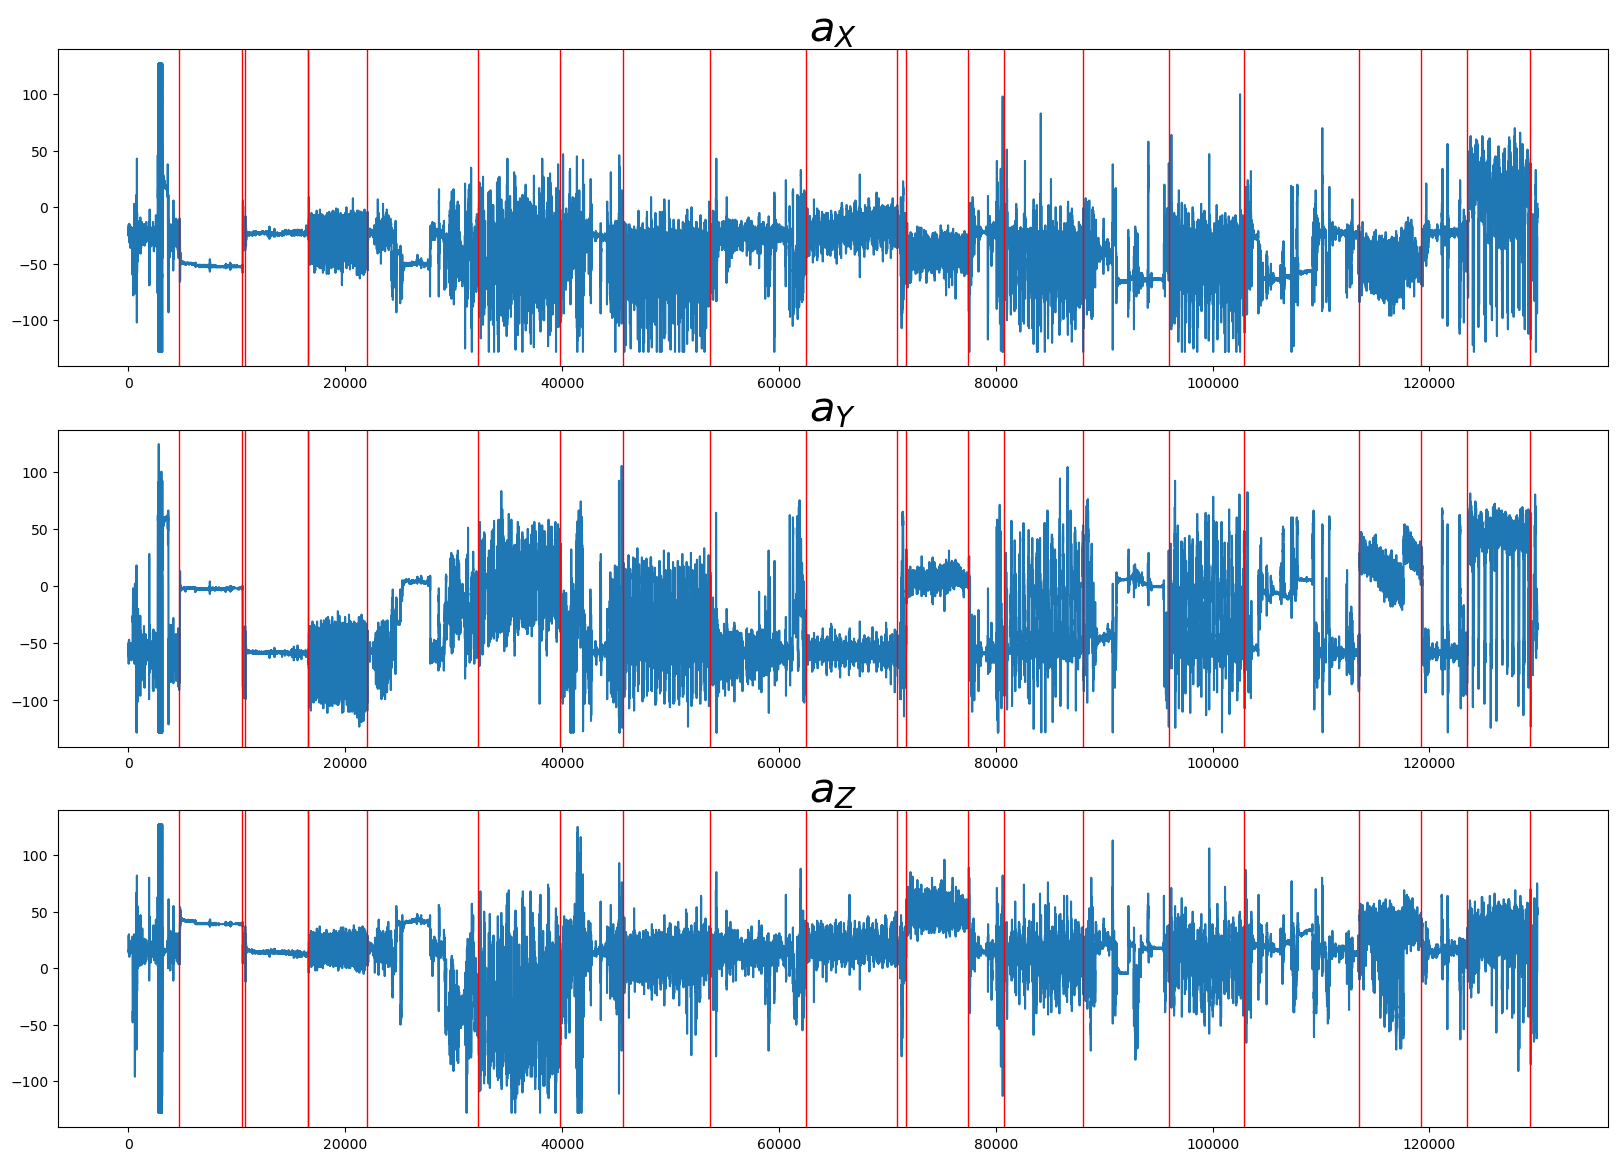

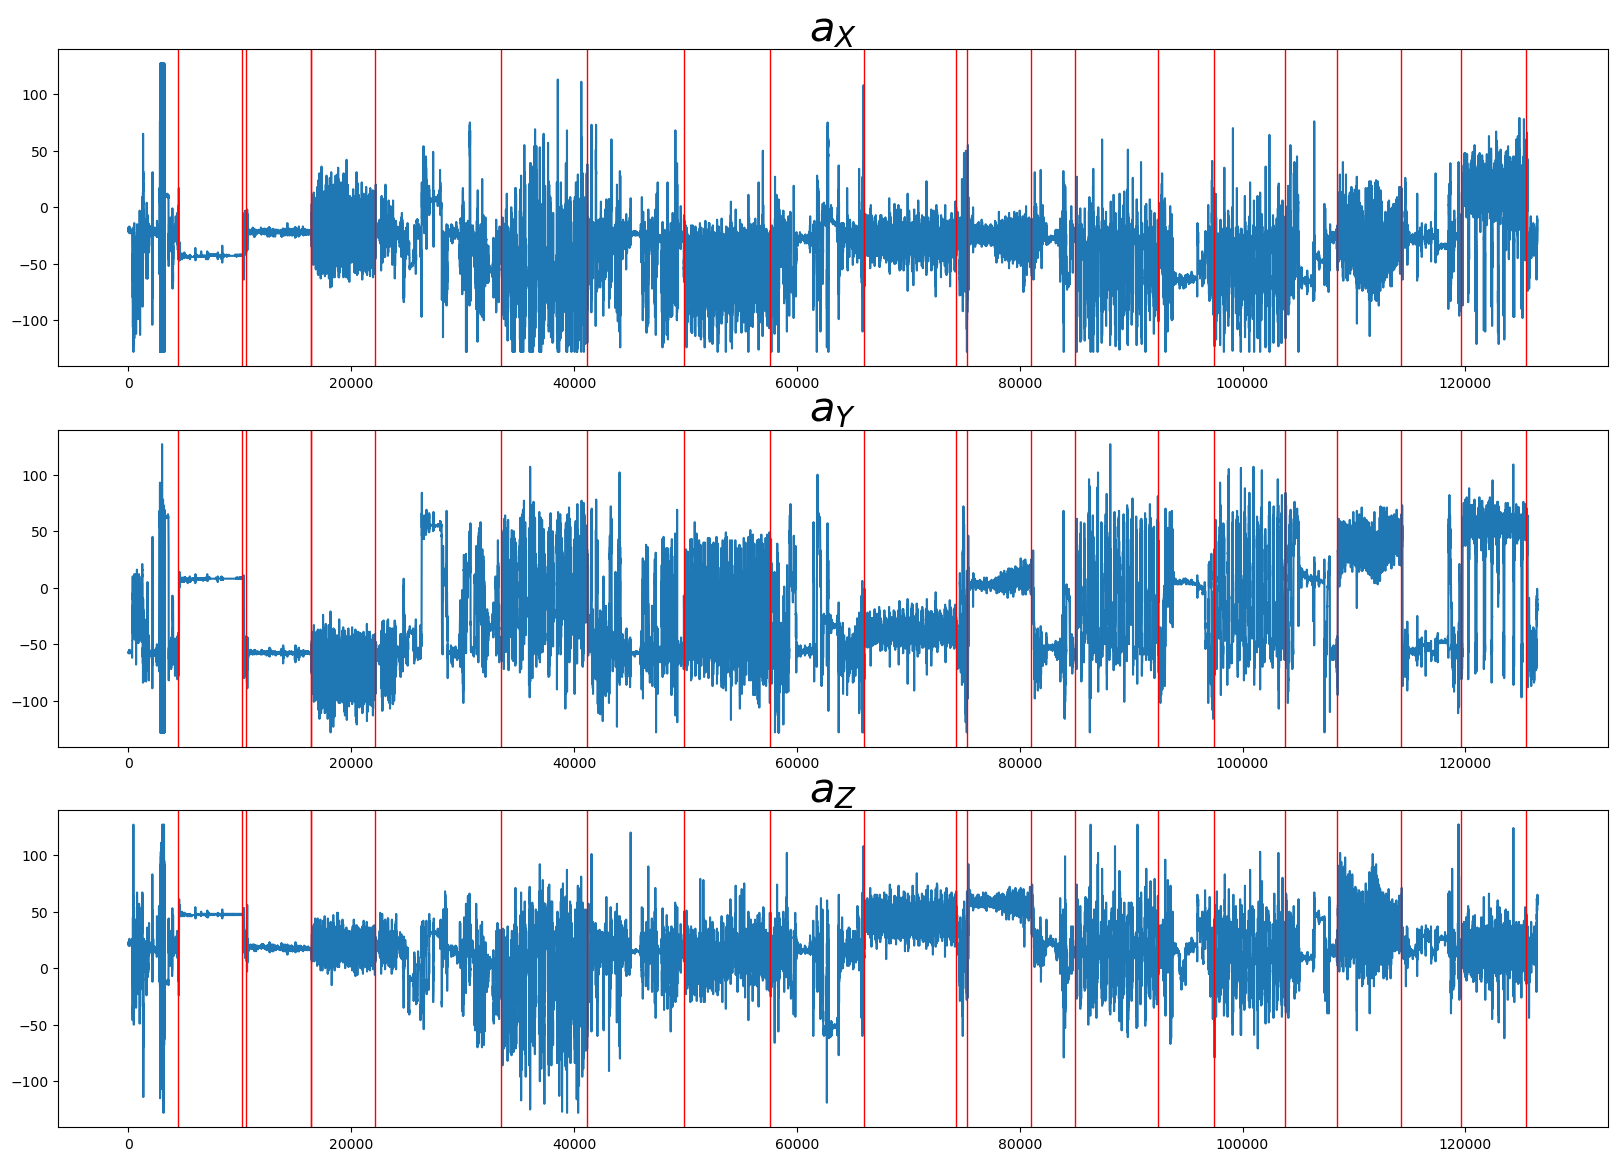

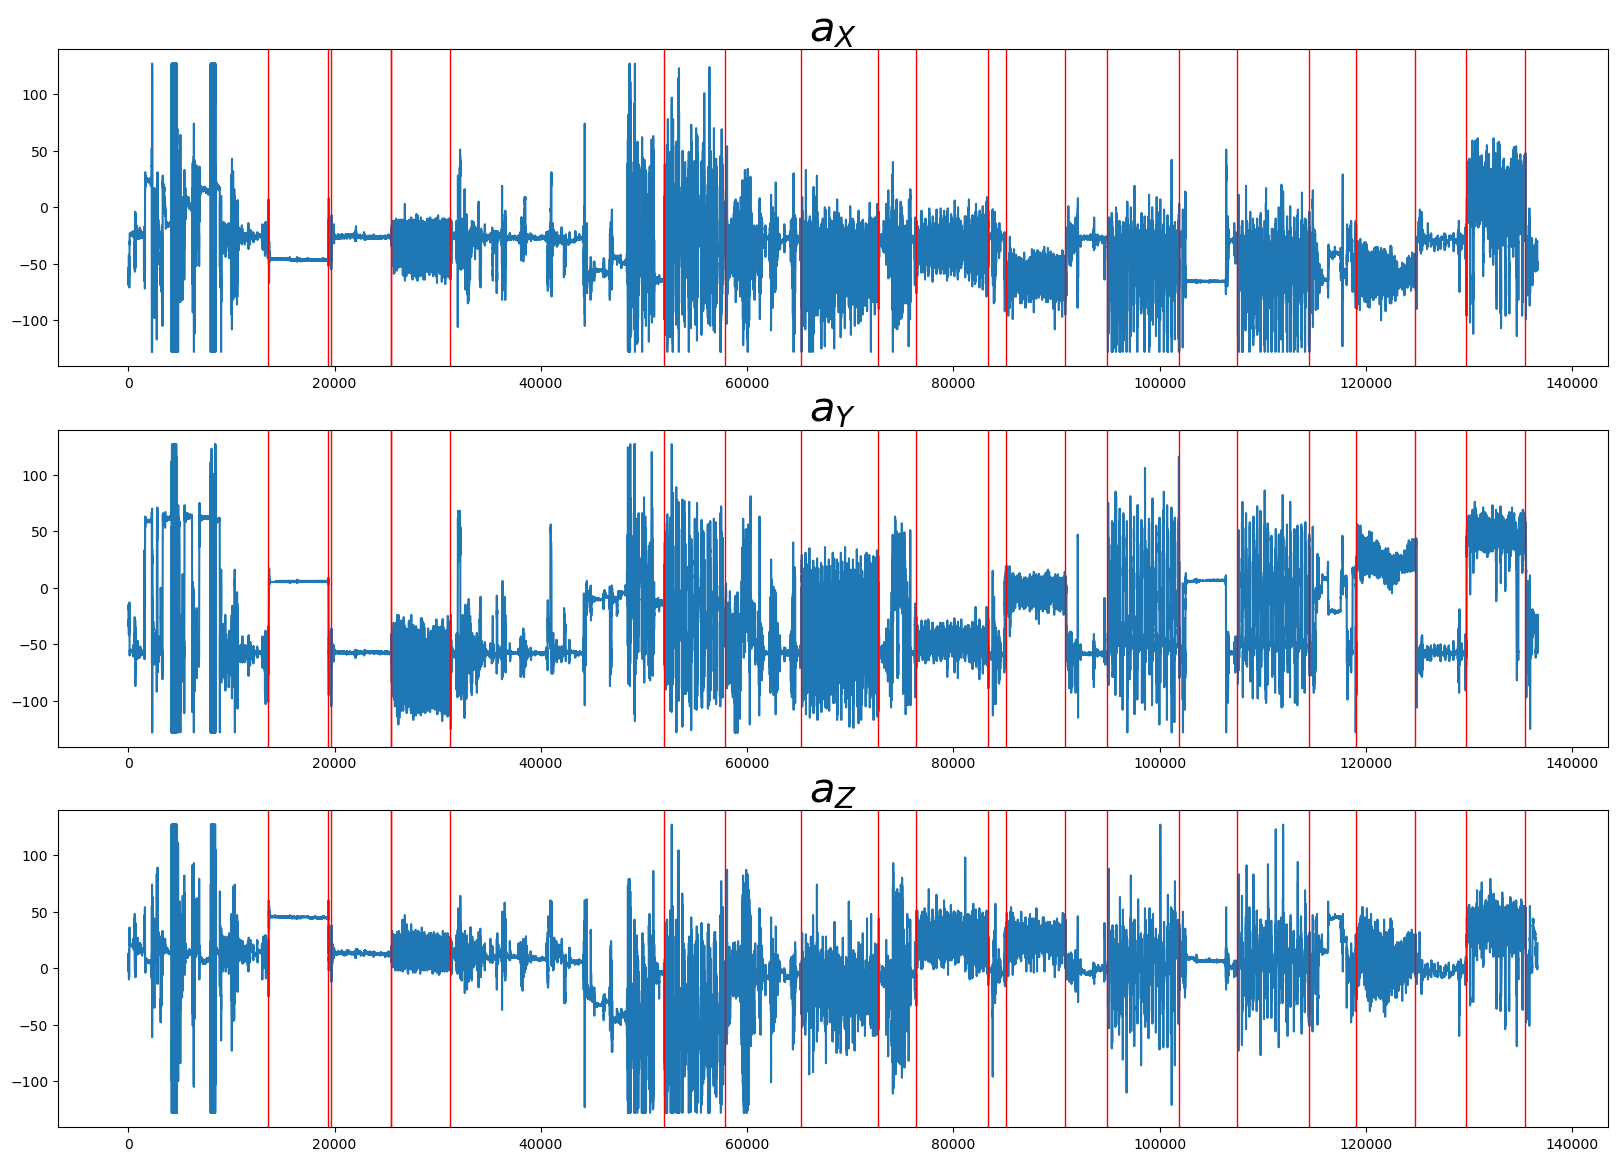

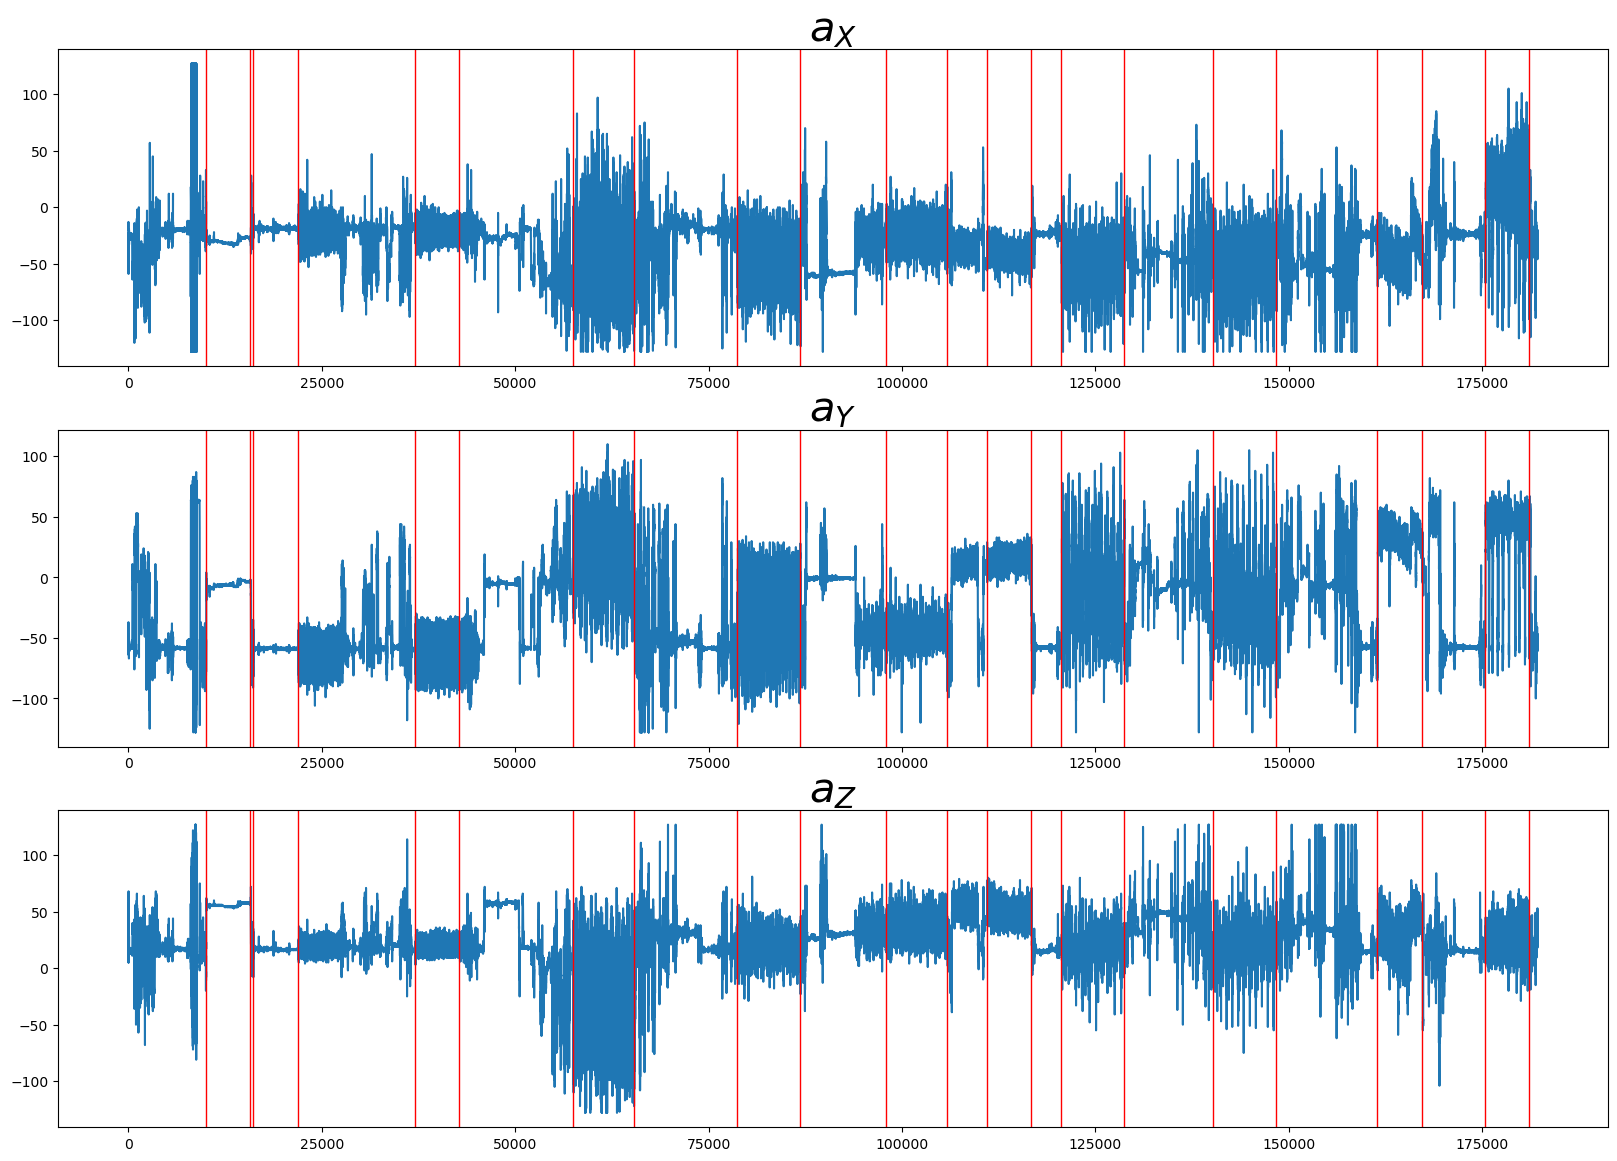

In [8]:
sub_tab=[widgets.Output() for i in range(len(sepSubIDs))]
tab = widgets.Tab(sub_tab)
for i, id in enumerate(sepSubIDs):
    tab.set_title(i,"sub {}".format(id))
    with sub_tab[i]:
        f = plotSigAnnot(sepLabeledDict, sepTaskIndDict, id=id, figSize=(20,14))
        plt.show(f)
display(tab)

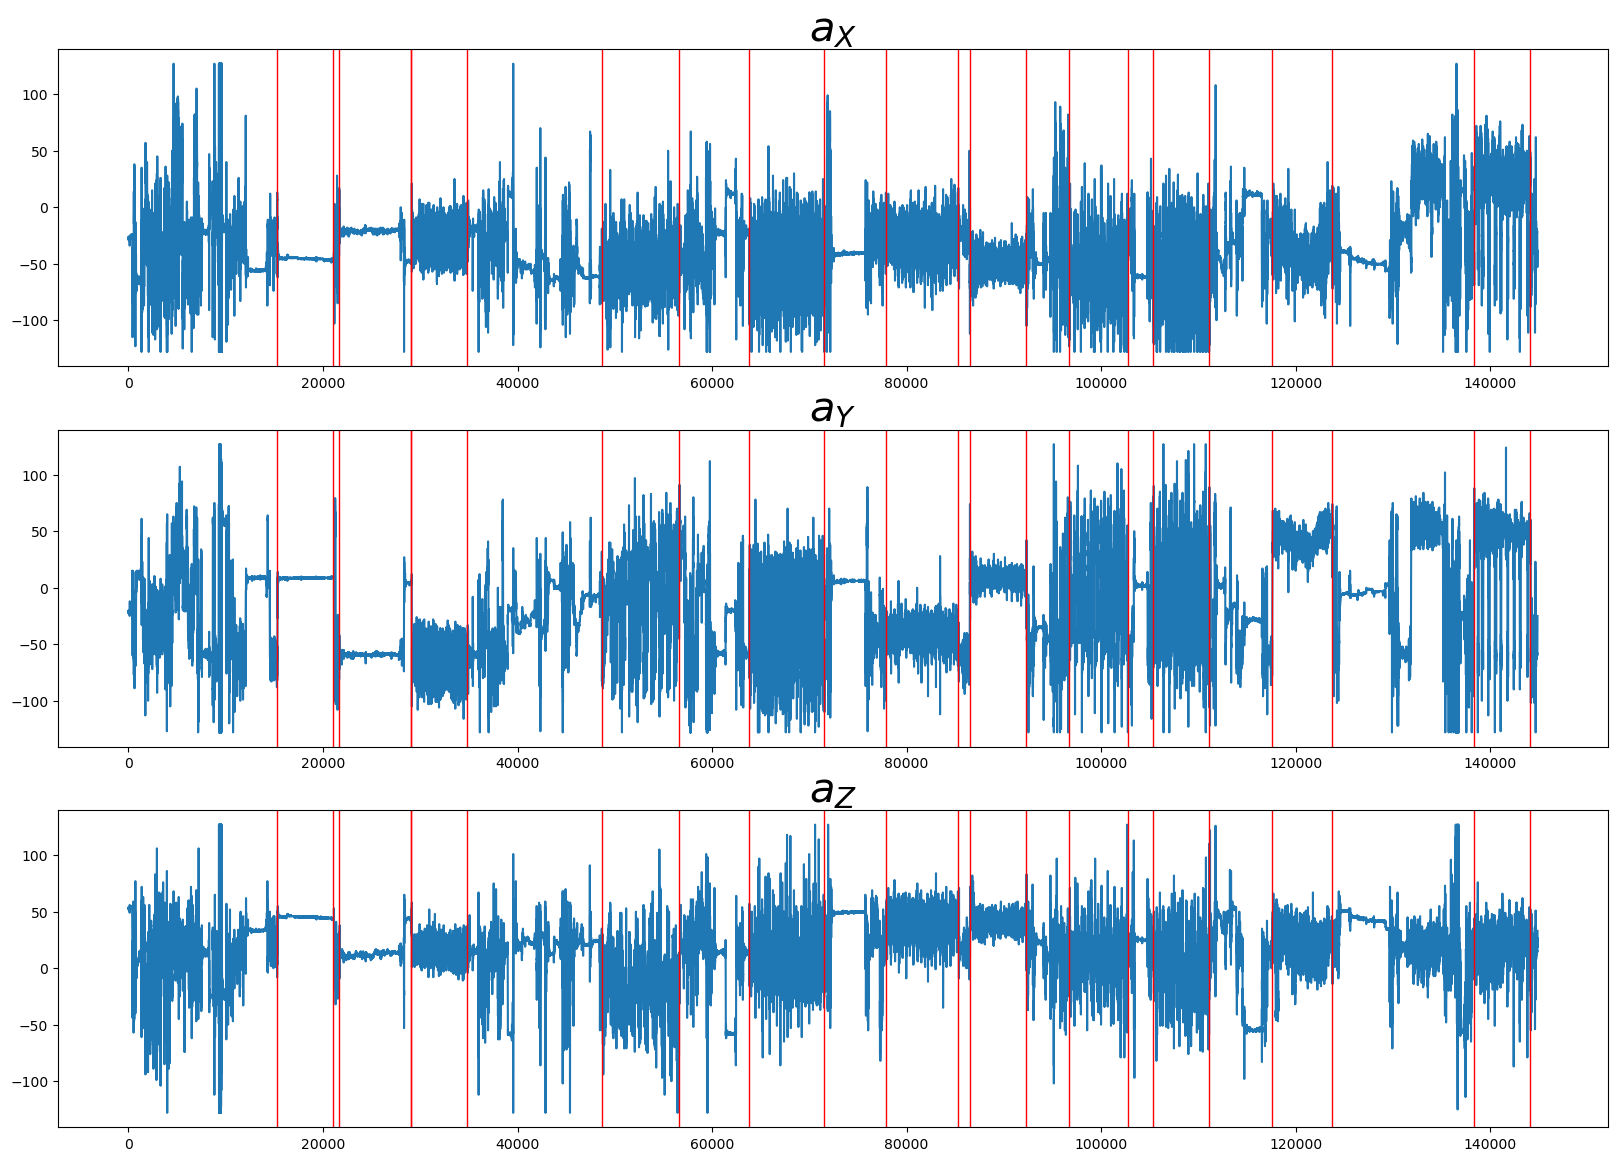

In [9]:
f = plotSigAnnot(sepLabeledDict, sepTaskIndDict, id=15, figSize=(20,14))

## Feature Engineering


#### Create Signal Arrays

The getArrDict function in the following code chunk, extracts certain length of the acceleration signals for each subject and store them in 3D numpy arrays of shape (a, b, c). Here a is the number of windows, b is the window length, and c is the number of signals plus one (ax,ay,az, and label).


In [10]:
def getArrDict(labeledDict, subject_ids, windowLen):
    ArrDict = {}
    for id in subject_ids:
        df = pd.DataFrame(data=labeledDict[id], columns=['aX', 'aY', 'aZ', 'label'])
        grDict = dict(tuple(df.groupby(by='label'))) # dict values are pd DF's
        sigArr = np.zeros((0, windowLen, 4))
        for key in grDict.keys():
            task_df = grDict[key]
            tmp1 = [task_df.iloc[i:i+windowLen, :] for i in range(0, task_df.shape[0], windowLen)]
            if len(tmp1[-1]) != windowLen: del tmp1[-1]
            sigArr = np.vstack((sigArr, np.array(tmp1)))
        ArrDict[id] = sigArr
    return ArrDict

In [11]:
def applyFilter(sig, SR, n, fc):
    w = fc/(SR/2)
    b, a = signal.butter(n, w, 'low')
    filteredSig = signal.filtfilt(b, a, sig)
    return filteredSig

def fftCalc(sig, sampRate, windowLen):
    f_values = np.linspace(0, sampRate/2, windowLen//2)
    fft_values = 2/windowLen * np.abs(fft(sig)[0:windowLen//2])
    filtered_f = f_values[f_values<10]
    filtered_fft = fft_values[f_values<10]
    return filtered_f, filtered_fft

def fftPeaks(sig, filtered_f, filtered_fft, percentile, denominator, sampRate, no_peaks):
    signal_min = np.percentile(sig, percentile)
    signal_max = np.percentile(sig, 100-percentile)
    mph = (signal_max - signal_min)/denominator # minimum peak height
    indices_peaks = detect_peaks(filtered_fft, mph=mph)
    if len(indices_peaks) >= no_peaks:
        peakFeatures = list(filtered_f[indices_peaks])[:no_peaks] + list(filtered_fft[indices_peaks])[:no_peaks]
    else:
        missing = no_peaks-len(indices_peaks)
        peakFeatures = list(filtered_f[indices_peaks])+[0]*missing + list(filtered_fft[indices_peaks])+[0]*missing
    peakFeatures.append(filtered_fft[0])
    return peakFeatures

def applyFilter(sig, SR, n, fc):
    w = fc/(SR/2)
    b, a = signal.butter(n, w, 'low')
    filteredSig = signal.filtfilt(b, a, sig)
    return filteredSig

def fftCalc(sig, sampRate, windowLen):
    f_values = np.linspace(0, sampRate/2, windowLen//2)
    fft_values = 2/windowLen * np.abs(fft(sig)[0:windowLen//2])
    filtered_f = f_values[f_values<10]
    filtered_fft = fft_values[f_values<10]
    return filtered_f, filtered_fft

def fftPeaks(sig, filtered_f, filtered_fft, percentile, denominator, sampRate, no_peaks):
    signal_min = np.percentile(sig, percentile)
    signal_max = np.percentile(sig, 100-percentile)
    mph = (signal_max - signal_min)/denominator # minimum peak height
    indices_peaks = detect_peaks(filtered_fft, mph=mph)
    if len(indices_peaks) >= no_peaks:
        peakFeatures = list(filtered_f[indices_peaks])[:no_peaks] + list(filtered_fft[indices_peaks])[:no_peaks]
    else:
        missing = no_peaks-len(indices_peaks)
        peakFeatures = list(filtered_f[indices_peaks])+[0]*missing + list(filtered_fft[indices_peaks])+[0]*missing
    peakFeatures.append(filtered_fft[0])
    return peakFeatures
def getStats(sig):
    mean_ = np.mean(sig)
    rms_ = np.sqrt(np.mean(np.square(sig)))
    mad_ = np.mean(np.absolute(sig-np.mean(sig)))
    std_ = np.std(sig)
    min_ = min(sig)
    max_ = max(sig)
    med_ = np.percentile(sig, 50)
    perc25 = np.percentile(sig, 25)
    perc75 = np.percentile(sig, 75)
    stats_ = [mean_, rms_, mad_, std_, min_, max_, med_, perc25, perc75]
    return stats_

def getCrossings(sig):
    zeroCross = np.count_nonzero(np.diff(np.sign(sig)))
    centeredSig = sig - np.mean(sig)
    meanCross = np.count_nonzero(np.diff(np.sign(centeredSig)))
    return [zeroCross, meanCross]

def getEntropy(sig):
    count = Counter(sig).most_common()
    probability = [elem[1]/len(sig) for elem in count]
    return [stats.entropy(probability)]


def extract_features_dicts(dataset, windowLen, sampRate, denominator, no_peaks, waveletName, featureSet, percentile=5):
    list_of_features = []
    for samp_no in range(0, dataset.shape[0]):
        features = []
        for sig_comp in range(0, dataset.shape[2] - 1):
            signal = dataset[samp_no, :, sig_comp]
            if featureSet == 'Time':
                features += getStats(applyFilter(signal, SR=sampRate, n=4, fc=10))
            elif featureSet == 'FrequencyAll':
                filtered_f, filtered_fft = fftCalc(signal, sampRate, windowLen)
                features += list(filtered_fft)
            elif featureSet == 'FrequencyPeaks':
                filtered_f, filtered_fft = fftCalc(signal, sampRate, windowLen)
                features += fftPeaks(signal, filtered_f, filtered_fft, percentile, denominator, sampRate, no_peaks)
            elif featureSet == 'TimeFrequency':
                waveletCoeffs = pywt.wavedec(signal, waveletName)
                for coeff in waveletCoeffs:
                    features += getStats(coeff) + getEntropy(coeff) + getCrossings(coeff)
            
        modifiedLabel = ''.join([i for i in dataset[samp_no, 0, 3] if not i.isdigit()]) # remove any numbers from label
        features.append(modifiedLabel) # Add modified label as last column
        list_of_features.append(features)
    features_df = pd.DataFrame(np.array(list_of_features), columns=list(range(1, len(list_of_features[0]))) + ['label'])
    return features_df

##### In the reference paper, both window lengths of 4 and 10 seconds were selected, however, since the larger window length are used for recognition of more complex task and the traditional learning algorithms had comparable performance in both window lengths, we only chose the 10 seconds window length.

### Time-Frequency Domain Features


* Next, the time-frequency domain features were generated for the chosen window-size of 320, as these features preserve the frequency information at each time point. 



* In order to retrieve the time-frequency features, the discrete wavelet transform(DWT) method was used. 





### DWT Tranformation:




* For the DWT transformation, a Daubechies-4 mother wavelet (db4) with the filter bank approach was used, which decomposed the original signals to detail (cD) and approximation(cA) coefficient. 



* The decomposition was applied up to 5 levels on three acceleration signals. The final feature set of size 216 were the result of concatenation of the entropy, number of zero and mean-crossings, and 9 statistics (These statistics included mean to capture the central tendency of the signal, root mean square (RMS) to represent the average power of the signal, mean average deviation (MAD) and standard deviation to represent the signal dispersion, and minimum, maximum, median, 25th percentile, and 75th percentile of the signal) calculated for the last approximation and all detail coefficients. 



* The final set of features were used as inputs to the learning algorithms explained in the next sections. It must be noted that the data collected in this experiment represents a non i.i.d data set with heterogeneity existing due to the inherent differences among participants.

In [12]:
windowLen = 320 
feature = 'TimeFrequency'
sepArrDict = getArrDict(sepLabeledDict, sepSubIDs, windowLen)
features_df = {}
for key in sepArrDict.keys():
    features_df[key] = extract_features_dicts(dataset=sepArrDict[key], windowLen=windowLen, sampRate=SR, denominator=15,
                                                                 no_peaks=5, waveletName='db4', featureSet=feature, percentile=5)

* In the Reference Paper both Intra and Inter subject training and testing is performed.

* However, since we ultimately want to train the algorithms on certain data and classify the tasks in unseen subjects, we only chose the Inter-subject method for our experiment. 


* here we split the train and test as follows:

   1)Train on 80% of all subjects and test on 20% of remaining subjects.
   
   2)Select 100% of the tasks from 80% of all subjects as training and 100% of the tasks from the rest 20% of subjects a testing.

In [13]:
def splitTrainTest_3(featureDict, trainSub, testSub):
    #test_series = pd.Series(testSub)
    testDict = {}
    for key in testSub:
        testDict[key] = featureDict[key]
        testDict[key]['subID'] = key
    test_df = pd.concat([testDict[x] for x in testDict.keys()]).reset_index().drop(['index'], axis=1)   
    X_test = test_df.loc[:, test_df.columns != 'label']
    Y_test = test_df.label
    trainDict = {}
    for key in trainSub:
        trainDict[key] = featureDict[key]
        trainDict[key]['subID'] = key
    train_df = pd.concat([trainDict[x] for x in trainDict.keys()]).reset_index().drop(['index'], axis=1)
    X_train = train_df.drop(['label', 'subID'], axis=1)
    Y_train = train_df.label
    return train_df, X_train, Y_train, X_test, Y_test, test_df

### Creating the final data frame

In the next code snippet the training and testing dataframes are created which are then concatenated to create the final dataframe that will be used for the analysis. It needs to be mentioned that although we divided the data into training and testing datasets here, later on we didn't use the same training and testing division as it needed to be changed.

In [15]:
startTime = time.time()

windowLenList2 = [320]
featureList2 = ['TimeFrequency']

random.seed(1365)
sub_list = list(features_df.keys())
random.shuffle(sub_list)

train_subs = list(set(sub_list) - set(test_subs))

for windowLen in windowLenList2:
    print('Window Length: ', windowLen)
    for feature in featureList2:
        print('Feature: ', feature)
        sepArrDict = getArrDict(sepLabeledDict, sepSubIDs, windowLen)
        features_df = {}
        for key in sepArrDict.keys():
            features_df[key] = extract_features_dicts(dataset=sepArrDict[key], windowLen=windowLen, sampRate=SR, denominator=15,
                                                                         no_peaks=5, waveletName='db4', featureSet=feature, percentile=5)
        train_df2, X_train2, Y_train2, X_test2, Y_test2, test_df2 = splitTrainTest_3(features_df, train_subs, test_subs)
        X_train_scale2 = preprocessing.scale(X_train2)
        X_test_scale2 = preprocessing.scale(X_test2)

------------------------------------------> Fold:  0
Window Length:  320
Feature:  TimeFrequency
------------------------------------------> Fold:  1
Window Length:  320
Feature:  TimeFrequency
------------------------------------------> Fold:  2
Window Length:  320
Feature:  TimeFrequency
------------------------------------------> Fold:  3
Window Length:  320
Feature:  TimeFrequency
------------------------------------------> Fold:  4
Window Length:  320
Feature:  TimeFrequency


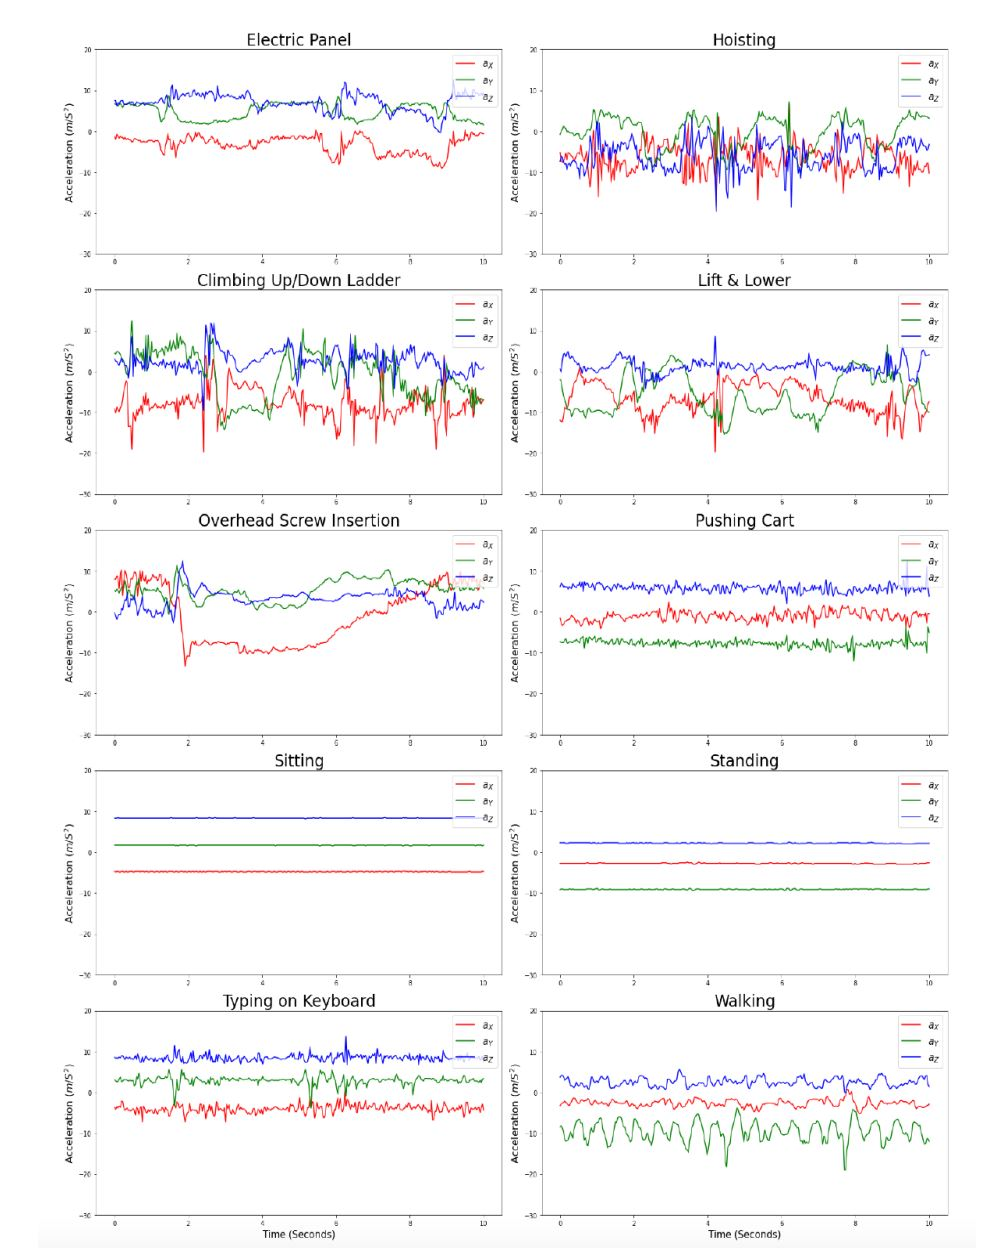

Acceleration signals in X, Y , and Z directions in a 10 seconds window presenting the 10 activities
for a sample subject.

In [16]:
df_test = pd.DataFrame(test_df2)
df_test['train/test'] = 'test'

df_train = pd.DataFrame(train_df2)
df_train['train/test'] = 'train'

final_df = pd.concat([df_train, df_test])

In [17]:
final_df.head()

1                   2                   3  \
0   -202.3693745110357  215.11806456707447  55.656564132133624   
1   -209.8316283134356  223.64318728750536   63.09934367150796   
2  -173.17095617257974  181.57081724635634   49.18476884682847   
3    -212.735276504928   224.2080714399072   62.38424436967845   
4   -281.9923323725716   299.9370219369195   85.78020804627073   

                    4                   5                    6  \
0   72.95490362611825  -269.7542705053489    10.96840163523047   
1    77.3754675555916  -377.2602003403886   -62.78536059400316   
2    54.5873759562063  -273.3590164971125  -117.30367214866257   
3   70.80226994365607  -349.4186010631614  -101.73860159572922   
4  102.18875481903687  -371.4787573707491  -25.197840397203887   

                     7                    8                    9  \
0  -226.45629356644497   -256.6466282688498   -180.7728203772557   
1  -218.20959654702162   -250.9779363630751  -147.77942416696837   
2  -145.46508898014952  -240.15821357072332  -130.99513700538114   
3  -199.03289762216076   -277.9324091632854   -140.3321368463215   
4   -342.2899831171985  -351.51811277034193  -221.36623481332907   

                  10  ...                 210                   211  \
0  2.772588722239781  ...  11.763840419649807    0.1337695442123757   
1  2.772588722239781  ...  23.217635650638126  -0.19289680093136077   
2  2.772588722239781  ...  17.982040937928993     0.378436283541969   
3  2.772588722239781  ...  14.905142936699127    0.1454373402810018   
4  2.772588722239781  ...  12.037496206417444    0.5004301750612836   

                   212                 213                214  215  216  \
0   -1.956674571697016  1.9736203293180183  5.093750200806762   96   94   
1   -2.209474691539908  1.8851773381475105  5.093750200806762   97   97   
2  -2.1911749739567377  2.4995410350245577  5.093750200806762   94   96   
3  -2.3797344204154625  2.0559553035140476  5.093750200806762  103  103   
4  -1.2604206062102752   2.210830830771795  5.093750200806762   93   92   

           label subID train/test  
0  electricPanel     9      train  
1  electricPanel     9      train  
2  electricPanel     9      train  
3  electricPanel     9      train  
4  electricPanel     9      train  

[5 rows x 219 columns]

## Saving the dataframe

Since we couldn't continue doing the federated analysis on our local operating systems (we had windows and Mac OS, and we needed Linux for full support on federated learning libraries), we saved the final dataframe at the end of the Part_1_Data_Preparation notebook to be used directly in the next steps.
Please refer to Part2_Federated_Learning dock for the rest of the implementation of our project.

In [19]:
final_df.to_csv('/Users/Asus/Downloads/finaldf.csv')